In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.targeted_attack import FGA
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from tqdm import tqdm
import argparse
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import random # for random choice of nodes
import logging # for logging file

In [ ]:
################################ split adjacency matrixes and find nodes which have changes##########################
# Set up seeds
seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Set up logging
logging.basicConfig(filename='results.log', filemode='w', level=logging.INFO, format='%(message)s')
logger = logging.getLogger()


################################ Data loading- features-test #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn')
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

#############################  preprocessing ############################
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

# print ("adj shape: ", adj.shape)
# print ("features shape: ", features.shape)
# print ("labels shape: ", labels.shape)  
# print (features)


# Split graph into two subgraphs for Crypto'Graph: by randomly removing some edges.but the nodes are the same
proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

print ("adj1 shape: ", adj1.shape)
print ("adj2 shape: ", adj2.shape)


# Assuming adj1 and adj2 are your adjacency matrices
# Step 1: Check dimensions
if adj1.shape != adj2.shape:
    print("Matrices have different dimensions.")
else:
    # Step 2: Find differences
    differences = np.abs(adj1 - adj2)
    
    # Step 3: Count differences
    total_differences = np.sum(differences)
    print(f"Total number of differences: {total_differences}")
    
    # Count non-zero differences (i.e., actual changes)
    # changes = np.count_nonzero(differences)
    # print(f"Number of elements that differ: {changes}")
    
    # Step 4: Count rows
    rows = adj1.shape[0]
    print(f"adj1. Number of rows: {rows}")
    rows_adj2= adj2.shape[0]
    print(f"adj2. Number of rows: {rows_adj2}")

    # Identify rows with changes
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")

    # Print out the specific rows with changes
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")
    # f.write(f"Rows with different connectivities: {changed_rows}\n")



In [ ]:
####### Visualization of the adjacency matrix and check if it is weighted or not
adj1_dense = adj1.toarray()
# print(adj1_dense)

plt.imshow(adj1_dense, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

adj2_dense = adj2.toarray()
plt.imshow(adj2_dense, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Print the first 10x10 submatrix of the adjacency matrix
print(adj1_dense[:10, :10])
print(adj2_dense[:10, :10])

# Check if the adjacency matrix is weighted or not
def is_weighted(adj_matrix):
    # Flatten the matrix to a 1D array for easy iteration
    flat_matrix = adj_matrix.flatten()
    # Check if all values are 0 or 1
    return not np.all(np.logical_or(flat_matrix == 0, flat_matrix == 1))
print("The adj1 is weighted:", is_weighted(adj1_dense))
print("The adj2 is weighted:", is_weighted(adj2_dense))



In [ ]:
#### check only main adj matrix################

node_id = 4
adj_dense = adj.toarray()
# adj2_dense = adj2.toarray()
row_adj = adj_dense[node_id, :]  # Get the row for node_id from adj1
# row_adj2 = adj2_dense[node_id, :]  # Get the row for node_id from adj2

print(f"Node {node_id} connectivities in adj: {row_adj}")
print(f"Node {node_id} connectivities in adj: {[f'index {i}: value {v}' for i, v in enumerate(row_adj)]}")
print(f"Node {node_id} connectivities in adj with value 1.0: {[f'index {i}: value {v}' for i, v in enumerate(row_adj) if v == 1.0]}")

gr = nx.from_scipy_sparse_array(adj)
print(f"adj is ",gr)

# Directly compare edges for node 0 in both graphs
edges_gr = set(gr.edges(node_id))
print(f"Edges of node {node_id} in gr: {edges_gr}")



In [ ]:
#################################  check the differences between adj1 and adj2 ############################
# Adjust numpy print options to show full arrays
# np.set_printoptions(threshold=np.inf)

node_id = 4
adj1_dense = adj1.toarray()
adj2_dense = adj2.toarray()
row_adj1 = adj1_dense[node_id, :]  # Get the row for node_id from adj1
row_adj2 = adj2_dense[node_id, :]  # Get the row for node_id from adj2

# row_adj1 = adj1[node_id, :].toarray().flatten().tolist()  # Get the row for node_id from adj1
# row_adj2 = adj2[node_id, :].toarray().flatten().tolist()  # Get the row for node_id from adj2
# differences_for_node = row_adj1 != row_adj2
# different_indices = np.where(differences_for_node)[0]  # Indices of differences

differences_for_node = row_adj1 != row_adj2
different_indices = np.where(differences_for_node)[0]

# print(f"Node {node_id} connectivities in adj1: {row_adj1}")
print(f"Node {node_id} connectivities in adj1: {[f'index {i}: value {v}' for i, v in enumerate(row_adj1)]}")
# print(f"Node {node_id} connectivities in adj2: {row_adj2}")
print(f"Node {node_id} connectivities in adj2: {[f'index {i}: value {v}' for i, v in enumerate(row_adj2)]}")
print(f"Differences for node {node_id}: {differences_for_node}")
print(f"Indices with differences for node {node_id}: {different_indices}")
print(f"only differences for node {node_id} in adj1: {[f'index {i}: value {v}' for i, v in enumerate(row_adj1) if differences_for_node[i]]}")
print(f"only differences for node {node_id} in adj2: {[f'index {i}: value {v}' for i, v in enumerate(row_adj2) if differences_for_node[i]]}")


print(f"Node {node_id} connectivities in adj1 with value 1.0: {[f'index {i}: value {v}' for i, v in enumerate(row_adj1) if v == 1.0]}")
print(f"Node {node_id} connectivities in adj2 with value 1.0: {[f'index {i}: value {v}' for i, v in enumerate(row_adj2) if v == 1.0]}")

# logger.info(f"Total number of differences: {total_differences}")
# logger.info("Node %s connectivities in adj1: %s", node_id, row_adj1)
# logger.info("Node %s connectivities in adj2: %s", node_id, row_adj2)
# logger.info("Differences for node %s: %s", node_id, differences_for_node)
# logger.info("Indices with differences for node %s: %s", node_id, np.where(differences_for_node)[0])


# Ensure adj1 and adj2 are in sparse format
adj1 = sp.csr_matrix(adj1)
adj2 = sp.csr_matrix(adj2)

# Convert adjacency matrices to networkx graphs
gr1 = nx.from_scipy_sparse_array(adj1)
print(f"after convert nx adj1 is ",gr1)
gr2 = nx.from_scipy_sparse_array(adj2)
print(f"after convert nx adj2 is ",gr2)

# Directly compare edges for node 0 in both graphs
edges_gr1 = set(gr1.edges(node_id))
edges_gr2 = set(gr2.edges(node_id))
print(f"Edges of node {node_id} in gr1: {edges_gr1}")
print(f"Edges of node {node_id} in gr2: {edges_gr2}")


# Function to filter out zero-weight edges
def filter_edges_with_weight(graph, node_id):
    return set((u, v) for u, v, d in graph.edges(node_id, data=True) if d.get('weight', 1) > 0)

# Directly compare edges for a specific node
edges_gr1_filtered = filter_edges_with_weight(gr1, node_id)
edges_gr2_filtered = filter_edges_with_weight(gr2, node_id)
print(f"Filtered edges of node {node_id} in gr1: {edges_gr1_filtered}")
print(f"Filtered edges of node {node_id} in gr2: {edges_gr2_filtered}")

edges_gr1 = list(gr1.edges(node_id, data=True))
edges_gr2 = list(gr2.edges(node_id,data=True))
print(f"Edges in gr1: {edges_gr1}")
print(f"Edges in gr2: {edges_gr2}")


# Check for differences
if edges_gr1 != edges_gr2:
    print("Differences found in edges.")
else:
    print("No differences found in edges.")


# Check if gr1 is directed or undirected
if gr1.is_directed():
    print("gr1 is a directed graph.")
else:
    print("gr1 is an undirected graph.")
# Check if gr2 is directed or undirected
if gr2.is_directed():
    print("gr2 is a directed graph.")
else:
    print("gr2 is an undirected graph.")


# Check if adjacency matrices are symmetric - if they are symmentirc graph is undirected 
def is_symmetric(matrix):
    return np.array_equal(matrix, matrix.T)
symmetry_check_adj1 = is_symmetric(adj1_dense)
symmetry_check_adj2 = is_symmetric(adj2_dense)
print(f"adj1 is symmetric: {symmetry_check_adj1}") # true or false
print(f"adj2 is symmetric: {symmetry_check_adj2}")


############## solution
# # Function to remove zero-weight edges from an adjacency matrix
# def remove_zero_weight_edges(adj):
#     adj.data[adj.data == 0] = 0
#     adj.eliminate_zeros()
#     return adj

# Remove zero-weight edges
clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())

# Convert cleaned adjacency matrices to networkx graphs
graph1 = nx.from_scipy_sparse_array(clean_adj1)
graph2 = nx.from_scipy_sparse_array(clean_adj2)


neighbors_gr1 = list(graph1.neighbors(node_id))
print(f"Neighbors of node {node_id} in gr1: {neighbors_gr1}")
neighbors_gr2 = list(graph2.neighbors(node_id))
print(f"Neighbors of node {node_id} in gr2: {neighbors_gr2}")




In [ ]:
################################# V0: adding edges - Attack repeatedly - consider crypto'Graph ###############################
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset , setting='gcn', seed=15)   
# setting='gcn' is for the GCN model, in latest experiments befor 2024-06-11 used default which is nettack
# seed=15 is for the GCN model, in latest experiments befor 2024-06-11 no seeds were used. seed is used to make the results reproducible
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems


for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    #split idx_test into two parts randomly
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)

    #split idx_test into two parts : one node for attack and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")

    #choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])

    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    # print (f"idx_test_attack",idx_test_attack)
    # print (f"idx_test_clean",idx_test_clean)
    # print ("idx_test",len (idx_test))
    # print ("train",len (idx_train))
    # print (idx_train)
    # print ("val",len (idx_val))


# Split graph into two subgraphs for Crypto'Graph: by randomly removing some edges.but the nodes are the same
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

    print ("adj1 shape: ", adj1.shape)
    print ("adj2 shape: ", adj2.shape)

    print ("adj shape: ", adj.shape)
    print ("features shape: ", features.shape)
    print ("labels shape: ", labels.shape)
   
    #check neighbors of the selected node
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]  #  Get the indices of the neighbors
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)


    # Ensure adj1 and adj2 are in sparse format
    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    # Remove zero-weight edges
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    # Convert cleaned adjacency matrices to networkx graphs
    graph1 = nx.from_scipy_sparse_array(clean_adj1)
    graph2 = nx.from_scipy_sparse_array(clean_adj2)

   
    ############################ train model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)
    #acc_test = accuracy(output, labels, idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)

    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 0: attack on the whole graph - on idx_test_attack nodes

    modified_adj1 =  clean_adj1.copy()
    # modified_adj1 =  adj2.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)


    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    print("*************** mahsa attack ***************")
    # Set the budget for the attack
    budget = 90

    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    for target_node in idx_test_attack:
        non_neighbor_opposit = backdoor.find_non_neighbor_opposit_label(attacked_graph, target_node)
        max_same_min_opposit_label_neighbors = backdoor.find_max_same_min_opposit_label_neighbors(attacked_graph, non_neighbor_opposit)
        nodes_for_attack = backdoor.nodes_for_attack(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        attacked_graph = backdoor.insert_edge(attacked_graph, target_node, nodes_for_attack)
        backdoor.evaluate_graph(attacked_graph, nodes_for_attack, target_node, budget)
        
    print(attacked_graph)
    print(f"total inserted edges : {attacked_graph.number_of_edges() - graph.number_of_edges()}")

    # check for the differences between the initial graph and the attacked graph----- adj wise
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    #compare adjs check
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    # Count the number of changes
    num_changes = len(non_zero_diff[0])/2
    print(f"adj wise: Number of modifications after attack: {num_changes}")
    
    # compare graphs check
    initial_edges = graph.number_of_edges()
    attacked_edges = attacked_graph.number_of_edges()
    print(f"graph check : Initial edges: {initial_edges} and attacked edges: {attacked_edges}")
    print(f"graph check: Total inserted edges after attack: {attacked_edges - initial_edges}")
    
    n1=list(graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n1)} neighbors ofter attack and they are: {n1}")
    n2=list(attacked_graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n2)} neighbors ofter attack and they are: {n2}")

    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set: ", accuracy_test_attack_2)
    print("Test accuracy on clean set: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(modified_adj1.copy(), adj2.copy(), 
                features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_3)
    print("Test accuracy on clean set: ", accuracy_test_clean_3)



    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")
   
    
    ################# adj wise compare by adj1 and modified_adj1 (before and after defense)
    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    # print(f"adj check: differences: {differences}")
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")


    # Compute the difference matrix for the full symmetric matrix
    difference_matrix = CG_defended_adj1 - modified_adj1
    # Identify the removed edges (negative values in the difference matrix)
    removed_edges = np.argwhere(difference_matrix < 0)
    # print("Removed edges (row, col):")
    # for edge in removed_edges:
    #     print(edge)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges considering full symetric matrix: {total_removed_edges}")

    # compute the difference matrix for the upper triangle of the symmetric matrix 
    # Get the indices of the upper triangle of the matrix, excluding the diagonal
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    # Select only the upper triangle (excluding diagonal) from the difference matrix
    upper_triangle_differences = difference_matrix[rows, cols]
    # Identify the removed edges in the upper triangle (negative values)
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    # Count the total number of removed edges
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")
    # Print the removed edges
    # print("Removed edges in adjacency matrix (row, col):")
    # for edge in removed_edges:
    #     print(edge)


   
    ################# check exact edges which are removed by CG defense ################
    # Identify the edges added during the attack
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")

    # Check if the added edges are removed by CG defense
    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges by CG defense: {removed_edges_by_CG}")
   




    ##################  graph wise compare by adj1 and modified_adj1 (before and after defense) 
    print("*************** graph wise compare (before and after defense) ***************")
    # Remove zero-weight edges
    modified_adj1_cleaned = backdoor.remove_zero_weight_edges(modified_adj1.copy())
    CG_defended_adj1_cleaned = backdoor.remove_zero_weight_edges(CG_defended_adj1.copy())

    #Create a NetworkX graph from the adjacency matrix
    graph_modified_adj1 = nx.from_scipy_sparse_array(modified_adj1_cleaned) #before defense
    graph_CG_1 = nx.from_scipy_sparse_array(CG_defended_adj1_cleaned) # after defense

    # print(graph_CG_1)
    print(f"graph graph_modifeid_adj1 before CG: {graph_modified_adj1.number_of_edges()} edges")
    print(f"graph graph_CG_1 after CG: {graph_CG_1.number_of_edges()} edges")

    # Identify removed edges in the graph
    removed_edges_graph = set(graph_modified_adj1.edges()) - set(graph_CG_1.edges())
    # Print the removed edges
    # print("Removed edges in NetworkX graphs (node1, node2):")
    # for edge in removed_edges_graph:
    #     print(edge)

    # Total number of removed edges
    total_removed_edges_graph = len(removed_edges_graph)
    print(f"Total number of removed edges (NetworkX graphs): {total_removed_edges_graph}")


    print("*************** graph wise - check if inserted edges are removed ***************")
    # if inserted edges are eremoved or not: NX graphs
    inserted_edges = set(attacked_graph.edges()) - set(graph.edges())
    # Print inserted edges
    print("Inserted edges (node1, node2):")
    for edge in inserted_edges:
        print(edge)
   
    # Check if inserted edges have been deleted by Crypto'Graph defense
    deleted_inserted_edges = inserted_edges - set(graph_CG_1.edges())

    # Print deleted inserted edges
    print("Deleted inserted edges by Crypto'Graph defense (node1, node2):")
    for edge in deleted_inserted_edges:
        print(edge)

    # Total number of deleted inserted edges
    total_deleted_inserted_edges = len(deleted_inserted_edges)
    print(f"Total number of deleted inserted edges: {total_deleted_inserted_edges}")

    ####another ay : 
    # Calculate intersection of inserted and removed edges
    intersected_edges = inserted_edges.intersection(removed_edges_graph)
    # Check if any inserted edge was removed
    if intersected_edges:
        print("Inserted edges that were removed (node1, node2):")
        for edge in intersected_edges:
            print(edge)
    else:
        print("No inserted edges were removed.")
        
    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)


In [ ]:
################################# V0 - Plotting ACcuracies #######################################
####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# print("Standard deviation of test accuracy on attack set 1: ", accuracy_test_attack_1_std)
# print("Standard deviation of test accuracy on clean set 1: ", accuracy_test_clean_1_std)
# print("Standard deviation of test accuracy on attack set 2: ", accuracy_test_attack_2_std)
# print("Standard deviation of test accuracy on clean set 2: ", accuracy_test_clean_2_std)
# print("Standard deviation of test accuracy on attack set 3: ", accuracy_test_attack_3_std)
# print("Standard deviation of test accuracy on clean set 3: ", accuracy_test_clean_3_std)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

# print("Average test accuracy on attack set 1: ", accuracy_test_attack_1_avg)
# print("Average test accuracy on clean set 1: ", accuracy_test_clean_1_avg)
# print("Average test accuracy on attack set 2: ", accuracy_test_attack_2_avg)
# print("Average test accuracy on clean set 2: ", accuracy_test_clean_2_avg)
# print("Average test accuracy on attack set 3: ", accuracy_test_attack_3_avg)
# print("Average test accuracy on clean set 3: ", accuracy_test_clean_3_avg)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    
##################################
          
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# # Create the bar chart
# bars1 = plt.bar(x - width/2, values[::2], width, label='Attack set', color='red')
# bars2 = plt.bar(x + width/2, values[1::2], width, label='Clean set', color='blue')

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])

# Add a legend
plt.legend()

# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()

# Display the chart
plt.show()

In [ ]:
################################# Attack one node (adding label) each time to discover node conditions ###############################
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn')
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    #split idx_test into two parts : one node for attack and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")

    #choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 611
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

   
    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    # print ("idx_test",len (idx_test))
    # print ("train",len (idx_train))
    # print ("val",len (idx_val))

    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ tarin model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)
    #acc_test = accuracy(output, labels, idx_test)

    # accuracies = model.test(idx_test) 
    # print("Test accuracy: ", accuracies)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)

    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 0: attack on the whole graph - on idx_test_attack nodes

    modified_adj1 =  adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)

    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    # Set the budget for the attack
    budget = 5

    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    for target_node in idx_test_attack:
        non_neighbor_opposit = backdoor.find_non_neighbor_opposit_label(attacked_graph, target_node)
        max_same_min_opposit_label_neighbors = backdoor.find_max_same_min_opposit_label_neighbors(attacked_graph, non_neighbor_opposit)
        nodes_for_attack = backdoor.nodes_for_attack(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        attacked_graph = backdoor.insert_edge(attacked_graph, target_node, nodes_for_attack)
        backdoor.evaluate_graph(attacked_graph, nodes_for_attack, target_node, budget)
   
    print ( f"idx_test_attack: {idx_test_attack}")
    neighbors_same_label = backdoor.find_same_neighbor(graph, selected_node)
    neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, selected_node)
    print ( f"number of target same label neighbors: {len(neighbors_same_label)}")
    print ( f"number of target opposit label neighbors: {len(neighbors_opposit_label)}")
    print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    print ( f"number of target NONE neighbors opposite label: {len(backdoor.find_non_neighbor_opposit_label(graph, selected_node))}")
    print ( f"idx_test_attack opposit label NONE neighbors: {backdoor.find_non_neighbor_opposit_label(graph, selected_node)}")

    ################################## Plotting target node before attack  #######################################
    target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # edges
    nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # labels
    nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    plt.axis('off')
    plt.show()

   
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    print(f"total inserted edges : {(attacked_graph.number_of_edges() - graph.number_of_edges())}")

    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# print("Standard deviation of test accuracy on attack set 1: ", accuracy_test_attack_1_std)
# print("Standard deviation of test accuracy on clean set 1: ", accuracy_test_clean_1_std)
# print("Standard deviation of test accuracy on attack set 2: ", accuracy_test_attack_2_std)
# print("Standard deviation of test accuracy on clean set 2: ", accuracy_test_clean_2_std)
# print("Standard deviation of test accuracy on attack set 3: ", accuracy_test_attack_3_std)
# print("Standard deviation of test accuracy on clean set 3: ", accuracy_test_clean_3_std)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)


with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    

################################# Plotting Training Results#######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()                

In [ ]:
################################# V1: Attack by removing edges ###############################
################################# V2: Attack by removing edges + consider cummon neighbors for Crypto ###############################

# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn' , seed=15)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    #split idx_test into two parts : one node for attack and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")

    # choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    
    #split idx_test into two parts randomly
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

#check neighbors of the selected node
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]  #  Get the indices of the neighbors
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)


   # Ensure adj1 and adj2 are in sparse format
    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    # Remove zero-weight edges
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    # Convert cleaned adjacency matrices to networkx graphs
    graph1 = nx.from_scipy_sparse_array(clean_adj1)
    graph2 = nx.from_scipy_sparse_array(clean_adj2)


    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    # print ("idx_test",len (idx_test))
    # print ("train",len (idx_train))
    # print(f"idx_test_attack",idx_test_attack)
    # print(f"idx_test_clean",idx_test_clean)
    # print (idx_train)
    # print ("val",len (idx_val))
    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ tarin model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)
    #acc_test = accuracy(output, labels, idx_test)
    # accuracies = model.test(idx_test) 
    # print("Test accuracy: ", accuracies)
    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 1: attack on the whole graph - on idx_test_attack nodes - by only removing edges

    modified_adj1 =  clean_adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)
    
    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    print("*************** mahsa attack ***************")


    # Set the budget for the attack
    budget = 40


    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    for target_node in idx_test_attack:
        neighbor_same = backdoor.find_same_neighbor(attacked_graph, target_node)
        max_same_min_opposit_label_neighbors = backdoor.find_max_same_min_opposit_label_neighbors(attacked_graph, neighbor_same)
        # step1: we dont consider common neighbors
        # attacked_graph = backdoor.remove_edge1(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        
        # step2: we consider common neighbors
        nodes_for_remove = backdoor.nodes_for_remove(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        attacked_graph = backdoor.remove_edge2(attacked_graph, target_node, nodes_for_remove)
        backdoor.check_removing(attacked_graph,nodes_for_remove , target_node, budget)
   
    # print ( f"idx_test_attack: {idx_test_attack}")
    # neighbors_same_label = backdoor.find_same_neighbor(graph, selected_node)
    # neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, selected_node)
    # print ( f"number of target same label neighbors: {len(neighbors_same_label)}")
    # print ( f"number of target opposit label neighbors: {len(neighbors_opposit_label)}")
    # print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    # print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    # print ( f"number of target NONE neighbors opposite label: {len(backdoor.find_non_neighbor_opposit_label(graph, selected_node))}")
    # print ( f"idx_test_attack opposit label NONE neighbors: {backdoor.find_non_neighbor_opposit_label(graph, selected_node)}")

    print(attacked_graph)
    print(f"total removed edges : {attacked_graph.number_of_edges() - graph.number_of_edges()}")

    # check for the differences between the initial graph and the attacked graph----- adj wise
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    #compare adjs check
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    # Count the number of changes
    num_changes = len(non_zero_diff[0])/2
    print(f"adj wise: Number of modifications after attack: {num_changes}")
    
    # compare graphs check
    initial_edges = graph.number_of_edges()
    attacked_edges = attacked_graph.number_of_edges()
    print(f"graph check : Initial edges: {initial_edges} and attacked edges: {attacked_edges}")
    print(f"graph check: Total inserted edges after attack: {attacked_edges - initial_edges}")
    
    n1=list(graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n1)} neighbors ofter attack and they are: {n1}")
    n2=list(attacked_graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n2)} neighbors ofter attack and they are: {n2}")


     # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    print(f"total removed edges : {(graph.number_of_edges() - attacked_graph.number_of_edges())}")

    ################################## Plotting target node before attack  #######################################
    # target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    # pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # # nodes
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # # edges
    # nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # # labels
    # nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    # plt.axis('off')
    # plt.show()

   
   
    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

        
    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")
    
    ###### adj wise compare by adj1 and modified_adj1 (before and after defense)
    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    # print(f"adj check: differences: {differences}")
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")


    # Compute the difference matrix for the full symmetric matrix
    difference_matrix = CG_defended_adj1 - modified_adj1
    # Identify the removed edges (negative values in the difference matrix)
    removed_edges = np.argwhere(difference_matrix < 0)
    # print("Removed edges (row, col):")
    # for edge in removed_edges:
    #     print(edge)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges considering full symetric matrix: {total_removed_edges}")

    # compute the difference matrix for the upper triangle of the symmetric matrix 
    # Get the indices of the upper triangle of the matrix, excluding the diagonal
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    # Select only the upper triangle (excluding diagonal) from the difference matrix
    upper_triangle_differences = difference_matrix[rows, cols]
    # Identify the removed edges in the upper triangle (negative values)
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges via CG(adj): {total_removed_edges}")
    # Print the removed edges
    # print("Removed edges in adjacency matrix (row, col):")
    # for edge in removed_edges:
    #     print(edge)

    # added edges via CG defense
    difference_matrix_add = modified_adj1 - CG_defended_adj1 
    rows, cols = np.triu_indices_from(difference_matrix_add, k=1)
    upper_triangle_add = difference_matrix_add[rows, cols]
    added_edges = np.argwhere(upper_triangle_add < 0)
    total_added_edges = len(added_edges)
    print(f"Total number of added edges via CG (adj): {total_added_edges}")
   


    #######  graph wise compare by adj1 and modified_adj1 (before and after defense) 
    print("*************** graph wise compare for removed or added edges by CG (before and after defense) ***************")
    # Remove zero-weight edges
    modified_adj1_cleaned = backdoor.remove_zero_weight_edges(modified_adj1.copy())
    CG_defended_adj1_cleaned = backdoor.remove_zero_weight_edges(CG_defended_adj1.copy())

    #Create a NetworkX graph from the adjacency matrix
    graph_modified_adj1 = nx.from_scipy_sparse_array(modified_adj1_cleaned) #before defense
    graph_CG_1 = nx.from_scipy_sparse_array(CG_defended_adj1_cleaned) # after defense

    # print(graph_CG_1)
    print(f"graph graph_modifeid_adj1 before CG: {graph_modified_adj1.number_of_edges()} edges")
    print(f"graph graph_CG_1 after CG: {graph_CG_1.number_of_edges()} edges")

    # Identify removed edges in the graph
    # removed_edges_graph = set(graph_modified_adj1.edges()) - set(graph_CG_1.edges())
    removed_edges_graph = set(attacked_graph.edges()) - set(graph_CG_1.edges())
    # Print the removed edges
    # print("Removed edges in NetworkX graphs (node1, node2):")
    # for edge in removed_edges_graph:
    #     print(edge)
    # Total number of removed edges
    total_removed_edges_graph = len(removed_edges_graph)
    print(f"Total number of removed edges (NetworkX graphs): {total_removed_edges_graph}")

    edges_added_by_CryptoGraph = set(graph_CG_1.edges()) - set(attacked_graph.edges())
    print(f"Total number of edges added by Crypto'Graph: {len(edges_added_by_CryptoGraph)}")
    print("Edges added by Crypto'Graph (node1, node2):")
    for edge in edges_added_by_CryptoGraph:
        print(edge)

    print("*************** graph wise - check if removed edges are back via CG ***************")
    # if inserted edges are eremoved or not: NX graphs
    removed = (set(graph.edges()) - set(attacked_graph.edges()) )
    print(f"Total number of edges deleted by the attack: {len(removed)}")
    print("removed edges (node1, node2):")
    for edge in removed:
        print(edge)
   
    # Check if inserted edges have been deleted by Crypto'Graph defense
    readded_removed_edges = removed & set(graph_CG_1.edges())
    print(f"Total number of edges re-added by Crypto'Graph: {len(readded_removed_edges)}")
    print("added removed edges by Crypto'Graph defense (node1, node2):")
    for edge in readded_removed_edges:
        print(edge)

 


    
    
    
    
    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# print("Standard deviation of test accuracy on attack set 1: ", accuracy_test_attack_1_std)
# print("Standard deviation of test accuracy on clean set 1: ", accuracy_test_clean_1_std)
# print("Standard deviation of test accuracy on attack set 2: ", accuracy_test_attack_2_std)
# print("Standard deviation of test accuracy on clean set 2: ", accuracy_test_clean_2_std)
# print("Standard deviation of test accuracy on attack set 3: ", accuracy_test_attack_3_std)
# print("Standard deviation of test accuracy on clean set 3: ", accuracy_test_clean_3_std)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)


with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    

################################# Plotting Training Results #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()                

In [ ]:
################# TESTTTTTTT for analysis of the graph and nodes before attack ###############################

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

#############################  preprocessing ############################
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

modified_adj =  adj.copy()

# Create a NetworkX graph from the adjacency matrix
graph = nx.from_scipy_sparse_array(modified_adj)
# Add labels to the graph
for node_id, label in enumerate(labels):
    graph.nodes[node_id]['label'] = label
# print(f"lenght of the labels : {len(labels)}") 
print(f"graph edges : {graph.number_of_edges()}")
print(f"graph nodes : {graph.number_of_nodes()}")

#########################analysis of the graph and nodes before attack ###############################

# all 
def count_neighbor_labels(graph, labels):
    count_dict = {} # dictionary type variable with key: node, and value of: (same_label, opposite_label)
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        same_label = sum(labels[neighbor] == labels[node] for neighbor in neighbors)
        opposite_label = len(neighbors) - same_label
        count_dict[node] = (same_label, opposite_label)
    return count_dict

count_dict = count_neighbor_labels(graph, labels)
# Sort nodes by the number of same-label neighbors. 
# x is tuple (node, (same_label, opposite_label)). so x[1][0] is index 0 from the second element of the tuple = same_lable 
sorted_nodes = sorted(count_dict.items(), key=lambda x: x[1][0], reverse=True) 

# print(f"Nodes and their same-label and opposite-label neighbors: {count_dict}")
print(f"sorted nodes based on the number of same-label neighbors: {sorted_nodes}")

# returns a dict of nodes which have most same label and most opposite labels with the target node
def sort_classly(count_dict, labels, target_node):
    nodes_class_same = {node: counts for node, counts in count_dict.items() if labels[node] == labels[target_node]}
    nodes_class_opp = {node: counts for node, counts in count_dict.items() if labels[node] != labels[target_node]}
    sorted_nodes_same = sorted(nodes_class_same.items(), key=lambda x: x[1][0], reverse=True)
    sorted_nodes_opp = sorted(nodes_class_opp.items(), key=lambda x: x[1][0], reverse=True)
    return sorted_nodes_same, sorted_nodes_opp

sorted_nodes_same, sorted_nodes_opp = sort_classly(count_dict, labels, 499)
# Print the top 10 nodes for each class
# print(f"The most same-label neighbors in same class of label with node {499}: {sorted_nodes_same[:10]}")
# print(f"The most same-label neighbors in class 1: {sorted_nodes_opp[:10]}")
# print (f"label of node is: {labels[671]}")

In [ ]:
################### V3-0 : Attack by removing edges + adding edge: (le budget égal pour ajouter, enlever) ###############
################### Attack by removing edges + adding edges: for 10% nodes, for one node, for manually selection of nodes 
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset,setting='gcn', seed=15)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    ######################

    ############### choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    ######################

    ################ split idx_test into two parts randomly with a specific ratio %
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

  # Ensure adj1 and adj2 are in sparse format
    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    # Remove zero-weight edges
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    # Convert cleaned adjacency matrices to networkx graphs
    graph1 = nx.from_scipy_sparse_array(clean_adj1)
    graph2 = nx.from_scipy_sparse_array(clean_adj2)


#check neighbors of the selected node
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]  #  Get the indices of the neighbors
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)

   
    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    # print ("idx_test",len (idx_test))
    # print ("train",len (idx_train))
    # print(f"idx_test_attack",idx_test_attack)
    # print(f"idx_test_clean",idx_test_clean)
    # print ("val",len (idx_val))
    # print (idx_train)
    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ train model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 1: attack on the whole graph - on idx_test_attack nodes - by only removing edges

    modified_adj1 =  clean_adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)
    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    print("*************** mahsa attack ***************")

    # Set the budget for the attack
    budget = 90

    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    count_dict = backdoor.count_neighbor_labels_0(graph, labels)
    print (count_dict)        


    for target_node in idx_test_attack:
        sorted_nodes_same, sorted_nodes_opp = backdoor.sort_classly(count_dict, labels, target_node)# sort nodes based on the number of same and opposite label neighbors
        remove_budget = budget // 2
        add_budget = budget - remove_budget
        attacked_graph,removed_edges,added_edges = backdoor.add_remove(attacked_graph, target_node, sorted_nodes_same, sorted_nodes_opp, remove_budget, add_budget)
            

    print(f"Removed {len(removed_edges)} edges: {removed_edges}")
    print(f"Added {len(added_edges)} edges: {added_edges}")    
    
    print ( f"idx_test_attack: {idx_test_attack}")
    # neighbors_same_label = backdoor.find_same_neighbor(graph, selected_node)
    # neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, selected_node)
    # print ( f"number of target same label neighbors before attack: {len(neighbors_same_label)}")
    # print ( f"number of target opposit label neighbors before attack: {len(neighbors_opposit_label)}")
    # print( f"idx_test_attack same all over the graph : {len(sorted_nodes_same)}")
    # print( f"idx_test_attack opposit label all over the graph: {len(sorted_nodes_opp)}")
    
    # # neighbors_same_after = backdoor.find_same_neighbor(attacked_graph, selected_node)
    # # neighbors_opposit_after = backdoor.find_opposit_neighbor(attacked_graph, selected_node)
    # print ( f"idx_test_attack same label neighbors after attack: {len(neighbors_same_after)}")
    # print ( f"idx_test_attack opposit label neighbors after attack: {len(neighbors_opposit_after)}")


    # print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    # print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    # print (f"same label all over graph : (node, (num of same label, num of opposit label)){sorted_nodes_same}")
    # print (f"as above for opposite lables{sorted_nodes_opp}")
    
    def is_neighbor(graph, node1, node2):
        return graph.has_edge(node1, node2) or graph.has_edge(node2, node1)

    # is_neighbor = is_neighbor(attacked_graph, 300, 499)
    # print ( f"label of target node is: {labels[499]}")
    # print ( f"label of node 300 is: {labels[300]}")
    # print ( is_neighbor)

    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    #print(f"total removed edges : {(graph.number_of_edges() - attacked_graph.number_of_edges())}")

    print(attacked_graph)
    # print(f"total removed edges : {attacked_graph.number_of_edges() - graph.number_of_edges()}")

    # check for the differences between the initial graph and the attacked graph----- adj wise
    #compare adjs check
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    # Count the number of changes
    num_changes = len(non_zero_diff[0])/2
    print(f"adj wise: Number of modifications after attack: {num_changes}")
    
    n1=list(graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n1)} neighbors before attack and they are: {n1}")
    n2=list(attacked_graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n2)} neighbors after attack and they are: {n2}")



    ################################## Plotting target node before attack  #######################################
    # target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    # pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # # nodes
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # # edges
    # nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # # labels
    # nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    # plt.axis('off')
    # plt.show()

   
    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")
    
    
    ############################## adj wise compare by adj1 and modified_adj1 (before and after defense)
    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    # print(f"adj check: differences: {differences}")
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")


    # Compute the difference matrix for the full symmetric matrix
    difference_matrix = CG_defended_adj1 - modified_adj1
    # Identify the removed edges (negative values in the difference matrix)
    removed_edges = np.argwhere(difference_matrix < 0)
    # print("Removed edges (row, col):")
    # for edge in removed_edges:
    #     print(edge)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges considering full symetric matrix: {total_removed_edges}")

    # compute the difference matrix for the upper triangle of the symmetric matrix 
    # Get the indices of the upper triangle of the matrix, excluding the diagonal
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    # Select only the upper triangle (excluding diagonal) from the difference matrix
    upper_triangle_differences = difference_matrix[rows, cols]
    # Identify the removed edges in the upper triangle (negative values)
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    # Count the total number of removed edges
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")
    # Print the removed edges
    # print("Removed edges in adjacency matrix (row, col):")
    # for edge in removed_edges:
    #     print(edge)


      
    ################# check exact edges which are removed by CG defense ################
    # Identify the edges added during the attack
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")

    # Check if the added edges are removed by CG defense
    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges by CG defense: {removed_edges_by_CG}")
   

    
     ###### check if  added edges via CG defense
    difference_matrix_add = modified_adj1 - CG_defended_adj1 
    rows, cols = np.triu_indices_from(difference_matrix_add, k=1)
    upper_triangle_add = difference_matrix_add[rows, cols]
    added_edges = np.argwhere(upper_triangle_add < 0)
    total_added_edges = len(added_edges)
    print(f"Total number of added edges via CG (adj): {total_added_edges}")
   


    #######  graph wise compare by adj1 and modified_adj1 (before and after defense) 
    print("*************** graph wise compare for removed or added edges by CG (before and after defense) ***************")
    # Remove zero-weight edges
    modified_adj1_cleaned = backdoor.remove_zero_weight_edges(modified_adj1.copy())
    CG_defended_adj1_cleaned = backdoor.remove_zero_weight_edges(CG_defended_adj1.copy())

    #Create a NetworkX graph from the adjacency matrix
    graph_modified_adj1 = nx.from_scipy_sparse_array(modified_adj1_cleaned) #before defense
    graph_CG_1 = nx.from_scipy_sparse_array(CG_defended_adj1_cleaned) # after defense

    # print(graph_CG_1)
    print(f"graph graph_modifeid_adj1 before CG: {graph_modified_adj1.number_of_edges()} edges")
    print(f"graph graph_CG_1 after CG: {graph_CG_1.number_of_edges()} edges")

    # Identify removed edges in the graph
    # removed_edges_graph = set(graph_modified_adj1.edges()) - set(graph_CG_1.edges())
    removed_edges_graph = set(attacked_graph.edges()) - set(graph_CG_1.edges())
    # Print the removed edges
    # print("Removed edges in NetworkX graphs (node1, node2):")
    # for edge in removed_edges_graph:
    #     print(edge)
    # Total number of removed edges
    total_removed_edges_graph = len(removed_edges_graph)
    print(f"Total number of removed edges (NetworkX graphs): {total_removed_edges_graph}")

    edges_added_by_CryptoGraph = set(graph_CG_1.edges()) - set(attacked_graph.edges())
    print(f"Total number of edges added by Crypto'Graph: {len(edges_added_by_CryptoGraph)}")
    print("Edges added by Crypto'Graph (node1, node2):")
    for edge in edges_added_by_CryptoGraph:
        print(edge)

    print("*************** graph wise - check if removed/added edges are detected by CG ***************")
    # if inserted edges are eremoved or not: NX graphs
    added_by_attack = (set(attacked_graph.edges()) - set(graph.edges()) )
    print(f"Total number of edges added by the attack: {len(added_by_attack)}")
    print("added edges (node1, node2):")
    for edge in added_by_attack:
        print(edge)
    
    removed_by_attack = (set(graph.edges()) - set(attacked_graph.edges()) )
    print(f"Total number of edges deleted by the attack: {len(removed_by_attack)}")
    print("removed edges (node1, node2):")
    for edge in removed_by_attack:
        print(edge)
   
    # Check if changed edges via attack have been detected by Crypto'Graph defense
    added_edges_detected = added_by_attack - set(graph_CG_1.edges())
    # Print deleted inserted edges
    print("added edges detected and removed by Crypto'Graph defense (node1, node2):")
    for edge in added_edges_detected:
        print(edge)
    print(f"Total number of added edges detected and removed by Crypto'Graph: {len(added_edges_detected)}")


    removed_edges_detected = removed_by_attack & set(graph_CG_1.edges())
    print("removed edges detected and readded by Crypto'Graph defense (node1, node2):")
    for edge in removed_edges_detected:
        print(edge)
    print(f"Total number of removed edges detected and readded by Crypto'Graph: {len(removed_edges_detected)}")

  
    ####another ay : 
    # Calculate intersection of inserted and removed edges
    intersected_edges = added_by_attack.intersection(removed_edges_graph)
    # Check if any inserted edge was removed
    if intersected_edges:
        print("Inserted edges that were removed (node1, node2):")
        for edge in intersected_edges:
            print(edge)
    else:
        print("No inserted edges were removed.")
        



    
    
    
    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)


with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    

################################# Plotting Training Results #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()      
        

In [ ]:
################### V3.1 : Attack by removing edges + adding edge: (le budget change selon l’importance pour ajouter/enlever) ###############
################### Attack by removing edges + adding edges: for 10% nodes, for one node, for manually selection of nodes 
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    ######################

    ############### choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    print(f"Selected node for attack: {selected_node}")
    print(f"Label of the selected node: {labels[selected_node]}")
    ######################

    ################ split idx_test into two parts randomly with a specific ratio %
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

   
     # Ensure adj1 and adj2 are in sparse format
    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    # Remove zero-weight edges
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    # Convert cleaned adjacency matrices to networkx graphs
    graph1 = nx.from_scipy_sparse_array(clean_adj1)
    graph2 = nx.from_scipy_sparse_array(clean_adj2)

    #check neighbors of the selected node
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]  #  Get the indices of the neighbors
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)


    # print ("len of idx_test_clean",len (idx_test_clean))
    # print ("len of idx_test_attack",len (idx_test_attack))
    # print ("idx_test",len (idx_test))
    # print(f"idx_test_attack",idx_test_attack)
    # print(f"idx_test_clean",idx_test_clean)
    # print ("train",len (idx_train))
    # print ("val",len (idx_val))
    # print (idx_train)
    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ train model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 1: attack on the whole graph - on idx_test_attack nodes - by only removing edges

    modified_adj1 =  clean_adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)
    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    
    # Set the budget for the attack
    budget = 470

    #attacked_graph is initially set to graph, and then updated after each attack 
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    sorted_count_dict = backdoor.count_neighbor_labels(graph, labels)
    print ( f"idx_test_attack: {idx_test_attack}")
    for target_node in idx_test_attack:
        print(f"target node is: {target_node} with label: {labels[target_node]}")
        neighbors_same_label = backdoor.find_same_neighbor(graph, target_node)
        neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, target_node)
        print ( f"number of target same label neighbors before attack: {len(neighbors_same_label)}")
        print ( f"number of target opposit label neighbors before attack: {len(neighbors_opposit_label)}")
   
        attacked_graph,removed_edges,added_edges = backdoor.add_remove_v3(attacked_graph, target_node,sorted_count_dict ,budget)
        print(f"Removed {len(removed_edges)} edges: {removed_edges}")
        print(f"Added {len(added_edges)} edges: {added_edges}")    
    
      
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    #print(f"total removed edges : {(graph.number_of_edges() - attacked_graph.number_of_edges())}")


    # print( f"idx_test_attack same all over the graph : {len(sorted_nodes_same)}")
    # print( f"idx_test_attack opposit label all over the graph: {len(sorted_nodes_opp)}")
    # neighbors_same_after = backdoor.find_same_neighbor(attacked_graph, selected_node)
    # neighbors_opposit_after = backdoor.find_opposit_neighbor(attacked_graph, selected_node)
    # print ( f"idx_test_attack same label neighbors after attack: {len(neighbors_same_after)}")
    # print ( f"idx_test_attack opposit label neighbors after attack: {len(neighbors_opposit_after)}")
    # print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    # print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    # print (f"same label all over graph : (node, (num of same label, num of opposit label)){sorted_nodes_same}")
    # print (f"as above for opposite lables{sorted_nodes_opp}")
    
    # def is_neighbor(graph, node1, node2):
    #     return graph.has_edge(node1, node2) or graph.has_edge(node2, node1)

    # is_neighbor = is_neighbor(attacked_graph, 300, 499)
    # print ( f"label of target node is: {labels[499]}")
    # print ( f"label of node 300 is: {labels[300]}")
    # print ( is_neighbor)



      # check for the differences between the initial graph and the attacked graph----- adj wise
    #compare adjs check
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    # Count the number of changes
    num_changes = len(non_zero_diff[0])/2
    print(f"adj wise: Number of modifications after attack: {num_changes}")
    
    n1=list(graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n1)} neighbors before attack and they are: {n1}")
    n2=list(attacked_graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n2)} neighbors after attack and they are: {n2}")


    ################################## Plotting target node before attack  #######################################
    # target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    # pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # # nodes
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # # edges
    # nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # # labels
    # nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    # plt.axis('off')
    # plt.show()

 
    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    
    
    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    
    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")
    
    
     ############################## adj wise compare by adj1 and modified_adj1 (before and after defense)
    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    # print(f"adj check: differences: {differences}")
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")


    # Compute the difference matrix for the full symmetric matrix
    difference_matrix = CG_defended_adj1 - modified_adj1
    # Identify the removed edges (negative values in the difference matrix)
    removed_edges = np.argwhere(difference_matrix < 0)
    # print("Removed edges (row, col):")
    # for edge in removed_edges:
    #     print(edge)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges considering full symetric matrix: {total_removed_edges}")

    # compute the difference matrix for the upper triangle of the symmetric matrix 
    # Get the indices of the upper triangle of the matrix, excluding the diagonal
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    # Select only the upper triangle (excluding diagonal) from the difference matrix
    upper_triangle_differences = difference_matrix[rows, cols]
    # Identify the removed edges in the upper triangle (negative values)
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    # Count the total number of removed edges
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")
    # Print the removed edges
    # print("Removed edges in adjacency matrix (row, col):")
    # for edge in removed_edges:
    #     print(edge)


      
    ################################ check exact edges which are removed by CG defense ################
    # Identify the edges added during the attack
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")

    # Check if the added edges are removed by CG defense
    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges by CG defense: {removed_edges_by_CG}")
   

    
     ###### check if  added edges via CG defense
    difference_matrix_add = modified_adj1 - CG_defended_adj1 
    rows, cols = np.triu_indices_from(difference_matrix_add, k=1)
    upper_triangle_add = difference_matrix_add[rows, cols]
    added_edges = np.argwhere(upper_triangle_add < 0)
    total_added_edges = len(added_edges)
    print(f"Total number of added edges via CG (adj): {total_added_edges}")
   


    #######  graph wise compare by adj1 and modified_adj1 (before and after defense) 
    print("*************** graph wise compare for removed or added edges by CG (before and after defense) ***************")
    # Remove zero-weight edges
    modified_adj1_cleaned = backdoor.remove_zero_weight_edges(modified_adj1.copy())
    CG_defended_adj1_cleaned = backdoor.remove_zero_weight_edges(CG_defended_adj1.copy())

    #Create a NetworkX graph from the adjacency matrix
    graph_modified_adj1 = nx.from_scipy_sparse_array(modified_adj1_cleaned) #before defense
    graph_CG_1 = nx.from_scipy_sparse_array(CG_defended_adj1_cleaned) # after defense

    # print(graph_CG_1)
    print(f"graph graph_modifeid_adj1 before CG: {graph_modified_adj1.number_of_edges()} edges")
    print(f"graph graph_CG_1 after CG: {graph_CG_1.number_of_edges()} edges")

    # Identify removed edges in the graph
    # removed_edges_graph = set(graph_modified_adj1.edges()) - set(graph_CG_1.edges())
    removed_edges_graph = set(attacked_graph.edges()) - set(graph_CG_1.edges())
    # Print the removed edges
    # print("Removed edges in NetworkX graphs (node1, node2):")
    # for edge in removed_edges_graph:
    #     print(edge)
    # Total number of removed edges
    total_removed_edges_graph = len(removed_edges_graph)
    print(f"Total number of removed edges (NetworkX graphs): {total_removed_edges_graph}")

    edges_added_by_CryptoGraph = set(graph_CG_1.edges()) - set(attacked_graph.edges())
    print(f"Total number of edges added by Crypto'Graph: {len(edges_added_by_CryptoGraph)}")
    print("Edges added by Crypto'Graph (node1, node2):")
    for edge in edges_added_by_CryptoGraph:
        print(edge)

    print("*************** graph wise - check if removed/added edges are detected by CG ***************")
    # if inserted edges are eremoved or not: NX graphs
    added_by_attack = (set(attacked_graph.edges()) - set(graph.edges()) )
    print(f"Total number of edges added by the attack: {len(added_by_attack)}")
    print("added edges (node1, node2):")
    for edge in added_by_attack:
        print(edge)
    
    removed_by_attack = (set(graph.edges()) - set(attacked_graph.edges()) )
    print(f"Total number of edges deleted by the attack: {len(removed_by_attack)}")
    print("removed edges (node1, node2):")
    for edge in removed_by_attack:
        print(edge)
   
    # Check if changed edges via attack have been detected by Crypto'Graph defense
    added_edges_detected = added_by_attack - set(graph_CG_1.edges())
    # Print deleted inserted edges
    print("added edges detected and removed by Crypto'Graph defense (node1, node2):")
    for edge in added_edges_detected:
        print(edge)
    print(f"Total number of added edges detected and removed by Crypto'Graph: {len(added_edges_detected)}")


    removed_edges_detected = removed_by_attack & set(graph_CG_1.edges())
    print("removed edges detected and readded by Crypto'Graph defense (node1, node2):")
    for edge in removed_edges_detected:
        print(edge)
    print(f"Total number of removed edges detected and readded by Crypto'Graph: {len(removed_edges_detected)}")

  
    ####another ay : 
    # Calculate intersection of inserted and removed edges
    intersected_edges = added_by_attack.intersection(removed_edges_graph)
    # Check if any inserted edge was removed
    if intersected_edges:
        print("Inserted edges that were removed (node1, node2):")
        for edge in intersected_edges:
            print(edge)
    else:
        print("No inserted edges were removed.")
        



        
    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

################################# Plotting Training Results #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35
# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()
 

In [ ]:
###nemoodar mese aubin baraye graph ha

import matplotlib.pyplot as plt
import numpy as np

# Example data
t_values = np.linspace(0, 0.5, 50)
accuracy_values = {
    'local_jaccard_defense': np.random.random(50),
    'local_cosine_defense': np.random.random(50),
    'local_common_neighbors_defense': np.random.random(50),
    'distributed_jaccard_defense': np.random.random(50),
    'distributed_cosine_defense': np.random.random(50),
    'distributed_common_neighbors_defense': np.random.random(50),
}

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plotting on the first subplot
for key, values in accuracy_values.items():
    axs[0, 0].plot(t_values, values, label=key.replace('_', ' '))

axs[0, 0].set_title('No Attack')
axs[0, 0].set_xlabel('t (Jaccard and Cosine)')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(loc='best')
axs[0, 0].grid(True)

# Similarly, you can plot on other subplots
# This is a placeholder for illustration. You need to plot the actual data accordingly.

# Adding titles and labels for remaining subplots (repeat as necessary)
# axs[0, 1].set_title('FGSM')
# axs[1, 0].set_title('NETTACK')
# axs[1, 1].set_title('DICE')

plt.tight_layout()
plt.show()

In [ ]:
################### change V3.1 for working just in adj mode #############
################### V3.1 : Attack by removing edges + adding edge: (le budget change selon l’importance pour ajouter/enlever) ###############
################### Attack by removing edges + adding edges: for 10% nodes, for one node, for manually selection of nodes 
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    ######################

    ############### choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    print(f"Selected node for attack: {selected_node}")
    print(f"Label of the selected node: {labels[selected_node]}")
    ######################

    ################ split idx_test into two parts randomly with a specific ratio %
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

   
     # Ensure adj1 and adj2 are in sparse format
    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    # Remove zero-weight edges
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    
    #check neighbors of the selected node
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]  #  Get the indices of the neighbors
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)


    ############################ train model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    modified_adj1 =  clean_adj1.copy()
    print(f"Initial number of edges: {modified_adj1.nnz // 2}")
    print(f"Number of nodes: {modified_adj1.shape[0]}")

    # Set the budget for the attack
    budget = 20

    #attack adj 
    attacked_adj = modified_adj1.copy()
    sorted_count_dict = backdoor.count_neighbor_labels_adj(attacked_adj, labels)
    print(f"idx_test_attack: {idx_test_attack}")
    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        neighbors_same_label = backdoor.find_same_neighbor_adj(attacked_adj, labels, target_node)
        neighbors_opposit_label = backdoor.find_opposite_neighbor_adj(attacked_adj, labels, target_node)
        print(f"Number of target same label neighbors before attack: {len(neighbors_same_label)}")
        print(f"Number of target opposite label neighbors before attack: {len(neighbors_opposit_label)}")

        attacked_adj, removed_edges, added_edges = backdoor.add_remove_adj(attacked_adj, target_node, sorted_count_dict, labels, budget)
        print(f"Removed {len(removed_edges)} edges: {removed_edges}")
        print(f"Added {len(added_edges)} edges: {added_edges}")


    # Convert the adjacency matrix to a CSR matrix
    #we can omit this and just replace the modified_adj1 with attacked_adj
    modified_adj1 = csr_matrix(attacked_adj)
    print(modified_adj1)


    # check for the differences between the initial graph and the attacked graph----- adj wise
    #compare adjs check
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    # Count the number of changes
    num_changes = len(non_zero_diff[0])/2
    print(f"adj wise: Number of modifications after attack: {num_changes}")
    

    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    
    
    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    
    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")
    
    
     ############################## adj wise compare by adj1 and modified_adj1 (before and after defense)
    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    # print(f"adj check: differences: {differences}")
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")


    # Compute the difference matrix for the full symmetric matrix
    difference_matrix = CG_defended_adj1 - modified_adj1

    # compute the difference matrix for the upper triangle of the symmetric matrix 
    # Get the indices of the upper triangle of the matrix, excluding the diagonal
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    # Select only the upper triangle (excluding diagonal) from the difference matrix
    upper_triangle_differences = difference_matrix[rows, cols]
    # Identify the removed edges in the upper triangle (negative values)
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    # Count the total number of removed edges
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")
    # Print the removed edges
    # print("Removed edges in adjacency matrix (row, col):")
    # for edge in removed_edges:
    #     print(edge)


      
    ################################ check exact edges which are removed by CG defense ################
    # Identify the edges added during the attack
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")
    print(f"Total number of added edges during attack: {len(added_edges)}")

    # Check if the added edges are removed by CG defense
    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges which have been added during attack by CG defense: {removed_edges_by_CG}")
   

    ###### check if CG defense adds any edges
    difference_matrix_add = modified_adj1 - CG_defended_adj1 
    rows, cols = np.triu_indices_from(difference_matrix_add, k=1)
    upper_triangle_add = difference_matrix_add[rows, cols]
    added_edges = np.argwhere(upper_triangle_add < 0)
    total_added_edges = len(added_edges)
    print(f"CG doesn't add edges. Total number of added edges via CG (adj): {total_added_edges}")
   

     
    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

################################# Plotting Training Results #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35
# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()
 

In [ ]:
############### mahsa-V4.1: using surrogate model for attack ################
# attack adding/removing edge: (le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed, target nodes selected manually


import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.targeted_attack import FGA
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from tqdm import tqdm
import argparse
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import random # for random choice of nodes
import logging # for logging file

import random
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from copy import deepcopy
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import pickle


# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility

# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# fonction to train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                          nhid=16, device=device, dropout=0.5)   # lr=0.01, weight_decay=5e-4, with_relu=True, with_bias=True
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# function to evaluate the impact of adding/removing an edge on the model's output using the surrogate model
def evaluate_edge_impact(surrogate_model, features, adj, labels, edge, target_node, add=True):
    adj = adj.copy()
    if add:
        adj[edge[0], edge[1]] = 1
        adj[edge[1], edge[0]] = 1
    else:
        adj[edge[0], edge[1]] = 0
        adj[edge[1], edge[0]] = 0
    
    surrogate_model.eval()
    output = surrogate_model.predict(features, adj)
    target_label_change = output[target_node].argmax().item() != labels[target_node]
    other_labels_unchanged = all(output[node].argmax().item() == labels[node] for node in range(adj.shape[0]) if node != target_node)
    

    print(f"Edge: {edge}, Target node: {target_node}, Add: {add}, Target label change: {target_label_change}, Other labels unchanged: {other_labels_unchanged}")
    # Return True if the target node’s label changes and other nodes' labels remain unchanged.
    return target_label_change # and other_labels_unchanged

#  define potential edges to add and evaluate the impact of adding each edge
def select_best_edge_to_add(adj, labels, target_node, surrogate_model, features):
    potential_edges = []    
    for i in range(adj.shape[0]):
        if adj[target_node, i] == 0:
            potential_edges.append((target_node, i))
    
    best_edge = None
    for edge in potential_edges:
        if evaluate_edge_impact(surrogate_model, features, adj, labels, edge, target_node, add=True):
            best_edge = edge
            break
    
    return best_edge

def select_best_edge_to_remove(adj, labels, target_node, surrogate_model, features):
    neighbors = np.nonzero(adj[target_node])[1]
    best_edge = None
    for neighbor in neighbors:
        edge = (target_node, neighbor)
        if evaluate_edge_impact(surrogate_model, features, adj, labels, edge, target_node, add=False):
            best_edge = edge
            break
    
    return best_edge
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)

for _ in range(num_repeats):
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    print(f"Selected node for attack: {selected_node}")
    print(f"Label of the selected node: {labels[selected_node]}")

    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)

    ###### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ######## train surrogate model to find the importance of each edge
    surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

    modified_adj1 =  clean_adj1.copy()
    print(f"Initial number of edges: {modified_adj1.nnz // 2}")
    print(f"Number of nodes: {modified_adj1.shape[0]}")

    budget = 9

    ############### attack adj ################
    attacked_adj = modified_adj1.copy()
    sorted_count_dict = backdoor.count_neighbor_labels_adj(attacked_adj, labels)
    print(f"idx_test_attack: {idx_test_attack}")

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        neighbors_same_label = backdoor.find_same_neighbor_adj(attacked_adj, labels, target_node)
        neighbors_opposit_label = backdoor.find_opposite_neighbor_adj(attacked_adj, labels, target_node)
        print(f"Number of target same label neighbors before attack: {len(neighbors_same_label)}")
        print(f"Number of target opposite label neighbors before attack: {len(neighbors_opposit_label)}")


        # attacked_adj, removed_edges, added_edges = backdoor.add_remove_adj(attacked_adj, target_node, sorted_count_dict, labels, budget)

        for _ in range(budget):
            edge_add = select_best_edge_to_add(attacked_adj, labels, target_node, surrogate_model, features)
            edge_remove = select_best_edge_to_remove(attacked_adj, labels, target_node, surrogate_model, features)
            print (f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            # print(f" num of added edges: {len(edge_add)}, num of removed edges: {len(edge_remove)}")

            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                print(f"Added edge: {edge_add}")
            
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                print(f"Removed edge: {edge_remove}")

    
    ########## checkin the adj wise changes after attack ##########
    modified_adj1 = csr_matrix(attacked_adj)
    print(modified_adj1)

    # check for the differences between the initial graph and the attacked graph
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    num_changes = len(non_zero_diff[0]) // 2
    print(f"adj wise: Number of modifications after attack: {num_changes}")

    # evaluation after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ################# Crypto'Graph defense ####################3
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"
    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                          device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")

    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")

    difference_matrix = CG_defended_adj1 - modified_adj1
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    upper_triangle_differences = difference_matrix[rows, cols]
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")

    # Identify the edges added during the attack and check if they are removed by CG defense
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")
    print(f"Total number of added edges during attack: {len(added_edges)}")

    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges which have been added during attack by CG defense: {removed_edges_by_CG}")

    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)

'''
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()
'''

In [ ]:
######## mahsa-V4.1: using surrogate model for attack --- edit 1 - using loss fonc and gradiant base- edge-score  ################
# attack adding/removing edge: (le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed, target nodes selected manually

import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch import nn, optim
import torch.nn.functional as F
import scipy.sparse as sp

# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility

# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Function to train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                          nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Function to compute the gradients of the loss function w.r.t. adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return gradients

# Function to calculate edge scores based on gradients
def calculate_edge_scores(adj, gradients, target_node, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0:
            scores[(target_node, i)] = gradients[target_node, i]
        elif not add and adj[target_node, i] == 1:
            scores[(target_node, i)] = -gradients[target_node, i]
    return scores

# Function to select the best edge to add or remove based on scores
def select_best_edge(adj, gradients, target_node, add=True):
    scores = calculate_edge_scores(adj, gradients, target_node, add)
    best_edge = max(scores, key=scores.get)
    return best_edge

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)

for _ in range(num_repeats):
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    print(f"Selected node for attack: {selected_node}")
    print(f"Label of the selected node: {labels[selected_node]}")

    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)

    ###### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ######## train surrogate model to find the importance of each edge
    surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

    modified_adj1 =  clean_adj1.copy()
    print(f"Initial number of edges: {modified_adj1.nnz // 2}")
    print(f"Number of nodes: {modified_adj1.shape[0]}")

    budget = 20

    ############### attack adj ################
    attacked_adj = modified_adj1.copy()
    print(f"idx_test_attack: {idx_test_attack}")

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        neighbors_same_label = backdoor.find_same_neighbor_adj(attacked_adj, labels, target_node)
        neighbors_opposite_label = backdoor.find_opposite_neighbor_adj(attacked_adj, labels, target_node)
        print(f"Number of target same label neighbors before attack: {len(neighbors_same_label)}")
        print(f"Number of target opposite label neighbors before attack: {len(neighbors_opposite_label)}")

        gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)

        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, add=True)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, add=False)
            print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")

            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                print(f"Added edge: {edge_add}")
            
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                print(f"Removed edge: {edge_remove}")

    ########## checking the adj wise changes after attack ##########
    modified_adj1 = csr_matrix(attacked_adj)
    print(modified_adj1)

    # check for the differences between the initial graph and the attacked graph
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    num_changes = len(non_zero_diff[0]) // 2
    print(f"adj wise: Number of modifications after attack: {num_changes}")

    # evaluation after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ################# Crypto'Graph defense ####################3
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"
    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                          device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")

    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")

    difference_matrix = CG_defended_adj1 - modified_adj1
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    upper_triangle_differences = difference_matrix[rows, cols]
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")

    # Identify the edges added during the attack and check if they are removed by CG defense
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")
    print(f"Total number of added edges during attack: {len(added_edges)}")

    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges which have been added during attack by CG defense: {removed_edges_by_CG}")

    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)

accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [ ]:
######## mahsa-V4.1: using surrogate model - edit 2 - using loss fonc and gradiant base- edge-score and commun neighbor ################
# attack adding/removing edge: (le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed, target nodes selected manually
#  reports on this one but made changes, now not working  , needs reveiw

import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch import nn, optim
import scipy.sparse as sp
import pickle

# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility

# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Function to train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                          nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Function to compute the gradients of the loss function with respect to adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval() # sets the surrogate model to evaluation mode. In evaluation mode, certain layers (like dropout and batch normalization) behave differently compared to training mode.
    # Convert adjacency matrix to PyTorch tensor and enable gradient computation
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
     # Convert feature matrix and labels to PyTorch tensors
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    # Forward pass: compute model output (predictions) 
    output = surrogate_model(features, adj) 
    # Compute loss for the target node: how well the model's prediction matches the true label for the target_node
    loss = F.nll_loss(output[[target_node]], labels[[target_node]]) 
    #The backward pass computes the gradients of the loss. These gradients indicate how changes in the adjacency matrix would affect the loss.
    loss.backward()
    gradients = adj.grad.cpu().numpy()  # The gradients are extracted from the adjacency matrix tensor and converted to a NumPy array on the CPU.
    
    print(f"Loss for target node {target_node}: {loss.item()}")
    print(f"Gradients for target node {target_node}: {gradients}")
    # Check for non-zero gradients
    if not np.any(gradients):
        print(f"No non-zero gradients found for target node {target_node}.")
    else:
        non_zero_gradients = np.nonzero(gradients)
        print(f"Non-zero gradients for target node {target_node}:")
        for index in zip(*non_zero_gradients):
            print(f"Gradient at {index}: {gradients[index]}")

    return gradients


# Function to calculate edge scores based on gradients
# def calculate_edge_scores(adj, gradients, target_node, add=True):
#     scores = {}
#     for i in range(adj.shape[0]):
#         if add and adj[target_node, i] == 0:
#             scores[(target_node, i)] = gradients[target_node, i]  # if gradient is positive, it means that adding the edge would increase the loss
#         elif not add and adj[target_node, i] == 1:
#             scores[(target_node, i)] = -gradients[target_node, i] # if gradient is negative, it means that removing the edge would increase the loss
#     return scores # The scores (gradiants) are returned as a dictionary where the keys are the edges and the values are the gradients.

def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors) # The number of common neighbors between the two nodes is returned.

# Function to calculate edge scores based on gradients and common neighbors ...... it worked at least
def calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0 and labels[target_node] != labels[i]:  # Ensure different labels for adding
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] + common_neighbors
        elif not add and adj[target_node, i] == 1 and labels[target_node] == labels[i]:  # Ensure same labels for removing
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors 
    return scores



#it has problem, nothing is not added or removed
# def calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels):
#     add_scores = {}
#     remove_scores = {}
#     for i in range(adj.shape[0]):
#         # print(f"Common neighbors between {target_node} and {i}: number of neighbors:{len(common_neighbors)} and list is {common_neighbors}")
#         if adj[target_node, i] == 0 and labels[target_node] != labels[i]:  # if not neighbor and not same label : adding
#             common_neighbors = calculate_common_neighbors(adj, target_node, i)
#             add_scores[(target_node, i)] = gradients[target_node, i] + common_neighbors
#             # print(f"Add score for edge ({target_node}, {i}): {add_scores[(target_node, i)]}")
#         elif adj[target_node, i] == 1 and labels[target_node] == labels[i]:  # if neighbor and  same label : removing
#             common_neighbors = calculate_common_neighbors(adj, target_node, i)
#             remove_scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors  # if gradient is negative, it means that removing the edge would increase the loss, so we put ne - to have a positive score to find the best edge to remove
#             # print(f"Remove score for edge ({target_node}, {i}): {remove_scores[(target_node, i)]}")
#     return add_scores, remove_scores


##### last version ----it worked at least but adds and removes.
def select_best_edge_common_neighbors(adj, gradients, target_node, labels, add=True):
    scores = calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels, add)
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge

#### it has problem, nothing is not added or removed
# def select_best_edge_common_neighbors(adj, gradients, target_node, labels):
#     add_scores, remove_scores = calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels)
#     if not add_scores and not remove_scores:
#         return None, None
#     best_add_edge = max(add_scores, key=add_scores.get) if add_scores else None
#     best_remove_edge = max(remove_scores, key=remove_scores.get) if remove_scores else None
    
#     best_add_score = add_scores[best_add_edge] if best_add_edge else float('-inf')
#     best_remove_score = remove_scores[best_remove_edge] if best_remove_edge else float('-inf')
#     if best_add_score > best_remove_score:
#         return best_add_edge, 'add'
#     else:
#         return best_remove_edge, 'remove'


################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)

for _ in range(num_repeats):
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    print(f"Selected node for attack: {selected_node}")
    print(f"Label of the selected node: {labels[selected_node]}")
    
    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    ################ split idx_test into two parts randomly with a specific ratio %
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################

    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)

    ###### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ######## train surrogate model to find the importance of each edge
    surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

    modified_adj1 =  clean_adj1.copy()
    print(f"Initial number of edges: {modified_adj1.nnz // 2}")
    print(f"Number of nodes: {modified_adj1.shape[0]}")

    budget = 30
    ############### attack adj ################
    attacked_adj = modified_adj1.copy()
    print(f"idx_test_attack: {idx_test_attack}")
    edges_added_count = 0
    edges_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        # neighbors_same_label = backdoor.find_same_neighbor_adj(attacked_adj, labels, target_node)
        # neighbors_opposite_label = backdoor.find_opposite_neighbor_adj(attacked_adj, labels, target_node)
        # print(f"Number of target same label neighbors before attack: {len(neighbors_same_label)}")
        # print(f"Number of target opposite label neighbors before attack: {len(neighbors_opposite_label)}")

        # Compute gradients and their signs
        gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        print(f"Gradients for target node {target_node}: {gradients}")
        
        ##### it shows that all the gradients are zero, so we can not use them for attack
        if not np.any(gradients):
            print(f"No non-zero gradients found for target node {target_node}. Skipping this node.")
            continue


        #### it works but it adds and removes
        for _ in range(budget):
            edge_add = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels, add=True)
            edge_remove = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels, add=False)
            print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                edges_added_count += 1
                print(f"Added edge: {edge_add}")
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                edges_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                
        #### it is not working, nothing is added or removed
        # for _ in range(budget):
        #         best_edge, action = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels)
        #         if not best_edge:
        #             continue

        #         if action == 'add':
        #             attacked_adj[best_edge[0], best_edge[1]] = 1
        #             attacked_adj[best_edge[1], best_edge[0]] = 1
        #             edges_added_count += 1
        #             print(f"Added edge: {best_edge}")

        #         elif action == 'remove':
        #             attacked_adj[best_edge[0], best_edge[1]] = 0
        #             attacked_adj[best_edge[1], best_edge[0]] = 0
        #             edges_removed_count += 1
        #             print(f"Removed edge: {best_edge}")

        print(f"Total number of added edges during attack: {edges_added_count}")
        print(f"Total number of removed edges during attack: {edges_removed_count}")





    ########## checking the adj wise changes after attack ##########
    modified_adj1 = csr_matrix(attacked_adj)
    print (f"Number of edges added: {edges_added_count}")
    print (f"Number of edges removed: {edges_removed_count}")
    # print(modified_adj1)

    # check for the differences between the initial graph and the attacked graph
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    num_changes = len(non_zero_diff[0]) // 2
    print(f"adj wise: Number of modifications after attack: {num_changes}")

    # evaluation after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ################# Crypto'Graph defense ####################3
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"
    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                          device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")

    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    # changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    # print(f"Rows with different connectivities: {changed_rows}")

    difference_matrix = CG_defended_adj1 - modified_adj1
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    upper_triangle_differences = difference_matrix[rows, cols]
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj) by the CG: {total_removed_edges}")

    # Identify the edges added during the attack and check if they are removed by CG defense
    added_edges = []
    removed_edges_by_CG = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")
    print(f"Total number of added edges during attack: {len(added_edges)}")

    removed_edges = []
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 0 and clean_adj1_array[i, j] == 1:
            removed_edges.append((i, j))
    print(f"Removed edges during attack: {removed_edges}")
    print(f"Total number of removed edges during attack: {len(removed_edges)}")


    # check if added edges are removed by CG defense
    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"added edges during attack which are removed by CG defense: {removed_edges_by_CG}")
    print(f"Total number of added edges during attack which are removed by CG defense: {len(removed_edges_by_CG)}")

    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)

accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [29]:
#################### checkings if we have nodes with gradiants non zero losses non zero ... ################
####### choosing nodes for attack by selecting the nodes with non zero gradients and non zero losses ########
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch import nn, optim
import scipy.sparse as sp
import pickle


seed = 42  # Seed for reproducibility
num_repeats = 1

# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Function to train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                          nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Function to compute the gradients of the loss function with respect to adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval() # sets the surrogate model to evaluation mode. In evaluation mode, certain layers (like dropout and batch normalization) behave differently compared to training mode.
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    # Forward pass: compute model output (predictions) 
    output = surrogate_model(features, adj) 
    # Compute loss for the target node: how well the model's prediction matches the true label for the target_node
    loss = F.nll_loss(output[[target_node]], labels[[target_node]]) 
    #The backward pass computes the gradients of the loss. These gradients indicate how changes in the adjacency matrix would affect the loss.
    loss.backward()
    gradients = adj.grad.cpu().numpy()  # The gradients are extracted from the adjacency matrix tensor and converted to a NumPy array on the CPU.
    
    # print(f"Loss for target node {target_node}: {loss.item()}")
    # print(f"Gradients for target node {target_node}: {gradients}")
    # Check for non-zero gradients
    # if not np.any(gradients):
    #     print(f"No non-zero gradients found for target node {target_node}.")
    # else:
    #     non_zero_gradients = np.nonzero(gradients)
    #     print(f"Non-zero gradients for target node {target_node}:")
    #     for index in zip(*non_zero_gradients):
    #         print(f"Gradient at {index}: {gradients[index]}")

    return  loss.item(), gradients


################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test
print(f"Number of training nodes: {len(idx_train)}")
print(f"Number of validation nodes: {len(idx_val)}")
print(f"Number of test nodes: {len(idx_test)}")

#performing the experiment for num_repeats times
for _ in range(num_repeats):
    set_seeds(seed)
    
    ###### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

   
    ######## train surrogate model to find the importance of each edge
    surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

    # Calculate gradients and loss for each target node
    print(f"size of idx_test: {len(idx_test)}")
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0


    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)

       # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
        

        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        print(f"Loss for target node {target_node}: {loss}")
        print(f"Gradients for target node {target_node}: {'Non-zero' if not zero_gradients else 'Zero'}")
      
    # Print the counts of nodes with zero loss and zero gradients
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
   
    print("Nodes with non-zero loss and non-zero gradients:")
    for node in non_zero_loss_and_gradients_nodes:
        print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score in descending order
    non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)

    # Select top k nodes to attack
    k = 10  # Number of nodes to attack
    nodes_to_attack = [node for node, impact_score in non_zero_loss_and_gradients_nodes[:k]]
    print(f"Nodes to attack (node_id):")
    print(nodes_to_attack)

    print("Nodes to attack (node_id, impact_score):")
    for node, score in non_zero_loss_and_gradients_nodes[:k]:
        print(f"Node: {node}, Impact Score: {score}")



Loading polblogs dataset...
Number of training nodes: 40
Number of validation nodes: 500
Number of test nodes: 950
Test set results: loss= 0.3826 accuracy= 0.8389
size of idx_test: 950
Target node is: 1395 with label: 1
Loss for target node 1395: 0.0
Gradients for target node 1395: Zero
Target node is: 35 with label: 0
Loss for target node 35: 0.0
Gradients for target node 35: Zero
Target node is: 754 with label: 0
Loss for target node 754: 0.0
Gradients for target node 754: Zero
Target node is: 1169 with label: 1
Loss for target node 1169: 0.0
Gradients for target node 1169: Zero
Target node is: 362 with label: 0
Loss for target node 362: 0.0
Gradients for target node 362: Zero
Target node is: 1183 with label: 1
Loss for target node 1183: 0.0
Gradients for target node 1183: Non-zero
Target node is: 597 with label: 0
Loss for target node 597: 0.0
Gradients for target node 597: Zero
Target node is: 255 with label: 0
Loss for target node 255: 0.0
Gradients for target node 255: Zero
Targe

In [ ]:
######## TEST mahsa-V4.2: using surrogate model - using loss fonc and gradiant base- edge-score for choosing nodes to attack ################
# attack adding/removing edge: (le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed, target nodes selected manually

import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch import nn, optim
import scipy.sparse as sp
import pickle

# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility

# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Function to train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                          nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Function to compute the gradients of the loss function with respect to adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval() # sets the surrogate model to evaluation mode. In evaluation mode, certain layers (like dropout and batch normalization) behave differently compared to training mode.
    # Convert adjacency matrix to PyTorch tensor and enable gradient computation
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
     # Convert feature matrix and labels to PyTorch tensors
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    # Forward pass: compute model output (predictions) 
    output = surrogate_model(features, adj) 
    # Compute loss for the target node: how well the model's prediction matches the true label for the target_node
    loss = F.nll_loss(output[[target_node]], labels[[target_node]]) 
    #The backward pass computes the gradients of the loss. These gradients indicate how changes in the adjacency matrix would affect the loss.
    loss.backward()
    gradients = adj.grad.cpu().numpy()  # The gradients are extracted from the adjacency matrix tensor and converted to a NumPy array on the CPU.
    
    # print(f"Loss for target node {target_node}: {loss.item()}")
    # print(f"Gradients for target node {target_node}: {gradients}")
    # # Check for non-zero gradients
    # if not np.any(gradients):
    #     print(f"No non-zero gradients found for target node {target_node}.")
    # else:
    #     non_zero_gradients = np.nonzero(gradients)
    #     print(f"Non-zero gradients for target node {target_node}:")
    #     for index in zip(*non_zero_gradients):
    #         print(f"Gradient at {index}: {gradients[index]}")

    return  loss.item(), gradients


def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors) # The number of common neighbors between the two nodes is returned.


def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)

    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
        

        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        print(f"Loss for target node {target_node}: {loss}")
        print(f"Gradients for target node {target_node}: {'Non-zero' if not zero_gradients else 'Zero'}")
    
    # Print the counts of nodes with zero loss and zero gradients
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")

    print("Nodes with non-zero loss and non-zero gradients:")
    for node in non_zero_loss_and_gradients_nodes:
        print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score in descending order
    non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)

    # Select top k nodes to attack
    k = 10  # Number of nodes to attack
    nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes[:k]]

    print("Nodes to attack (node_id, impact_score):")
    for node, score in non_zero_loss_and_gradients_nodes[:k]:
        print(f"Node: {node}, Impact Score: {score}")

    return nodes_to_attack


# Function to calculate edge scores based on gradients and common neighbors ...... it worked at least
def calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0 and labels[target_node] != labels[i]:  # Ensure different labels for adding
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] + common_neighbors
        elif not add and adj[target_node, i] == 1 and labels[target_node] == labels[i]:  # Ensure same labels for removing
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors 
    return scores

##### last version ----it worked at least but adds and removes.
def select_best_edge_common_neighbors(adj, gradients, target_node, labels, add=True):
    scores = calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels, add)
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge



################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)

for _ in range(num_repeats):
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    # selected_node = 1196
    # idx_test_attack = np.array([selected_node])
    # idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    
    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    ################ split idx_test into two parts randomly with a specific ratio %
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################



     ######## train surrogate model to find the importance of each edge
    surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)


    ################ split idx_test into two parts for attack: nodes_for_attack and the rest for clean
    # Assuming nodes_to_attack is a function that returns the nodes to attack
    idx_test_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
    nodes_to_attack_set = set(idx_test_attack)
    idx_test_clean = [node for node in idx_test if node not in nodes_to_attack_set]
    print(f"Nodes to attack: {idx_test_attack}, len= {len(idx_test_attack)}")
    print(f"Nodes for clean: {idx_test_clean}, len= {len(idx_test_clean)}")

    ######################

    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

    # adj1 = sp.csr_matrix(adj1)
    # adj2 = sp.csr_matrix(adj2)
    # clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    # clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    
    # neighbors_vector = adj1[selected_node, :].toarray()
    # neighbors_indices = np.nonzero(neighbors_vector)[1]
    # print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    # print("Neighbors of node", selected_node, "are:", neighbors_indices)

    ###### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

   
   
    # modified_adj1 =  clean_adj1.copy()
    # print(f"Initial number of edges: {modified_adj1.nnz // 2}")
    # print(f"Number of nodes: {modified_adj1.shape[0]}")

    budget = 5
    ############### attack adj ################
    attacked_adj = adj1.copy()
    print(f"idx_test_attack: {idx_test_attack}")
    edges_added_count = 0
    edges_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        # neighbors_same_label = backdoor.find_same_neighbor_adj(attacked_adj, labels, target_node)
        # neighbors_opposite_label = backdoor.find_opposite_neighbor_adj(attacked_adj, labels, target_node)
        # print(f"Number of target same label neighbors before attack: {len(neighbors_same_label)}")
        # print(f"Number of target opposite label neighbors before attack: {len(neighbors_opposite_label)}")

        # Compute gradients and their signs
        gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        print(f"Gradients for target node {target_node}: {gradients}")
        
        ##### it shows that all the gradients are zero, so we can not use them for attack
        if not np.any(gradients):
            print(f"No non-zero gradients found for target node {target_node}. Skipping this node.")
            continue


        #### it works but it adds and removes
        for _ in range(budget):
            edge_add = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels, add=True)
            edge_remove = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels, add=False)
            print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                edges_added_count += 1
                print(f"Added edge: {edge_add}")
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                edges_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                
        #### it is not working, nothing is added or removed
        # for _ in range(budget):
        #         best_edge, action = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels)
        #         if not best_edge:
        #             continue

        #         if action == 'add':
        #             attacked_adj[best_edge[0], best_edge[1]] = 1
        #             attacked_adj[best_edge[1], best_edge[0]] = 1
        #             edges_added_count += 1
        #             print(f"Added edge: {best_edge}")

        #         elif action == 'remove':
        #             attacked_adj[best_edge[0], best_edge[1]] = 0
        #             attacked_adj[best_edge[1], best_edge[0]] = 0
        #             edges_removed_count += 1
        #             print(f"Removed edge: {best_edge}")

        print(f"Total number of added edges during attack: {edges_added_count}")
        print(f"Total number of removed edges during attack: {edges_removed_count}")





    ########## checking the adj wise changes after attack ##########
    modified_adj1 = csr_matrix(attacked_adj)
    print (f"Number of edges added: {edges_added_count}")
    print (f"Number of edges removed: {edges_removed_count}")
    # print(modified_adj1)

    # check for the differences between the initial graph and the attacked graph
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    num_changes = len(non_zero_diff[0]) // 2
    print(f"adj wise: Number of modifications after attack: {num_changes}")

    # evaluation after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ################# Crypto'Graph defense ####################3
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"
    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                          device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")

    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    # changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    # print(f"Rows with different connectivities: {changed_rows}")

    difference_matrix = CG_defended_adj1 - modified_adj1
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    upper_triangle_differences = difference_matrix[rows, cols]
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj) by the CG: {total_removed_edges}")

    # Identify the edges added during the attack and check if they are removed by CG defense
    added_edges = []
    removed_edges_by_CG = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")
    print(f"Total number of added edges during attack: {len(added_edges)}")

    removed_edges = []
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 0 and clean_adj1_array[i, j] == 1:
            removed_edges.append((i, j))
    print(f"Removed edges during attack: {removed_edges}")
    print(f"Total number of removed edges during attack: {len(removed_edges)}")


    # check if added edges are removed by CG defense
    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"added edges during attack which are removed by CG defense: {removed_edges_by_CG}")
    print(f"Total number of added edges during attack which are removed by CG defense: {len(removed_edges_by_CG)}")

    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)

accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [ ]:
#test V4.2
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
    
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        print(f"Loss for target node {target_node}: {loss}")
        print(f"Gradients for target node {target_node}: {'Non-zero' if not zero_gradients else 'Zero'}")
    
    # Print the counts of nodes with zero loss and zero gradients
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")

    print("Nodes with non-zero loss and non-zero gradients:")
    for node in non_zero_loss_and_gradients_nodes:
        print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score in descending order
    non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
    nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]

    # Select top k nodes to attack
    # k = 10  # Number of nodes to attack
    # nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes[:k]]
    # print("Nodes to attack (node_id, impact_score):")
    # for node, score in non_zero_loss_and_gradients_nodes[:k]:
    #     print(f"Node: {node}, Impact Score: {score}")
    return nodes_to_attack

# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
def calculate_edge_scores(adj, gradients, target_node, labels, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0 and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] + common_neighbors
        elif not add and adj[target_node, i] == 1 and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors
    return scores

# Select best edge based on edge scores
def select_best_edge(adj, gradients, target_node, labels, add=True):
    scores = calculate_edge_scores(adj, gradients, target_node, labels, add)
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge

# Perturb edges between target nodes
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget):
    attacked_adj = adj.copy()
    for target_node in idx_test_attack:
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False)
            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
    return attacked_adj

# Main execution
set_seeds(42)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# Determine nodes to attack
k = 10
nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
idx_test_attack = nodes_to_attack[:k]
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]

# Initial model evaluation
model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

# Initial accuracy
accuracy_test_attack_1 = model.test(idx_test_attack)
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Initial test accuracy on attack set: ", accuracy_test_attack_1)
print("Initial test accuracy on clean set: ", accuracy_test_clean_1)
print("start attacking")

# Perturb edges
budget = 5
attacked_adj = perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget)

# Model evaluation after attack
model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

# Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")
proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(attacked_adj, proportion_of_common_links)
model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
model.fit(adj1, adj2, features, features, labels, idx_train, threshold=2, metric="neighbors", object="links", train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Save and plot results
with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1, accuracy_test_clean_1, accuracy_test_attack_2, accuracy_test_clean_2, accuracy_test_attack_3, accuracy_test_clean_3], f)

# Ensure values and std_devs are properly formatted as floats
values = [float(accuracy_test_attack_1), float(accuracy_test_clean_1),
          float(accuracy_test_attack_2), float(accuracy_test_clean_2),
          float(accuracy_test_attack_3), float(accuracy_test_clean_3)]

# Assuming std_devs were previously calculated and are available in the same format
std_devs = [np.std([accuracy_test_attack_1]), np.std([accuracy_test_clean_1]),
            np.std([accuracy_test_attack_2]), np.std([accuracy_test_clean_2]),
            np.std([accuracy_test_attack_3]), np.std([accuracy_test_clean_3])]

labels = ['Initial Attack', 'Initial Clean', 'After Attack', 'After Clean', 'After CryptoGraph', 'After CryptoGraph']

x = np.arange(len(labels) // 2)
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width / 2, values[::2], width, label='Attack Set', color='red', capsize=5)
bars2 = ax.bar(x + width / 2, values[1::2], width, label='Clean Set', color='blue', capsize=5)

ax.set_xlabel('Stages')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy at Different Stages')
ax.set_xticks(x)
ax.set_xticklabels(labels[::2])
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# test V4.2
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle



# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            # print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
    
        # print(f"Target node is: {target_node} with label: {labels[target_node]}")
        # print(f"Loss for target node {target_node}: {loss}")
        # print(f"Gradients for target node {target_node}: {'Non-zero' if not zero_gradients else 'Zero'}")
    
    # Print the counts of nodes with zero loss and zero gradients
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")

    # print("Nodes with non-zero loss and non-zero gradients:")
    # for node in non_zero_loss_and_gradients_nodes:
    #     print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score in descending order
    non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
    nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]

    # Select top k nodes to attack
    # k = 10  # Number of nodes to attack
    # nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes[:k]]
    # print("Nodes to attack (node_id, impact_score):")
    # for node, score in non_zero_loss_and_gradients_nodes[:k]:
    #     print(f"Node: {node}, Impact Score: {score}")
    return nodes_to_attack

# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
def calculate_edge_scores(adj, gradients, target_node, labels, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0 and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] + common_neighbors
        elif not add and adj[target_node, i] == 1 and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors
    return scores

# Select best edge based on edge scores
def select_best_edge(adj, gradients, target_node, labels, add=True):
    scores = calculate_edge_scores(adj, gradients, target_node, labels, add)
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge

# Perturb edges between target nodes
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget):
    attacked_adj = adj.copy()
    edge_added_count = 0
    edge_removed_count = 0
    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False)
            # print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
    return attacked_adj

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test


############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

k = 10  # budget in the meaning of Number of nodes to attack
nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
idx_test_attack = nodes_to_attack[:k]
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]

########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 1  # Number of edges to add or remove for each target node
attacked_adj = perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget)

# Model evaluation after attack
model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")
roportion_of_common_links = 0.5
adj1, adj2 = split_dataset(attacked_adj, proportion_of_common_links) 
threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)




################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()








In [ ]:
######## mahsa-V4.2: using surrogate model - using max loss fonc and gradiant base- edge-score for choosing nodes to attack ################
# attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# choose nodes to attack based on loss and gradients not common neighbors
def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            # print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
    
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
    # print("Nodes with non-zero loss and non-zero gradients:")
    # for node in non_zero_loss_and_gradients_nodes:
    #     print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")
    # Sort nodes by impact score in descending order
    non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
    nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]
    return nodes_to_attack


####### new strategy of adding alpha beta to the impact score to consider the common neighbors while selecting nodes to attack
####### not have good results all 0.1 accuracies.
# def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, alpha=1.0, beta=1.0):
#     zero_loss_count = 0
#     zero_gradients_count = 0
#     non_zero_loss_and_gradients_nodes = []
#     zero_loss_non_ziro_gr = 0

#     for target_node in idx_test:
#         loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
#         if loss == 0:
#             zero_loss_count += 1
#         if not np.any(gradients):
#             zero_gradients_count += 1
        
#         zero_loss = loss == 0
#         zero_gradients = not np.any(gradients)
#         if not zero_loss and not zero_gradients:
#             impact_score = loss * np.sum(np.abs(gradients))
#             common_neighbors = sum(calculate_common_neighbors(adj, target_node, i) for i in range(adj.shape[0]) if i != target_node)
#             final_score = alpha * impact_score + beta * common_neighbors
#             non_zero_loss_and_gradients_nodes.append((target_node, final_score))
        
#         if zero_loss and not zero_gradients:
#             zero_loss_non_ziro_gr += 1
    
#     print(f"Final number of nodes with zero loss: {zero_loss_count}")
#     print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
#     print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
#     print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

#     # Sort nodes by the final score in descending order
#     non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
#     nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]
#     return nodes_to_attack



# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
def calculate_edge_scores(adj, gradients, target_node, labels, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0 and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] + common_neighbors #* 10  # 10 is a hyperparameter, can be tuned
        elif not add and adj[target_node, i] == 1 and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors #* 10 # 10 is a hyperparameter
    return scores

# Select best edge based on edge scores
def select_best_edge(adj, gradients, target_node, labels, add=True):
    scores = calculate_edge_scores(adj, gradients, target_node, labels, add) ########################################just add?
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge

# Perturb edges between target nodes
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    edge_added_count = 0
    edge_removed_count = 0
    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False)
            # print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges  # Return added edges for tracking

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test


############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

k = 10 # budget in the meaning of Number of nodes to attack
nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
idx_test_attack = nodes_to_attack[:k]
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]
print("Nodes chosen for attack:", idx_test_attack)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 5 # Number of edges to add or remove for each target node
attacked_adj, added_edges = perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget)

# Model evaluation after attack
model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")
proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(attacked_adj, proportion_of_common_links) 
threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Function to find removed edges
def find_removed_edges(original_adj, defended_adj1, defended_adj2):
    removed_edges = []
    original_adj = original_adj.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(original_adj.shape[0]):
        for j in range(i + 1, original_adj.shape[1]):
            if original_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")

# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [ ]:
######## mahsa-V4.2.1: using low loss low gradient- using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
#  attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# choose nodes to attack based on loss and gradients not common neighbors
def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            # print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
    
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
    # print("Nodes with non-zero loss and non-zero gradients:")
    # for node in non_zero_loss_and_gradients_nodes:
    #     print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")
    # Sort nodes by impact score in descending order
    # non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
    # nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]

    # sort nodes by less loss and gradients
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    nodes_to_attack = [node for node, score in sorted_nodes[:k]]

    return nodes_to_attack


####### new strategy of adding alpha beta to the impact score to consider the common neighbors while selecting nodes to attack
####### not have good results all 0.1 accuracies.
# def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, alpha=1.0, beta=1.0):
#     zero_loss_count = 0
#     zero_gradients_count = 0
#     non_zero_loss_and_gradients_nodes = []
#     zero_loss_non_ziro_gr = 0

#     for target_node in idx_test:
#         loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
#         if loss == 0:
#             zero_loss_count += 1
#         if not np.any(gradients):
#             zero_gradients_count += 1
        
#         zero_loss = loss == 0
#         zero_gradients = not np.any(gradients)
#         if not zero_loss and not zero_gradients:
#             impact_score = loss * np.sum(np.abs(gradients))
#             common_neighbors = sum(calculate_common_neighbors(adj, target_node, i) for i in range(adj.shape[0]) if i != target_node)
#             final_score = alpha * impact_score + beta * common_neighbors
#             non_zero_loss_and_gradients_nodes.append((target_node, final_score))
        
#         if zero_loss and not zero_gradients:
#             zero_loss_non_ziro_gr += 1
    
#     print(f"Final number of nodes with zero loss: {zero_loss_count}")
#     print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
#     print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
#     print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

#     # Sort nodes by the final score in descending order
#     non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
#     nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]
#     return nodes_to_attack



# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
def calculate_edge_scores(adj, gradients, target_node, labels, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0   and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i]  + common_neighbors   # 10 is a hyperparameter, can be tuned
        elif not add and adj[target_node, i] == 1  and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i]  + common_neighbors  # 10 is a hyperparameter
    return scores

# Select best edge based on edge scores
def select_best_edge(adj, gradients, target_node, labels, add=True):
    scores = calculate_edge_scores(adj, gradients, target_node, labels, add) ########################################just add?
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge

# Perturb edges between target nodes
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    edge_added_count = 0
    edge_removed_count = 0
    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False)
            # print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            if edge_add:
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] + common_neighbors_add  #* 200
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
                print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                print(f"Number of common neighbors: {common_neighbors_add}")
                print(f"Score: {score_add}")

            if edge_remove:
                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] + common_neighbors_remove #* 200
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                print(f"Number of common neighbors: {common_neighbors_remove}")
                print(f"Score: {score_remove}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges  # Return added edges for tracking

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test


############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

k = 10 # budget in the meaning of Number of nodes to attack
nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
idx_test_attack = nodes_to_attack[:k]
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]
print("Nodes chosen for attack:", idx_test_attack)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 3 # Number of edges to add or remove for each target node
attacked_adj, added_edges = perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget)
print(f"k = number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}")

# Model evaluation after attack
model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")
proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(attacked_adj, proportion_of_common_links) 
threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Function to find removed edges
def find_removed_edges(original_adj, defended_adj1, defended_adj2):
    removed_edges = []
    original_adj = original_adj.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(original_adj.shape[0]):
        for j in range(i + 1, original_adj.shape[1]):
            if original_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")

# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [ ]:
######## mahsa-V4.2.2 :alpha beta- impact of common neighbors - low lost low gradient
#  using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
#  attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# choose nodes to attack based on loss and gradients not common neighbors
def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            # print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
    
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
    # print("Nodes with non-zero loss and non-zero gradients:")
    # for node in non_zero_loss_and_gradients_nodes:
    #     print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")
    # Sort nodes by impact score in descending order
    # non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
    # nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]

    # sort nodes by less loss and gradients
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    nodes_to_attack = [node for node, score in sorted_nodes[:k]]

    return nodes_to_attack


####### new strategy of adding alpha beta to the impact score to consider the common neighbors while selecting nodes to attack
####### not have good results all 0.1 accuracies.
# def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, alpha=1.0, beta=1.0):
#     zero_loss_count = 0
#     zero_gradients_count = 0
#     non_zero_loss_and_gradients_nodes = []
#     zero_loss_non_ziro_gr = 0

#     for target_node in idx_test:
#         loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
#         if loss == 0:
#             zero_loss_count += 1
#         if not np.any(gradients):
#             zero_gradients_count += 1
        
#         zero_loss = loss == 0
#         zero_gradients = not np.any(gradients)
#         if not zero_loss and not zero_gradients:
#             impact_score = loss * np.sum(np.abs(gradients))
#             common_neighbors = sum(calculate_common_neighbors(adj, target_node, i) for i in range(adj.shape[0]) if i != target_node)
#             final_score = alpha * impact_score + beta * common_neighbors
#             non_zero_loss_and_gradients_nodes.append((target_node, final_score))
        
#         if zero_loss and not zero_gradients:
#             zero_loss_non_ziro_gr += 1
    
#     print(f"Final number of nodes with zero loss: {zero_loss_count}")
#     print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
#     print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
#     print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

#     # Sort nodes by the final score in descending order
#     non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
#     nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]
#     return nodes_to_attack



# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
def calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0   and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] * alpha + common_neighbors * beta  # 10 is a hyperparameter, can be tuned
        elif not add and adj[target_node, i] == 1  and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] * alpha + common_neighbors * beta # 10 is a hyperparameter
    return scores

# Select best edge based on edge scores
def select_best_edge(adj, gradients, target_node, labels, alpha, beta, add=True):
    scores = calculate_edge_scores(adj, gradients, target_node, labels, alpha= alpha, beta= beta, add= add) ########################################just add?
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge

# Perturb edges between target nodes
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    edge_added_count = 0
    edge_removed_count = 0
    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
            # print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            if edge_add:
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta  
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
                print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                print(f"Number of common neighbors: {common_neighbors_add}")
                print(f"Score: {score_add}")

            if edge_remove:
                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] *alpha + common_neighbors_remove * beta
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                print(f"Number of common neighbors: {common_neighbors_remove}")
                print(f"Score: {score_remove}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges  # Return added edges for tracking

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test


############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

k = 10 # budget in the meaning of Number of nodes to attack
nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
idx_test_attack = nodes_to_attack[:k]
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]
print("Nodes chosen for attack:", idx_test_attack)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 3 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 60.0
print(f"k = number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj, added_edges = perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")
proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(attacked_adj, proportion_of_common_links) 
threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Function to find removed edges
def find_removed_edges(original_adj, defended_adj1, defended_adj2):
    removed_edges = []
    original_adj = original_adj.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(original_adj.shape[0]):
        for j in range(i + 1, original_adj.shape[1]):
            if original_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")

# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [ ]:
######## mahsa-V4.3 :budget just pour une seule action (ajouter ou enlever) pour chaque node cible -- low loss low gr
#  using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
#  attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# choose nodes to attack based on loss and gradients not common neighbors
def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            # print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
    
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
    # print("Nodes with non-zero loss and non-zero gradients:")
    # for node in non_zero_loss_and_gradients_nodes:
    #     print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")
    # Sort nodes by impact score in descending order
    # non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
    # nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]

    # sort nodes by less loss and gradients
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    nodes_to_attack = [node for node, score in sorted_nodes[:k]]

    return nodes_to_attack


####### new strategy of adding alpha beta to the impact score to consider the common neighbors while selecting nodes to attack
####### not have good results all 0.1 accuracies.
# def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, alpha=1.0, beta=1.0):
#     zero_loss_count = 0
#     zero_gradients_count = 0
#     non_zero_loss_and_gradients_nodes = []
#     zero_loss_non_ziro_gr = 0

#     for target_node in idx_test:
#         loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
#         if loss == 0:
#             zero_loss_count += 1
#         if not np.any(gradients):
#             zero_gradients_count += 1
        
#         zero_loss = loss == 0
#         zero_gradients = not np.any(gradients)
#         if not zero_loss and not zero_gradients:
#             impact_score = loss * np.sum(np.abs(gradients))
#             common_neighbors = sum(calculate_common_neighbors(adj, target_node, i) for i in range(adj.shape[0]) if i != target_node)
#             final_score = alpha * impact_score + beta * common_neighbors
#             non_zero_loss_and_gradients_nodes.append((target_node, final_score))
        
#         if zero_loss and not zero_gradients:
#             zero_loss_non_ziro_gr += 1
    
#     print(f"Final number of nodes with zero loss: {zero_loss_count}")
#     print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
#     print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
#     print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

#     # Sort nodes by the final score in descending order
#     non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
#     nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]
#     return nodes_to_attack



# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
# it was calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add=True)
def calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add): 
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0   and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] * alpha + common_neighbors * beta  
            # Score for adding an edge: A higher gradient indicates a larger potential impact on the loss if the edge is added

        elif not add and adj[target_node, i] == 1  and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] * alpha + common_neighbors * beta
            # Score for removing an edge: A more negative gradient indicates a larger potential impact on the loss if the edge is removed
    return scores

# Select best edge based on edge scores
# it was select_best_edge(adj, gradients, target_node, labels, alpha, beta, add= True)
def select_best_edge(adj, gradients, target_node, labels, add, alpha, beta):  # add is a boolean 
    scores = calculate_edge_scores(adj, gradients, target_node, labels, alpha= alpha, beta= beta, add= add) ########################################just add?
    if not scores:
        return None
    if add:
        # For adding an edge: Choose the edge with the highest score (larger positive gradient = higher increase in loss)
        best_edge = max(scores, key=scores.get) 
    else:
        # For removing an edge: Choose the edge with the lowest score (more negative gradient = higher decrease in loss)
        # edge i remove she ke loss ro kheili kam mikone. mikhaym loss bala bashe. 
        best_edge = min(scores, key=scores.get) 
    return best_edge

# Perturb edges between target nodes with one action per budget
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    removed_edges = []  # Track removed edges
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
            
            if edge_add and edge_remove:
                # Compare scores and choose the best action
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta
                print(f"Score add: {score_add}")

                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta
                print(f"Score remove: {score_remove}")

                if score_add > score_remove:
                    # Perform add
                    attacked_adj[edge_add[0], edge_add[1]] = 1
                    attacked_adj[edge_add[1], edge_add[0]] = 1
                    added_edges.append(edge_add)  # Track added edge
                    edge_added_count += 1
                    print(f"Added edge: {edge_add}")
                    print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_add}")
                    print(f"Score: {score_add}")
                else:
                    # Perform remove
                    attacked_adj[edge_remove[0], edge_remove[1]] = 0
                    attacked_adj[edge_remove[1], edge_remove[0]] = 0
                    removed_edges.append(edge_remove)  # Track removed edge
                    edge_removed_count += 1
                    print(f"Removed edge: {edge_remove}")
                    print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_remove}")
                    print(f"Score: {score_remove}")
            
            elif edge_add:
                # If only add is possible
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
                print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                print(f"Number of common neighbors: {common_neighbors_add}")
                print(f"Score: {score_add}")
            
            elif edge_remove:
                # If only remove is possible
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                removed_edges.append(edge_remove)  # Track removed edge
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                print(f"Number of common neighbors: {common_neighbors_remove}")
                print(f"Score: {score_remove}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges, removed_edges  # Return added and removed edges for tracking





# # Perturb edges between target nodes -old one which adds and removes at the same time for each budget 
# def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
#     attacked_adj = adj.copy()
#     added_edges = []  # Track added edges
#     edge_added_count = 0
#     edge_removed_count = 0
#     for target_node in idx_test_attack:
#         print(f"Target node is: {target_node} with label: {labels[target_node]}")
#         loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
#         if not np.any(gradients):
#             continue
#         for _ in range(budget):
#             edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
#             edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
#             # print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
#             if edge_add:
#                 common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
#                 score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta  

#                 attacked_adj[edge_add[0], edge_add[1]] = 1
#                 attacked_adj[edge_add[1], edge_add[0]] = 1
#                 added_edges.append(edge_add)  # Track added edge
#                 edge_added_count += 1
#                 print(f"Added edge: {edge_add}")
#                 print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
#                 print(f"Number of common neighbors: {common_neighbors_add}")
#                 print(f"Score: {score_add}")

#             if edge_remove:
#                 common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
#                 score_remove = -gradients[edge_remove[0], edge_remove[1]] *alpha + common_neighbors_remove * beta
#                 attacked_adj[edge_remove[0], edge_remove[1]] = 0
#                 attacked_adj[edge_remove[1], edge_remove[0]] = 0
#                 edge_removed_count += 1
#                 print(f"Removed edge: {edge_remove}")
#                 print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
#                 print(f"Number of common neighbors: {common_neighbors_remove}")
#                 print(f"Score: {score_remove}")

#     print(f"Total number of edges added: {edge_added_count}") 
#     print(f"Total number of edges removed: {edge_removed_count}")      
#     return attacked_adj, added_edges  # Return added edges for tracking

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test


############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

k = 10 # budget in the meaning of Number of nodes to attack
nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
idx_test_attack = nodes_to_attack[:k]
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]
print("Nodes chosen for attack:", idx_test_attack)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 5 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 1.0
print(f"k = number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj, added_edges, removed_edges = perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")
proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(attacked_adj, proportion_of_common_links) 
threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Function to find removed edges
def find_removed_edges(original_adj, defended_adj1, defended_adj2):
    removed_edges = []
    original_adj = original_adj.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(original_adj.shape[0]):
        for j in range(i + 1, original_adj.shape[1]):
            if original_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")

# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


Loading polblogs dataset...
Final number of nodes with zero loss: 737
Final number of nodes with zero gradients: 690
Final number of nodes with zero loss but non-zero gradients: 47
Number of nodes with non-zero loss and non-zero gradients: 213
Nodes chosen for attack: [716, 1182, 207, 379, 681, 820, 1288, 585, 333, 125]
Test set results: loss= 0.3643 accuracy= 0.8547
Test set results: loss= 0.6746 accuracy= 0.6000
Test set results: loss= 0.3610 accuracy= 0.8574
Test accuracy on attack set:  0.6
Test accuracy on clean set:  0.8574468085106383
k = number of nodes to attack: 10
budget: 80 alpha(gradient's importance): 1.0 beta( commun neighbor's importance): 1.0
Target node is: 716 with label: 0
Score add: 0.001010204665362835
Score remove: 3.405185998417437e-05
Added edge: (716, 854)
Gradient: 0.001010204665362835
Number of common neighbors: 0
Score: 0.001010204665362835


C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Score add: 1.0005091198254377
Score remove: 3.405185998417437e-05
Added edge: (716, 1100)
Gradient: 0.000509119825437665
Number of common neighbors: 1
Score: 1.0005091198254377
Score add: 2.00049211375881
Score remove: 3.405185998417437e-05
Added edge: (716, 879)
Gradient: 0.0004921137588098645
Number of common neighbors: 2
Score: 2.00049211375881
Score add: 3.000460938026663
Score remove: 3.405185998417437e-05
Added edge: (716, 1111)
Gradient: 0.00046093802666291595
Number of common neighbors: 3
Score: 3.000460938026663
Score add: 4.000440226285718
Score remove: 3.405185998417437e-05
Added edge: (716, 1040)
Gradient: 0.0004402262857183814
Number of common neighbors: 4
Score: 4.000440226285718
Score add: 5.000333914300427
Score remove: 3.405185998417437e-05
Added edge: (716, 965)
Gradient: 0.0003339143004268408
Number of common neighbors: 5
Score: 5.000333914300427
Score add: 6.000308846356347
Score remove: 3.405185998417437e-05
Added edge: (716, 891)
Gradient: 0.00030884635634720325
N

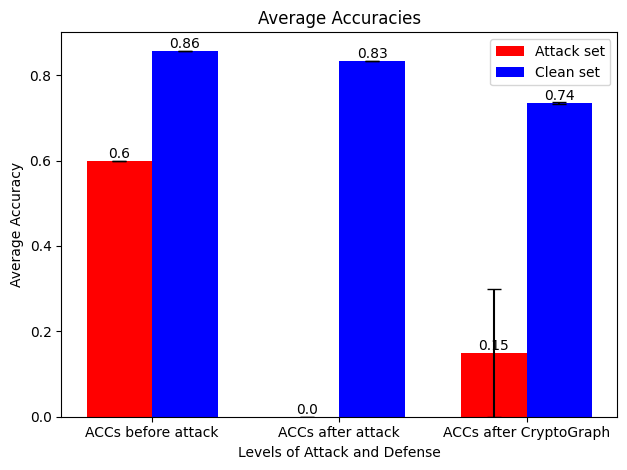

Loading polblogs dataset...
Final number of nodes with zero loss: 737
Final number of nodes with zero gradients: 690
Final number of nodes with zero loss but non-zero gradients: 47
Number of nodes with non-zero loss and non-zero gradients: 213
Nodes chosen for attack: [716, 1182, 207, 379, 681, 820, 1288, 585, 333, 125, 697, 528, 657, 49, 605, 138, 358, 133, 230, 233, 371, 262, 264, 70, 412, 456, 60, 93, 198, 107, 59, 284, 195, 173, 260, 463, 253, 227, 175, 632, 241, 259, 525, 335, 269, 429, 119, 342, 341, 551, 145, 368, 610, 246, 134, 664, 365, 723, 397, 194, 691, 747, 706, 318, 394, 385, 727, 231, 338, 581, 628, 545, 239, 696, 265, 301, 53, 196, 751, 329]
Test set results: loss= 0.3643 accuracy= 0.8547
Test set results: loss= 0.7504 accuracy= 0.0750
Test set results: loss= 0.3288 accuracy= 0.9264
Test accuracy on attack set:  0.075
Test accuracy on clean set:  0.9264367816091954
k = number of nodes to attack: 80
budget: 20 alpha(gradient's importance): 1.0 beta( commun neighbor's imp

C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (716, 854)
Gradient: 0.001010204665362835
Number of common neighbors: 0
Score: 0.001010204665362835
Score add: 1.0005091198254377
Score remove: 3.405185998417437e-05
Added edge: (716, 1100)
Gradient: 0.000509119825437665
Number of common neighbors: 1
Score: 1.0005091198254377
Score add: 2.00049211375881
Score remove: 3.405185998417437e-05
Added edge: (716, 879)
Gradient: 0.0004921137588098645
Number of common neighbors: 2
Score: 2.00049211375881
Score add: 3.000460938026663
Score remove: 3.405185998417437e-05
Added edge: (716, 1111)
Gradient: 0.00046093802666291595
Number of common neighbors: 3
Score: 3.000460938026663
Score add: 4.000440226285718
Score remove: 3.405185998417437e-05
Added edge: (716, 1040)
Gradient: 0.0004402262857183814
Number of common neighbors: 4
Score: 4.000440226285718
Score add: 5.000333914300427
Score remove: 3.405185998417437e-05
Added edge: (716, 965)
Gradient: 0.0003339143004268408
Number of common neighbors: 5
Score: 5.000333914300427
Score add:

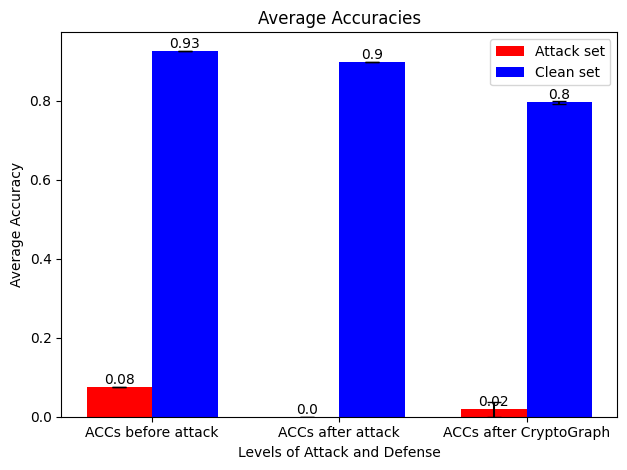

In [3]:
######## mahsa-V5 : attack on adj1 budget just pour une seule action (ajouter ou enlever) -  low loss low gradiant
# choose nodes to attack based on loss and gradients not common neighbors - min/max/moyen loss and gradients
# using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
# attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# choose nodes to attack based on loss and gradients not common neighbors
def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            # print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
    
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
    # print("Nodes with non-zero loss and non-zero gradients:")
    # for node in non_zero_loss_and_gradients_nodes:
    #     print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")
    # Sort nodes by impact score in descending order
    # non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
    # nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]

    # sort nodes by less loss and gradients
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    nodes_to_attack = [node for node, score in sorted_nodes[:k]]

    return nodes_to_attack


####### new strategy of adding alpha beta to the impact score to consider the common neighbors while selecting nodes to attack
####### not have good results all 0.1 accuracies.
# def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, alpha=1.0, beta=1.0):
#     zero_loss_count = 0
#     zero_gradients_count = 0
#     non_zero_loss_and_gradients_nodes = []
#     zero_loss_non_ziro_gr = 0

#     for target_node in idx_test:
#         loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
#         if loss == 0:
#             zero_loss_count += 1
#         if not np.any(gradients):
#             zero_gradients_count += 1
        
#         zero_loss = loss == 0
#         zero_gradients = not np.any(gradients)
#         if not zero_loss and not zero_gradients:
#             impact_score = loss * np.sum(np.abs(gradients))
#             common_neighbors = sum(calculate_common_neighbors(adj, target_node, i) for i in range(adj.shape[0]) if i != target_node)
#             final_score = alpha * impact_score + beta * common_neighbors
#             non_zero_loss_and_gradients_nodes.append((target_node, final_score))
        
#         if zero_loss and not zero_gradients:
#             zero_loss_non_ziro_gr += 1
    
#     print(f"Final number of nodes with zero loss: {zero_loss_count}")
#     print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
#     print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
#     print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

#     # Sort nodes by the final score in descending order
#     non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
#     nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]
#     return nodes_to_attack



# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
# it was calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add=True)
def calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add): 
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0   and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] * alpha + common_neighbors * beta  
            # Score for adding an edge: A higher gradient indicates a larger potential impact on the loss if the edge is added

        elif not add and adj[target_node, i] == 1  and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] * alpha + common_neighbors * beta
            # Score for removing an edge: A more negative gradient indicates a larger potential impact on the loss if the edge is removed
    return scores

# Select best edge based on edge scores
# it was select_best_edge(adj, gradients, target_node, labels, alpha, beta, add= True)
def select_best_edge(adj, gradients, target_node, labels, add, alpha, beta):  # add is a boolean 
    scores = calculate_edge_scores(adj, gradients, target_node, labels, alpha= alpha, beta= beta, add= add) ########################################just add?
    if not scores:
        return None
    if add:
        # For adding an edge: Choose the edge with the highest score (larger positive gradient = higher increase in loss)
        best_edge = max(scores, key=scores.get) 
    else:
        # For removing an edge: Choose the edge with the lowest score (more negative gradient = higher decrease in loss)
        # edge i remove she ke loss ro kheili kam mikone. mikhaym loss bala bashe. 
        best_edge = min(scores, key=scores.get) 
    return best_edge

# Perturb edges between target nodes with one action per budget
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    removed_edges = []  # Track removed edges
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
            
            if edge_add and edge_remove:
                # Compare scores and choose the best action
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta
                print(f"Score add: {score_add}")

                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta
                print(f"Score remove: {score_remove}")

                if score_add > score_remove:
                    # Perform add
                    attacked_adj[edge_add[0], edge_add[1]] = 1
                    attacked_adj[edge_add[1], edge_add[0]] = 1
                    added_edges.append(edge_add)  # Track added edge
                    edge_added_count += 1
                    print(f"Added edge: {edge_add}")
                    print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_add}")
                    print(f"Score: {score_add}")
                else:
                    # Perform remove
                    attacked_adj[edge_remove[0], edge_remove[1]] = 0
                    attacked_adj[edge_remove[1], edge_remove[0]] = 0
                    removed_edges.append(edge_remove)  # Track removed edge
                    edge_removed_count += 1
                    print(f"Removed edge: {edge_remove}")
                    print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_remove}")
                    print(f"Score: {score_remove}")
            
            elif edge_add:
                # If only add is possible
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
                print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                print(f"Number of common neighbors: {common_neighbors_add}")
                print(f"Score: {score_add}")
            
            elif edge_remove:
                # If only remove is possible
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                removed_edges.append(edge_remove)  # Track removed edge
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                print(f"Number of common neighbors: {common_neighbors_remove}")
                print(f"Score: {score_remove}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges, removed_edges  # Return added and removed edges for tracking





# # Perturb edges between target nodes -old one which adds and removes at the same time for each budget 
# def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
#     attacked_adj = adj.copy()
#     added_edges = []  # Track added edges
#     edge_added_count = 0
#     edge_removed_count = 0
#     for target_node in idx_test_attack:
#         print(f"Target node is: {target_node} with label: {labels[target_node]}")
#         loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
#         if not np.any(gradients):
#             continue
#         for _ in range(budget):
#             edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
#             edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
#             # print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
#             if edge_add:
#                 common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
#                 score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta  

#                 attacked_adj[edge_add[0], edge_add[1]] = 1
#                 attacked_adj[edge_add[1], edge_add[0]] = 1
#                 added_edges.append(edge_add)  # Track added edge
#                 edge_added_count += 1
#                 print(f"Added edge: {edge_add}")
#                 print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
#                 print(f"Number of common neighbors: {common_neighbors_add}")
#                 print(f"Score: {score_add}")

#             if edge_remove:
#                 common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
#                 score_remove = -gradients[edge_remove[0], edge_remove[1]] *alpha + common_neighbors_remove * beta
#                 attacked_adj[edge_remove[0], edge_remove[1]] = 0
#                 attacked_adj[edge_remove[1], edge_remove[0]] = 0
#                 edge_removed_count += 1
#                 print(f"Removed edge: {edge_remove}")
#                 print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
#                 print(f"Number of common neighbors: {common_neighbors_remove}")
#                 print(f"Score: {score_remove}")

#     print(f"Total number of edges added: {edge_added_count}") 
#     print(f"Total number of edges removed: {edge_removed_count}")      
#     return attacked_adj, added_edges  # Return added edges for tracking

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

k = 80 # budget in the meaning of Number of nodes to attack
nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
idx_test_attack = nodes_to_attack[:k]
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]
print("Nodes chosen for attack:", idx_test_attack)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 20 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 1.0
print(f"k = number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")

threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# # Function to find removed edges -------- for original adj  
# def find_removed_edges(original_adj, defended_adj1, defended_adj2):
#     removed_edges = []
#     original_adj = original_adj.toarray()
#     defended_adj1 = defended_adj1.toarray()
#     defended_adj2 = defended_adj2.toarray()
#     combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
#     for i in range(original_adj.shape[0]):
#         for j in range(i + 1, original_adj.shape[1]):
#             if original_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
#                 removed_edges.append((i, j))
#     return removed_edges

# # Find all removed edges
# removed_edges = find_removed_edges(adj, CG_defended_adj1, CG_defended_adj2)
# print(f"Total number of removed edges by CG: {len(removed_edges)}")

# # Check if any of the inserted edges during the attack were removed by CG
# removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
# print(f"Inserted edges removed by CG: {removed_inserted_edges}")
# print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")



# Function to find removed edges  - should compare adj after attack and cg 
def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
    removed_edges = []
    attacked_adj_1 = attacked_adj_1.toarray()
    adj2 = adj2.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(combined_attacked_adj.shape[0]):
        for j in range(i + 1, combined_attacked_adj.shape[1]):
            if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")

# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


Loading polblogs dataset...
Final number of nodes with zero loss: 737
Final number of nodes with zero gradients: 690
Final number of nodes with zero loss but non-zero gradients: 47
Number of nodes with non-zero loss and non-zero gradients: 213
Nodes chosen for attack: [1130, 275, 118, 489, 808, 1228, 1116, 1476, 1108, 499, 1215, 202, 1192, 1188, 79, 229, 215, 1098, 719, 623, 212, 522, 969, 1139, 695, 183, 473, 283, 324, 967]
Test set results: loss= 0.3643 accuracy= 0.8547
Test set results: loss= 1.1543 accuracy= 0.2000
Test set results: loss= 0.3385 accuracy= 0.8761
Test accuracy on attack set:  0.2
Test accuracy on clean set:  0.8760869565217392
k = number of nodes to attack: 30
budget: 5 alpha(gradient's importance): 1.0 beta( commun neighbor's importance): 1.0
Target node is: 1130 with label: 1
Added edge: (1130, 362)
Gradient: 292.62213134765625
Number of common neighbors: 29
Score: 321.62213134765625


C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (1130, 728)
Gradient: 274.1060791015625
Number of common neighbors: 26
Score: 300.1060791015625
Added edge: (1130, 453)
Gradient: 263.1453857421875
Number of common neighbors: 25
Score: 288.1453857421875
Added edge: (1130, 143)
Gradient: 263.0428161621094
Number of common neighbors: 24
Score: 287.0428161621094
Added edge: (1130, 492)
Gradient: 264.5259704589844
Number of common neighbors: 23
Score: 287.5259704589844
Target node is: 275 with label: 0
Score add: 376.40771484375
Score remove: -4.032000541687012
Added edge: (275, 854)
Gradient: 355.40771484375
Number of common neighbors: 21
Score: 376.40771484375
Score add: 198.38186645507812
Score remove: -4.032000541687012
Added edge: (275, 1152)
Gradient: 177.38186645507812
Number of common neighbors: 21
Score: 198.38186645507812
Score add: 193.11871337890625
Score remove: -4.032000541687012
Added edge: (275, 1100)
Gradient: 179.11871337890625
Number of common neighbors: 14
Score: 193.11871337890625
Score add: 191.5782165527

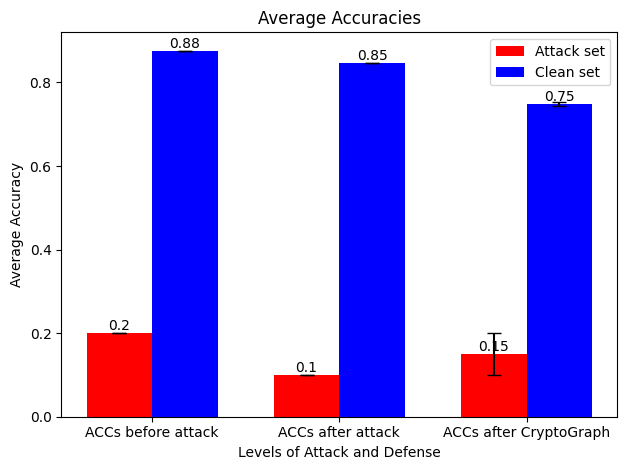

: 

In [5]:
######## mahsa-V5 : attack on adj1 and each bud just add or remove and now test for "high loss-gradiants".
# budget just pour une seule action (ajouter ou enlever) pour chaque node cible
# choose nodes to attack based on loss and gradients not common neighbors - min/max/moyen loss and gradients
# using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
# attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# choose nodes to attack based on loss and gradients not common neighbors
def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            # print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
    
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
    # print("Nodes with non-zero loss and non-zero gradients:")
    # for node in non_zero_loss_and_gradients_nodes:
    #     print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")
    # Sort nodes by impact score in descending order
    # non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
    # nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]

    # sort nodes by HIGH loss and gradients : reverse = true
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1], reverse=True)
    nodes_to_attack = [node for node, score in sorted_nodes[:k]]

    return nodes_to_attack


####### new strategy of adding alpha beta to the impact score to consider the common neighbors while selecting nodes to attack
####### not have good results all 0.1 accuracies.
# def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, alpha=1.0, beta=1.0):
#     zero_loss_count = 0
#     zero_gradients_count = 0
#     non_zero_loss_and_gradients_nodes = []
#     zero_loss_non_ziro_gr = 0

#     for target_node in idx_test:
#         loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
#         if loss == 0:
#             zero_loss_count += 1
#         if not np.any(gradients):
#             zero_gradients_count += 1
        
#         zero_loss = loss == 0
#         zero_gradients = not np.any(gradients)
#         if not zero_loss and not zero_gradients:
#             impact_score = loss * np.sum(np.abs(gradients))
#             common_neighbors = sum(calculate_common_neighbors(adj, target_node, i) for i in range(adj.shape[0]) if i != target_node)
#             final_score = alpha * impact_score + beta * common_neighbors
#             non_zero_loss_and_gradients_nodes.append((target_node, final_score))
        
#         if zero_loss and not zero_gradients:
#             zero_loss_non_ziro_gr += 1
    
#     print(f"Final number of nodes with zero loss: {zero_loss_count}")
#     print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
#     print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
#     print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

#     # Sort nodes by the final score in descending order
#     non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
#     nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]
#     return nodes_to_attack



# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
# it was calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add=True)
def calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add): 
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0   and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] * alpha + common_neighbors * beta  
            # Score for adding an edge: A higher gradient indicates a larger potential impact on the loss if the edge is added

        elif not add and adj[target_node, i] == 1  and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] * alpha + common_neighbors * beta
            # Score for removing an edge: A more negative gradient indicates a larger potential impact on the loss if the edge is removed
    return scores

# Select best edge based on edge scores
# it was select_best_edge(adj, gradients, target_node, labels, alpha, beta, add= True)
def select_best_edge(adj, gradients, target_node, labels, add, alpha, beta):  # add is a boolean 
    scores = calculate_edge_scores(adj, gradients, target_node, labels, alpha= alpha, beta= beta, add= add) ########################################just add?
    if not scores:
        return None
    if add:
        # For adding an edge: Choose the edge with the highest score (larger positive gradient = higher increase in loss)
        best_edge = max(scores, key=scores.get) 
    else:
        # For removing an edge: Choose the edge with the lowest score (more negative gradient = higher decrease in loss)
        # edge i remove she ke loss ro kheili kam mikone. mikhaym loss bala bashe. 
        best_edge = min(scores, key=scores.get) 
    return best_edge


# Perturb edges between target nodes with one action per budget
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    removed_edges = []  # Track removed edges
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
            
            if edge_add and edge_remove:
                # Compare scores and choose the best action
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta
                print(f"Score add: {score_add}")

                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta
                print(f"Score remove: {score_remove}")

                if score_add > score_remove:
                    # Perform add
                    attacked_adj[edge_add[0], edge_add[1]] = 1
                    attacked_adj[edge_add[1], edge_add[0]] = 1
                    added_edges.append(edge_add)  # Track added edge
                    edge_added_count += 1
                    print(f"Added edge: {edge_add}")
                    print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_add}")
                    print(f"Score: {score_add}")
                else:
                    # Perform remove
                    common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                    attacked_adj[edge_remove[0], edge_remove[1]] = 0
                    attacked_adj[edge_remove[1], edge_remove[0]] = 0
                    removed_edges.append(edge_remove)  # Track removed edge
                    edge_removed_count += 1
                    print(f"Removed edge: {edge_remove}")
                    print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_remove}")
                    print(f"Score: {score_remove}")
            
            elif edge_add:
                # If only add is possible
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
                print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                print(f"Number of common neighbors: {common_neighbors_add}")
                print(f"Score: {score_add}")
            
            elif edge_remove:
                # If only remove is possible
                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                removed_edges.append(edge_remove)  # Track removed edge
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                print(f"Number of common neighbors: {common_neighbors_remove}")
                print(f"Score: {score_remove}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges, removed_edges  # Return added and removed edges for tracking


# # WORKS FINE for low loss but error for high loss : Perturb edges between target nodes with one action per budget
# def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
#     attacked_adj = adj.copy()
#     added_edges = []  # Track added edges
#     removed_edges = []  # Track removed edges
#     edge_added_count = 0
#     edge_removed_count = 0

#     for target_node in idx_test_attack:
#         print(f"Target node is: {target_node} with label: {labels[target_node]}")
#         loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
#         if not np.any(gradients):
#             continue
#         for _ in range(budget):
#             edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
#             edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
            
#             if edge_add and edge_remove:
#                 # Compare scores and choose the best action
#                 common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
#                 score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta
#                 print(f"Score add: {score_add}")

#                 common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
#                 score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta
#                 print(f"Score remove: {score_remove}")

#                 if score_add > score_remove:
#                     # Perform add
#                     attacked_adj[edge_add[0], edge_add[1]] = 1
#                     attacked_adj[edge_add[1], edge_add[0]] = 1
#                     added_edges.append(edge_add)  # Track added edge
#                     edge_added_count += 1
#                     print(f"Added edge: {edge_add}")
#                     print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
#                     print(f"Number of common neighbors: {common_neighbors_add}")
#                     print(f"Score: {score_add}")
#                 else:
#                     # Perform remove
#                     attacked_adj[edge_remove[0], edge_remove[1]] = 0
#                     attacked_adj[edge_remove[1], edge_remove[0]] = 0
#                     removed_edges.append(edge_remove)  # Track removed edge
#                     edge_removed_count += 1
#                     print(f"Removed edge: {edge_remove}")
#                     print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
#                     print(f"Number of common neighbors: {common_neighbors_remove}")
#                     print(f"Score: {score_remove}")
            
#             elif edge_add:
#                 # If only add is possible
#                 attacked_adj[edge_add[0], edge_add[1]] = 1
#                 attacked_adj[edge_add[1], edge_add[0]] = 1
#                 added_edges.append(edge_add)  # Track added edge
#                 edge_added_count += 1
#                 print(f"Added edge: {edge_add}")
#                 print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
#                 print(f"Number of common neighbors: {common_neighbors_add}")
#                 print(f"Score: {score_add}")
            
#             elif edge_remove:
#                 # If only remove is possible
#                 attacked_adj[edge_remove[0], edge_remove[1]] = 0
#                 attacked_adj[edge_remove[1], edge_remove[0]] = 0
#                 removed_edges.append(edge_remove)  # Track removed edge
#                 edge_removed_count += 1
#                 print(f"Removed edge: {edge_remove}")
#                 print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
#                 print(f"Number of common neighbors: {common_neighbors_remove}")
#                 print(f"Score: {score_remove}")

#     print(f"Total number of edges added: {edge_added_count}") 
#     print(f"Total number of edges removed: {edge_removed_count}")      
#     return attacked_adj, added_edges, removed_edges  # Return added and removed edges for tracking





# # Perturb edges between target nodes -old one which adds and removes at the same time for each budget 
# def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
#     attacked_adj = adj.copy()
#     added_edges = []  # Track added edges
#     edge_added_count = 0
#     edge_removed_count = 0
#     for target_node in idx_test_attack:
#         print(f"Target node is: {target_node} with label: {labels[target_node]}")
#         loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
#         if not np.any(gradients):
#             continue
#         for _ in range(budget):
#             edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
#             edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
#             # print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
#             if edge_add:
#                 common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
#                 score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta  

#                 attacked_adj[edge_add[0], edge_add[1]] = 1
#                 attacked_adj[edge_add[1], edge_add[0]] = 1
#                 added_edges.append(edge_add)  # Track added edge
#                 edge_added_count += 1
#                 print(f"Added edge: {edge_add}")
#                 print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
#                 print(f"Number of common neighbors: {common_neighbors_add}")
#                 print(f"Score: {score_add}")

#             if edge_remove:
#                 common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
#                 score_remove = -gradients[edge_remove[0], edge_remove[1]] *alpha + common_neighbors_remove * beta
#                 attacked_adj[edge_remove[0], edge_remove[1]] = 0
#                 attacked_adj[edge_remove[1], edge_remove[0]] = 0
#                 edge_removed_count += 1
#                 print(f"Removed edge: {edge_remove}")
#                 print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
#                 print(f"Number of common neighbors: {common_neighbors_remove}")
#                 print(f"Score: {score_remove}")

#     print(f"Total number of edges added: {edge_added_count}") 
#     print(f"Total number of edges removed: {edge_removed_count}")      
#     return attacked_adj, added_edges  # Return added edges for tracking

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

k = 30 # budget in the meaning of Number of nodes to attack
nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
idx_test_attack = nodes_to_attack[:k]
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]
print("Nodes chosen for attack:", idx_test_attack)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 5 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 1.0
print(f"k = number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")

threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Function to find removed edges  - should compare adj after attack and cg 
def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
    removed_edges = []
    attacked_adj_1 = attacked_adj_1.toarray()
    adj2 = adj2.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(combined_attacked_adj.shape[0]):
        for j in range(i + 1, combined_attacked_adj.shape[1]):
            if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")

# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [ ]:
######## mahsa-V5-1 test1 ok : attack on adj1 - number of nodes on low/high/medium loss and gradients - or just one node specific??
# budget just pour une seule action (ajouter ou enlever) pour chaque node cible
# choose nodes to attack based on loss and gradients not common neighbors - min/max/moyen loss and gradients
#  using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
#  attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# choose nodes to attack based on loss and gradients not common neighbors and min/max/moyen loss and gradients or just one node
def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count=0, min_count=0, moyen_count=0, manual_nodes=None):
    if manual_nodes is not None and len(manual_nodes) > 0:
        # If manual nodes are provided, use them
        print("Using manually selected nodes.")
        return manual_nodes, [], []

    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            zero_loss_non_ziro_gr += 1
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")
    
    # Sort nodes by impact score
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    # Selecting the top nodes with maximum loss and gradient
    max_nodes = sorted_nodes[-max_count:] if max_count > 0 else []
    # Selecting the bottom nodes with minimum loss and gradient
    min_nodes = sorted_nodes[:min_count] if min_count > 0 else []
    # Selecting nodes with median (moyen) loss and gradient
    median_index = len(sorted_nodes) // 2
    moyen_nodes = sorted_nodes[max(0, median_index - moyen_count//2): min(len(sorted_nodes), median_index + moyen_count//2)] if moyen_count > 0 else []

    return max_nodes, min_nodes, moyen_nodes




# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
# it was calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add=True)
def calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add): 
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0   and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] * alpha + common_neighbors * beta  
            # Score for adding an edge: A higher gradient indicates a larger potential impact on the loss if the edge is added

        elif not add and adj[target_node, i] == 1  and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] * alpha + common_neighbors * beta
            # Score for removing an edge: A more negative gradient indicates a larger potential impact on the loss if the edge is removed
    return scores

# Select best edge based on edge scores
# it was select_best_edge(adj, gradients, target_node, labels, alpha, beta, add= True)
def select_best_edge(adj, gradients, target_node, labels, add, alpha, beta):  # add is a boolean 
    scores = calculate_edge_scores(adj, gradients, target_node, labels, alpha= alpha, beta= beta, add= add) ########################################just add?
    if not scores:
        return None
    if add:
        # For adding an edge: Choose the edge with the highest score (larger positive gradient = higher increase in loss)
        best_edge = max(scores, key=scores.get) 
    else:
        # For removing an edge: Choose the edge with the lowest score (more negative gradient = higher decrease in loss)
        # edge i remove she ke loss ro kheili kam mikone. mikhaym loss bala bashe. 
        best_edge = min(scores, key=scores.get) 
    return best_edge

# Perturb edges between target nodes with one action per budget
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    removed_edges = []  # Track removed edges
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
            
            if edge_add and edge_remove:
                # Compare scores and choose the best action
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta
                print(f"Score add: {score_add}")

                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta
                print(f"Score remove: {score_remove}")

                if score_add > score_remove:
                    # Perform add
                    attacked_adj[edge_add[0], edge_add[1]] = 1
                    attacked_adj[edge_add[1], edge_add[0]] = 1
                    added_edges.append(edge_add)  # Track added edge
                    edge_added_count += 1
                    print(f"Added edge: {edge_add}")
                    print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_add}")
                    print(f"Score: {score_add}")
                else:
                    # Perform remove
                    attacked_adj[edge_remove[0], edge_remove[1]] = 0
                    attacked_adj[edge_remove[1], edge_remove[0]] = 0
                    removed_edges.append(edge_remove)  # Track removed edge
                    edge_removed_count += 1
                    print(f"Removed edge: {edge_remove}")
                    print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_remove}")
                    print(f"Score: {score_remove}")
            
            elif edge_add:
                # If only add is possible
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
                print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                print(f"Number of common neighbors: {common_neighbors_add}")
                print(f"Score: {score_add}")
            
            elif edge_remove:
                # If only remove is possible
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                removed_edges.append(edge_remove)  # Track removed edge
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                print(f"Number of common neighbors: {common_neighbors_remove}")
                print(f"Score: {score_remove}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges, removed_edges  # Return added and removed edges for tracking


# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# k = 10 # budget in the meaning of Number of nodes to attack
# nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
max_count = 2    # Number of nodes with maximum loss and gradients
min_count = 2    # Number of nodes with minimum loss and gradients
moyen_count = 2  # Number of nodes with median (moyen) loss and gradients
manual_nodes = [275, 1130, 716, 1182, 213, 121]  # List of nodes to attack manually
max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count, min_count, moyen_count)
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, manual_nodes=manual_nodes)

# Combine all selected nodes into one list for attack
nodes_to_attack = [node for node, _ in max_nodes + min_nodes + moyen_nodes]
idx_test_attack = nodes_to_attack
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]

print("Nodes chosen for attack:", idx_test_attack)
print("Nodes that are clean:", idx_test_clean)

########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 5 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 1.0
print(f" number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")

threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Function to find removed edges  - should compare adj after attack and cg 
def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
    removed_edges = []
    attacked_adj_1 = attacked_adj_1.toarray()
    adj2 = adj2.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(combined_attacked_adj.shape[0]):
        for j in range(i + 1, combined_attacked_adj.shape[1]):
            if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")


# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [ ]:
######## mahsa-V5-1 -test 2:working not to choose zero scores.ok  attack on adj1 - number of nodes on low/high/medium loss and gradients - or just one node specific??
# budget just pour une seule action (ajouter ou enlever) pour chaque node cible
# choose nodes to attack based on loss and gradients not common neighbors - min/max/moyen loss and gradients
#  using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
#  attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients


def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count=0, min_count=0, moyen_count=0, manual_nodes=None):
    if manual_nodes is not None and len(manual_nodes) > 0:
        print("Using manually selected nodes.")
        return [(node, 0, 0, 0) for node in manual_nodes]  # Dummy values for score, loss, gradient sum

    non_zero_loss_and_gradients_nodes = []

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        # Filter based on zero loss or negligible gradient values
        gradient_sum = np.sum(np.abs(gradients))
        if loss < 1e-5 or gradient_sum < 1e-12:  # Using a small threshold to account for numerical precision issues
            print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
            continue

        impact_score = loss * gradient_sum
        non_zero_loss_and_gradients_nodes.append((target_node, impact_score, loss, gradient_sum))

    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    # Selecting the top nodes with maximum loss and gradient
    max_nodes = sorted_nodes[-max_count:] if max_count > 0 else []
    # Selecting the bottom nodes with minimum loss and gradient
    min_nodes = sorted_nodes[:min_count] if min_count > 0 else []
    # Selecting nodes with median (moyen) loss and gradient
    median_index = len(sorted_nodes) // 2
    moyen_nodes = sorted_nodes[max(0, median_index - moyen_count//2): min(len(sorted_nodes), median_index + moyen_count//2)] if moyen_count > 0 else []

    return max_nodes, min_nodes, moyen_nodes


# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
# it was calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add=True)
def calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add): 
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0   and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] * alpha + common_neighbors * beta  
            # Score for adding an edge: A higher gradient indicates a larger potential impact on the loss if the edge is added

        elif not add and adj[target_node, i] == 1  and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] * alpha + common_neighbors * beta
            # Score for removing an edge: A more negative gradient indicates a larger potential impact on the loss if the edge is removed
    return scores

# Select best edge based on edge scores
# it was select_best_edge(adj, gradients, target_node, labels, alpha, beta, add= True)
def select_best_edge(adj, gradients, target_node, labels, add, alpha, beta):  # add is a boolean 
    scores = calculate_edge_scores(adj, gradients, target_node, labels, alpha= alpha, beta= beta, add= add) ########################################just add?
    if not scores:
        return None
    if add:
        # For adding an edge: Choose the edge with the highest score (larger positive gradient = higher increase in loss)
        best_edge = max(scores, key=scores.get) 
    else:
        # For removing an edge: Choose the edge with the lowest score (more negative gradient = higher decrease in loss)
        # edge i remove she ke loss ro kheili kam mikone. mikhaym loss bala bashe. 
        best_edge = min(scores, key=scores.get) 
    return best_edge

# Perturb edges between target nodes with one action per budget
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    removed_edges = []  # Track removed edges
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
            
            if edge_add and edge_remove:
                # Compare scores and choose the best action
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta
                print(f"Score add: {score_add}")

                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta
                print(f"Score remove: {score_remove}")

                if score_add > score_remove:
                    # Perform add
                    attacked_adj[edge_add[0], edge_add[1]] = 1
                    attacked_adj[edge_add[1], edge_add[0]] = 1
                    added_edges.append(edge_add)  # Track added edge
                    edge_added_count += 1
                    print(f"Added edge: {edge_add}")
                    print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_add}")
                    print(f"Score: {score_add}")
                else:
                    # Perform remove
                    attacked_adj[edge_remove[0], edge_remove[1]] = 0
                    attacked_adj[edge_remove[1], edge_remove[0]] = 0
                    removed_edges.append(edge_remove)  # Track removed edge
                    edge_removed_count += 1
                    print(f"Removed edge: {edge_remove}")
                    print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_remove}")
                    print(f"Score: {score_remove}")
            
            elif edge_add:
                # If only add is possible
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
                print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                print(f"Number of common neighbors: {common_neighbors_add}")
                print(f"Score: {score_add}")
            
            elif edge_remove:
                # If only remove is possible
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                removed_edges.append(edge_remove)  # Track removed edge
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                print(f"Number of common neighbors: {common_neighbors_remove}")
                print(f"Score: {score_remove}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges, removed_edges  # Return added and removed edges for tracking


# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# k = 10 # budget in the meaning of Number of nodes to attack
# nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
max_count = 2    # Number of nodes with maximum loss and gradients
min_count = 2    # Number of nodes with minimum loss and gradients
moyen_count = 2  # Number of nodes with median (moyen) loss and gradients
manual_nodes = [275, 1130, 716, 1182, 213, 121]  # List of nodes to attack manually
max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count, min_count, moyen_count)
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, manual_nodes=manual_nodes)

print("Contents of max_nodes:", max_nodes)
print("Contents of min_nodes:", min_nodes)
print("Contents of moyen_nodes:", moyen_nodes)

# Combine into nodes_to_attack
nodes_to_attack = max_nodes + min_nodes + moyen_nodes
print("Contents of nodes_to_attack:", nodes_to_attack)

# Print out node information
print("Nodes chosen for attack:")
for node_info in nodes_to_attack:
    if isinstance(node_info, tuple):
        node, score, loss, gradient_sum = node_info
        print(f"Node: {node}, Total Score: {score:.4f}, Loss: {loss:.4f}, Gradient Sum: {gradient_sum:.4f}")
    else:
        print(f"Unexpected format: {node_info} (type: {type(node_info)})")


# Extract only the node IDs from nodes_to_attack
nodes_to_attack_ids = [node_info[0] for node_info in nodes_to_attack if isinstance(node_info, tuple)]
idx_test_attack = nodes_to_attack_ids
# Identify clean nodes
idx_test_clean = [node for node in idx_test if node not in nodes_to_attack_ids]

print("Nodes chosen for attack:", nodes_to_attack_ids)
print("Nodes that are clean:", idx_test_clean)

print("Nodes chosen for attack:", idx_test_attack)
print("Nodes that are clean:", idx_test_clean)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 3 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 1.0
print(f" number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")

threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Function to find removed edges  - should compare adj after attack and cg 
def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
    removed_edges = []
    attacked_adj_1 = attacked_adj_1.toarray()
    adj2 = adj2.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(combined_attacked_adj.shape[0]):
        for j in range(i + 1, combined_attacked_adj.shape[1]):
            if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")


# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


Loading polblogs dataset...
Skipping node 1395 due to zero loss or negligible gradients.
Skipping node 35 due to zero loss or negligible gradients.
Skipping node 754 due to zero loss or negligible gradients.
Skipping node 1169 due to zero loss or negligible gradients.
Skipping node 362 due to zero loss or negligible gradients.
Skipping node 1183 due to zero loss or negligible gradients.
Skipping node 597 due to zero loss or negligible gradients.
Skipping node 255 due to zero loss or negligible gradients.
Skipping node 1036 due to zero loss or negligible gradients.
Skipping node 1008 due to zero loss or negligible gradients.
Skipping node 1046 due to zero loss or negligible gradients.
Skipping node 146 due to zero loss or negligible gradients.
Skipping node 1486 due to zero loss or negligible gradients.
Skipping node 1057 due to zero loss or negligible gradients.
Skipping node 1403 due to zero loss or negligible gradients.
Skipping node 85 due to zero loss or negligible gradients.
Skipp

C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Score add: 185.11871337890625
Score remove: -6.397019386291504
Added edge: (499, 1100)
Gradient: 179.11871337890625
Number of common neighbors: 6
Score: 185.11871337890625
Score add: 183.38186645507812
Score remove: -5.397019386291504
Added edge: (499, 1152)
Gradient: 177.38186645507812
Number of common neighbors: 6
Score: 183.38186645507812
Score add: 181.57821655273438
Score remove: -5.397019386291504
Added edge: (499, 999)
Gradient: 178.57821655273438
Number of common neighbors: 3
Score: 181.57821655273438
Score add: 170.17086791992188
Score remove: -5.397019386291504
Added edge: (499, 1111)
Gradient: 162.17086791992188
Number of common neighbors: 8
Score: 170.17086791992188
Score add: 163.88308715820312
Score remove: -5.397019386291504
Added edge: (499, 1040)
Gradient: 154.88308715820312
Number of common neighbors: 9
Score: 163.88308715820312
Score add: 160.14926147460938
Score remove: -5.397019386291504
Added edge: (499, 1383)
Gradient: 152.14926147460938
Number of common neighbor

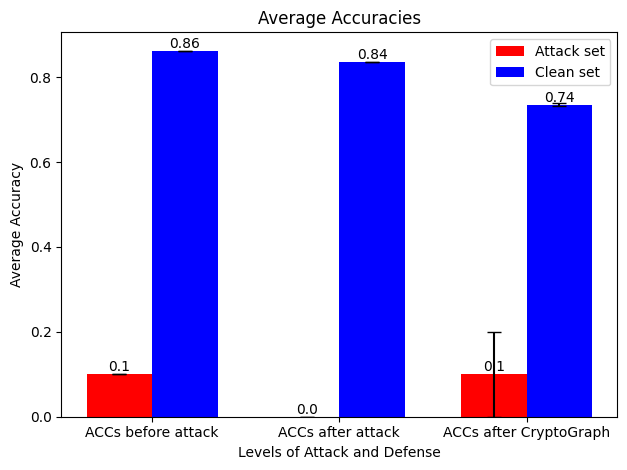

In [13]:
######## mahsa-V5-1 -test 3:working on moyen loss and gradients- selection- number of low/high/medium loss and gradients 
# difference by test2  is here: #  test3:  sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: (x[1], x[2]))  # Sort by impact score, then by loss

# working not to choose zero scores.ok  attack on adj1 - number of nodes on low/high/medium loss and gradients - or just one node specific??
# budget just pour une seule action (ajouter ou enlever) pour chaque node cible
# choose nodes to attack based on loss and gradients not common neighbors - min/max/moyen loss and gradients
#  using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
#  attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients


def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count=0, min_count=0, moyen_count=0, manual_nodes=None):
    if manual_nodes is not None and len(manual_nodes) > 0:
        print("Using manually selected nodes.")
        return [(node, 0, 0, 0) for node in manual_nodes]  # Dummy values for score, loss, gradient sum

    non_zero_loss_and_gradients_nodes = []

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        # Filter based on zero loss or negligible gradient values
        gradient_sum = np.sum(np.abs(gradients))
        if loss < 1e-5 or gradient_sum < 1e-12:  # Using a small threshold to account for numerical precision issues
            print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
            continue

        impact_score = loss * gradient_sum
        non_zero_loss_and_gradients_nodes.append((target_node, impact_score, loss, gradient_sum))

    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score
    # sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: (x[1], x[2]))  # Sort by impact score, then by loss



    # Selecting the top nodes with maximum loss and gradient
    max_nodes = sorted_nodes[-max_count:] if max_count > 0 else []
    # Selecting the bottom nodes with minimum loss and gradient
    min_nodes = sorted_nodes[:min_count] if min_count > 0 else []
    # Selecting nodes with median (moyen) loss and gradient
    median_index = len(sorted_nodes) // 2
    moyen_nodes = sorted_nodes[max(0, median_index - moyen_count//2): min(len(sorted_nodes), median_index + moyen_count//2)] if moyen_count > 0 else []

    return max_nodes, min_nodes, moyen_nodes


# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
# it was calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add=True)
def calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add): 
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0   and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] * alpha + common_neighbors * beta  
            # Score for adding an edge: A higher gradient indicates a larger potential impact on the loss if the edge is added

        elif not add and adj[target_node, i] == 1  and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] * alpha + common_neighbors * beta
            # Score for removing an edge: A more negative gradient indicates a larger potential impact on the loss if the edge is removed
    return scores

# Select best edge based on edge scores
# it was select_best_edge(adj, gradients, target_node, labels, alpha, beta, add= True)
def select_best_edge(adj, gradients, target_node, labels, add, alpha, beta):  # add is a boolean 
    scores = calculate_edge_scores(adj, gradients, target_node, labels, alpha= alpha, beta= beta, add= add) ########################################just add?
    if not scores:
        return None
    if add:
        # For adding an edge: Choose the edge with the highest score (larger positive gradient = higher increase in loss)
        best_edge = max(scores, key=scores.get) 
    else:
        # For removing an edge: Choose the edge with the lowest score (more negative gradient = higher decrease in loss)
        # edge i remove she ke loss ro kheili kam mikone. mikhaym loss bala bashe. 
        best_edge = min(scores, key=scores.get) 
    return best_edge

# Perturb edges between target nodes with one action per budget
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    removed_edges = []  # Track removed edges
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
            
            if edge_add and edge_remove:
                # Compare scores and choose the best action
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta
                print(f"Score add: {score_add}")

                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta
                print(f"Score remove: {score_remove}")

                if score_add > score_remove:
                    # Perform add
                    attacked_adj[edge_add[0], edge_add[1]] = 1
                    attacked_adj[edge_add[1], edge_add[0]] = 1
                    added_edges.append(edge_add)  # Track added edge
                    edge_added_count += 1
                    print(f"Added edge: {edge_add}")
                    print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_add}")
                    print(f"Score: {score_add}")
                else:
                    # Perform remove
                    attacked_adj[edge_remove[0], edge_remove[1]] = 0
                    attacked_adj[edge_remove[1], edge_remove[0]] = 0
                    removed_edges.append(edge_remove)  # Track removed edge
                    edge_removed_count += 1
                    print(f"Removed edge: {edge_remove}")
                    print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_remove}")
                    print(f"Score: {score_remove}")
            
            elif edge_add:
                # If only add is possible
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
                print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                print(f"Number of common neighbors: {common_neighbors_add}")
                print(f"Score: {score_add}")
            
            elif edge_remove:
                # If only remove is possible
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                removed_edges.append(edge_remove)  # Track removed edge
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                print(f"Number of common neighbors: {common_neighbors_remove}")
                print(f"Score: {score_remove}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges, removed_edges  # Return added and removed edges for tracking


# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# k = 10 # budget in the meaning of Number of nodes to attack
# nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
max_count = 10    # Number of nodes with maximum loss and gradients
min_count = 0    # Number of nodes with minimum loss and gradients
moyen_count = 0  # Number of nodes with median (moyen) loss and gradients
manual_nodes = [275, 1130, 716, 1182, 213, 121]  # List of nodes to attack manually
max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count, min_count, moyen_count)
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, manual_nodes=manual_nodes)

print("Contents of max_nodes:", max_nodes)
print("Contents of min_nodes:", min_nodes)
print("Contents of moyen_nodes:", moyen_nodes)

# Combine into nodes_to_attack
nodes_to_attack = max_nodes + min_nodes + moyen_nodes
print("Contents of nodes_to_attack:", nodes_to_attack)

# Print out node information
print("Nodes chosen for attack:")
for node_info in nodes_to_attack:
    if isinstance(node_info, tuple):
        node, score, loss, gradient_sum = node_info
        print(f"Node: {node}, Total Score: {score:.4f}, Loss: {loss:.4f}, Gradient Sum: {gradient_sum:.4f}")
    else:
        print(f"Unexpected format: {node_info} (type: {type(node_info)})")


# Extract only the node IDs from nodes_to_attack
nodes_to_attack_ids = [node_info[0] for node_info in nodes_to_attack if isinstance(node_info, tuple)]
idx_test_attack = nodes_to_attack_ids
# Identify clean nodes
idx_test_clean = [node for node in idx_test if node not in nodes_to_attack_ids]

print("Nodes chosen for attack:", nodes_to_attack_ids)
print("Nodes that are clean:", idx_test_clean)

print("Nodes chosen for attack:", idx_test_attack)
print("Nodes that are clean:", idx_test_clean)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 10 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 1.0
print(f" number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")

threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Function to find removed edges
# Function to find removed edges  - should compare adj after attack and cg 
def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
    removed_edges = []
    attacked_adj_1 = attacked_adj_1.toarray()
    adj2 = adj2.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(combined_attacked_adj.shape[0]):
        for j in range(i + 1, combined_attacked_adj.shape[1]):
            if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")


# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [ ]:
######## mahsa-V6-1 : exhaustive analysis on all nodes to analyse the impact of each node on the model
# working on moyen loss and gradients- selection
# working not to choose zero scores.ok  attack on adj1 - number of nodes on low/high/medium loss and gradients - or just one node specific??
# budget just pour une seule action (ajouter ou enlever) pour chaque node cible
# choose nodes to attack based on loss and gradients not common neighbors - min/max/moyen loss and gradients
#  using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
#  attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients


def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count=0, min_count=0, moyen_count=0, manual_nodes=None):
    if manual_nodes is not None and len(manual_nodes) > 0:
        print("Using manually selected nodes.")
        return [(node, 0, 0, 0) for node in manual_nodes]  # Dummy values for score, loss, gradient sum

    non_zero_loss_and_gradients_nodes = []

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        # Filter based on zero loss or negligible gradient values
        gradient_sum = np.sum(np.abs(gradients))
        if loss < 1e-5 or gradient_sum < 1e-12:  # Using a small threshold to account for numerical precision issues
            print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
            continue

        impact_score = loss * gradient_sum
        non_zero_loss_and_gradients_nodes.append((target_node, impact_score, loss, gradient_sum))

    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")
    # Sort nodes by impact score
    # sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: (x[1], x[2]))  # Sort by impact score, then by loss

    # Selecting the top nodes with maximum loss and gradient
    max_nodes = sorted_nodes[-max_count:] if max_count > 0 else []
    # Selecting the bottom nodes with minimum loss and gradient
    min_nodes = sorted_nodes[:min_count] if min_count > 0 else []
    # Selecting nodes with median (moyen) loss and gradient
    median_index = len(sorted_nodes) // 2
    moyen_nodes = sorted_nodes[max(0, median_index - moyen_count//2): min(len(sorted_nodes), median_index + moyen_count//2)] if moyen_count > 0 else []

    return max_nodes, min_nodes, moyen_nodes


# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
# it was calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add=True)
def calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add): 
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0   and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] * alpha + common_neighbors * beta  
            # Score for adding an edge: A higher gradient indicates a larger potential impact on the loss if the edge is added

        elif not add and adj[target_node, i] == 1  and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] * alpha + common_neighbors * beta
            # Score for removing an edge: A more negative gradient indicates a larger potential impact on the loss if the edge is removed
    return scores

# Select best edge based on edge scores
# it was select_best_edge(adj, gradients, target_node, labels, alpha, beta, add= True)
def select_best_edge(adj, gradients, target_node, labels, add, alpha, beta):  # add is a boolean 
    scores = calculate_edge_scores(adj, gradients, target_node, labels, alpha= alpha, beta= beta, add= add) ########################################just add?
    if not scores:
        return None
    if add:
        # For adding an edge: Choose the edge with the highest score (larger positive gradient = higher increase in loss)
        best_edge = max(scores, key=scores.get) 
    else:
        # For removing an edge: Choose the edge with the lowest score (more negative gradient = higher decrease in loss)
        # edge i remove she ke loss ro kheili kam mikone. mikhaym loss bala bashe. 
        best_edge = min(scores, key=scores.get) 
    return best_edge

# Perturb edges between target nodes with one action per budget
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    removed_edges = []  # Track removed edges
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
            
            if edge_add and edge_remove:
                # Compare scores and choose the best action
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta
                print(f"Score add: {score_add}")

                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta
                print(f"Score remove: {score_remove}")

                if score_add > score_remove:
                    # Perform add
                    attacked_adj[edge_add[0], edge_add[1]] = 1
                    attacked_adj[edge_add[1], edge_add[0]] = 1
                    added_edges.append(edge_add)  # Track added edge
                    edge_added_count += 1
                    print(f"Added edge: {edge_add}")
                    print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_add}")
                    print(f"Score: {score_add}")
                else:
                    # Perform remove
                    common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])  # <-- This line was added

                    attacked_adj[edge_remove[0], edge_remove[1]] = 0
                    attacked_adj[edge_remove[1], edge_remove[0]] = 0
                    removed_edges.append(edge_remove)  # Track removed edge
                    edge_removed_count += 1
                    print(f"Removed edge: {edge_remove}")
                    print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_remove}")
                    print(f"Score: {score_remove}")
            
            elif edge_add:
                # If only add is possible
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])  # <-- This line was added
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta  # <-- Assigning score_add here

                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
                print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                print(f"Number of common neighbors: {common_neighbors_add}")
                print(f"Score: {score_add}")
            
            elif edge_remove:
                # If only remove is possible
                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])  # <-- This line was added
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta  # <-- Assigning score_remove here

                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                removed_edges.append(edge_remove)  # Track removed edge
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                print(f"Number of common neighbors: {common_neighbors_remove}")
                print(f"Score: {score_remove}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges, removed_edges  # Return added and removed edges for tracking


# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# k = 10 # budget in the meaning of Number of nodes to attack
# nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
# max_count = 4    # Number of nodes with maximum loss and gradients
# min_count = 4    # Number of nodes with minimum loss and gradients
# moyen_count = 10  # Number of nodes with median (moyen) loss and gradients
# manual_nodes = [275, 1130, 716, 1182, 213, 121]  # List of nodes to attack manually
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count, min_count, moyen_count)
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, manual_nodes=manual_nodes)

# print("Contents of max_nodes:", max_nodes)
# print("Contents of min_nodes:", min_nodes)
# print("Contents of moyen_nodes:", moyen_nodes)

# Combine into nodes_to_attack
# nodes_to_attack = max_nodes + min_nodes + moyen_nodes
# print("Contents of nodes_to_attack:", nodes_to_attack)
# # Print out node information
# print("Nodes chosen for attack:")

# for node_info in nodes_to_attack:
#     if isinstance(node_info, tuple):
#         node, score, loss, gradient_sum = node_info
#         print(f"Node: {node}, Total Score: {score:.4f}, Loss: {loss:.4f}, Gradient Sum: {gradient_sum:.4f}")
#     else:
#         print(f"Unexpected format: {node_info} (type: {type(node_info)})")


# Extract only the node IDs from nodes_to_attack
# nodes_to_attack_ids = [node_info[0] for node_info in nodes_to_attack if isinstance(node_info, tuple)]
# idx_test_attack = nodes_to_attack_ids
# # Identify clean nodes
# idx_test_clean = [node for node in idx_test if node not in nodes_to_attack_ids]

# print("Nodes chosen for attack:", nodes_to_attack_ids)
# print("Nodes that are clean:", idx_test_clean)
# print("Nodes chosen for attack:", idx_test_attack)
# print("Nodes that are clean:", idx_test_clean)

all_nodes_results = []
for target_node in idx_test:
    print(f"******Target node is: {target_node} with label: {labels[target_node]}******")
    idx_test_attack = [target_node]
    idx_test_clean = [node for node in idx_test if node != target_node]

    ########### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ############# perform attack Perturb edges
    budget = 5 # Number of edges to add or remove for each target node
    alpha = 1.0
    beta = 1.0
    # print(f" number of nodes to attack: {len(idx_test_attack)}")
    print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

    # Calculate gradients and loss for the target node
    loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
    # Skip nodes with zero or negligible loss/gradients
    if loss < 1e-5 or np.sum(np.abs(gradients)) < 1e-12:
        print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
        continue
    
    attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

    # Model evaluation after attack
    model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack)
    accuracy_test_clean_2 = model.test(idx_test_clean)
    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    
    ##################   Crypto'Graph defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
            attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
            train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()

    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    # Function to find removed edges  - should compare adj after attack and cg 
    def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
        removed_edges = []
        attacked_adj_1 = attacked_adj_1.toarray()
        adj2 = adj2.toarray()
        defended_adj1 = defended_adj1.toarray()
        defended_adj2 = defended_adj2.toarray()
        combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
        combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
        for i in range(combined_attacked_adj.shape[0]):
            for j in range(i + 1, combined_attacked_adj.shape[1]):
                if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                    removed_edges.append((i, j))
        return removed_edges

    # Find all removed edges
    removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
    print(f"Total number of removed edges by CG: {len(removed_edges)}")

    # Check if any of the inserted edges during the attack were removed by CG
    removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
    print(f"Inserted edges removed by CG: {removed_inserted_edges}")
    print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

    # Store results for later analysis
    all_nodes_results.append({
        'node': target_node,
        'attack_accuracy_before': accuracy_test_attack_1,
        'clean_accuracy_before': accuracy_test_clean_1,
        'attack_accuracy_after': accuracy_test_attack_2,
        'clean_accuracy_after': accuracy_test_clean_2,
        'attack_accuracy_CG': accuracy_test_attack_3,
        'clean_accuracy_CG': accuracy_test_clean_3,
        'added_edges': added_edges,
        'removed_edges': removed_edges,
        'loss': loss,
        'gradient_sum': np.sum(np.abs(gradients))
        })





# ################ Save and plot results
# accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
# accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
# accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
# accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
# accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
# accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

# with open('variables_std.pkl', 'wb') as f:
#     pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
#                  accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
#                  accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

# accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
# accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
# accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
# accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
# accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
# accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

# with open('variables.pkl', 'wb') as f:
#     pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
#                  accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
#                  accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

# labels = ['ACCs before attack', 'ACCs before attack', 
#           'ACCs after attack', 'ACCs after attack', 
#           'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
# values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
#           accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
#           accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
# std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
#             accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
#             accuracy_test_attack_3_std, accuracy_test_clean_3_std]
# x = np.arange(len(labels)//2)
# width = 0.35
# bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
# bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
# plt.title('Average Accuracies')
# plt.xlabel('Levels of Attack and Defense')
# plt.ylabel('Average Accuracy')
# plt.xticks(x, labels[::2])
# plt.legend()
# for bars in [bars1, bars2]:
#     for bar in bars:
#         yval = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
# plt.tight_layout()
# plt.show()


In [ ]:
# Manually inspect some node values
for index, row in results_df.iterrows():
    print(f"Node: {row['node']}, Loss: {row['loss']}, Gradient Sum: {row['gradient_sum']}")
    if row['loss'] < 1e-5 or row['gradient_sum'] < 1e-12:
        nodes_skipped.append(row['node'])
    else:
        nodes_attacked.append(row['node'])

# Count the nodes
num_nodes_attacked = len(nodes_attacked)
num_nodes_skipped = len(nodes_skipped)

# Display the results
print(f"Number of nodes attacked: {num_nodes_attacked}")
print(f"Number of nodes not attacked due to zero loss or negligible gradients: {num_nodes_skipped}")


In [ ]:
########  plotting for analyse exhaustive attacks on all nodes. TESTING PLOTS ################
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from the results for better visualization
results_df = pd.DataFrame(all_nodes_results)

plt.figure(figsize=(8, 6))
plt.hist(results_df['gradient_sum'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Gradient Sums Across Nodes')
plt.xlabel('Gradient Sum')
plt.ylabel('Frequency')
plt.show()


# Sort nodes by their impact on accuracy after attack
vulnerability_ranking = results_df.sort_values(by='attack_accuracy_after', ascending=True)
print("Top 10 most vulnerable nodes:")
print(vulnerability_ranking[['node', 'attack_accuracy_after']].head(10))



total_added_edges = sum(len(result['added_edges']) for result in all_nodes_results)
total_removed_edges_by_attack = sum(len(result['removed_edges']) for result in all_nodes_results)
total_removed_edges_by_defense = sum(len(find_removed_edges(adj, CG_defended_adj1, CG_defended_adj2)) for result in all_nodes_results)

print(f"Total edges added by attacks: {total_added_edges}")
print(f"Total edges removed by attacks: {total_removed_edges_by_attack}")
print(f"Total edges removed by Crypto'Graph defense: {total_removed_edges_by_defense}")



results_df.to_csv('node_attack_analysis_results.csv', index=False)



######2
# Calculate the impact of each node as the difference in accuracy before and after the attack
results_df['impact'] = results_df['attack_accuracy_before'] - results_df['attack_accuracy_after']

# Sort the nodes by their impact
sorted_results = results_df.sort_values(by='impact', ascending=False)

# Select the top N most important nodes (e.g., top 10)
top_n = 20
top_nodes = sorted_results.head(top_n)

# Create a heatmap for the top N most important nodes
plt.figure(figsize=(12, 6))
plt.imshow(top_nodes[['attack_accuracy_before', 'attack_accuracy_after', 'clean_accuracy_before', 'clean_accuracy_after']].transpose(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()

# Add labels to the heatmap
plt.xticks(ticks=np.arange(len(top_nodes['node'])), labels=top_nodes['node'].values, rotation=90)
plt.yticks(ticks=[0, 1, 2, 3], labels=['Attack Accuracy Before', 'Attack Accuracy After', 'Clean Accuracy Before', 'Clean Accuracy After'])

# Add title
plt.title('Heatmap of Top Important Nodes Based on Accuracy Impact')

# Show the heatmap
plt.tight_layout()
plt.show()




##### 3
import matplotlib.pyplot as plt

# Calculate conditions
drop_after_attack = results_df['attack_accuracy_before'] > results_df['attack_accuracy_after']
drop_after_defense = results_df['attack_accuracy_before'] > results_df['attack_accuracy_CG']

# Count the number of nodes in each category
num_drop_after_attack = drop_after_attack.sum()
num_drop_after_defense = drop_after_defense.sum()

# Calculate the number of nodes that defense could not recover to initial accuracy
num_not_recovered_by_defense = (drop_after_attack & drop_after_defense).sum()

# Create a stacked bar chart
plt.figure(figsize=(10, 6))

# Bars representing drop after attack and not recovered by defense
plt.bar('Nodes with Accuracy Drop', num_drop_after_attack, color='orange', label='Drop after Attack')
plt.bar('Nodes with Accuracy Drop', num_not_recovered_by_defense, color='red', label='Not Recovered by Defense')

plt.ylabel('Number of Nodes')
plt.title('Nodes with Accuracy Drop After Attack and Defense')
plt.legend()

plt.tight_layout()
plt.show()





######4
# Check which columns contain tuples
for column in results_df.columns:
    if results_df[column].apply(lambda x: isinstance(x, tuple)).any():
        print(f"Column '{column}' contains tuples.")


# Example: Extract the first value from tuples in a specific column
results_df['attack_accuracy_before'] = results_df['attack_accuracy_before'].apply(lambda x: x[0] if isinstance(x, tuple) else x)
results_df['attack_accuracy_CG'] = results_df['attack_accuracy_CG'].apply(lambda x: x[0] if isinstance(x, tuple) else x)


# Calculate the difference in accuracy for each node
results_df['accuracy_drop'] = results_df['attack_accuracy_before'] - results_df['attack_accuracy_CG']

# Normalize the accuracy drop to the range [0, 1] for better visualization
results_df['normalized_drop'] = (results_df['accuracy_drop'] - results_df['accuracy_drop'].min()) / (results_df['accuracy_drop'].max() - results_df['accuracy_drop'].min())

# Sort nodes by their normalized drop
sorted_results = results_df.sort_values(by='normalized_drop', ascending=False)

# Create a heatmap for all nodes based on their importance
plt.figure(figsize=(12, 6))
plt.imshow(sorted_results[['attack_accuracy_before', 'attack_accuracy_CG', 'normalized_drop']].transpose(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()

# Add labels to the heatmap
plt.xticks(ticks=np.arange(len(sorted_results['node'])), labels=sorted_results['node'].values, rotation=90)
plt.yticks(ticks=[0, 1, 2], labels=['Attack Accuracy Before', 'Attack Accuracy After GC Defense', 'Normalized Importance'])

# Add title
plt.title('Heatmap of Node Importance Based on Accuracy Drop and GC Defense')

# Show the heatmap
plt.tight_layout()
plt.show()





#######5

# Calculate the difference in accuracy for each node
results_df['accuracy_drop'] = results_df['attack_accuracy_before'] - results_df['attack_accuracy_CG']

# Sort nodes by their accuracy drop
sorted_results = results_df.sort_values(by='accuracy_drop', ascending=False)

# Create a bar chart
plt.figure(figsize=(14, 8))
plt.bar(sorted_results['node'].astype(str), sorted_results['accuracy_drop'], color='red', alpha=0.7)
plt.xticks(rotation=90)
plt.xlabel('Node')
plt.ylabel('Accuracy Drop')
plt.title('Accuracy Drop for Each Node After Attack and GC Defense')
plt.tight_layout()
plt.show()



#######6
plt.figure(figsize=(10, 8))
plt.scatter(results_df['attack_accuracy_before'], results_df['attack_accuracy_CG'], c=results_df['accuracy_drop'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Accuracy Drop')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('Accuracy Before Attack')
plt.ylabel('Accuracy After GC Defense')
plt.title('Scatter Plot of Accuracy Before vs. After GC Defense')
plt.tight_layout()
plt.show()



######7
plt.figure(figsize=(14, 8))

# Plot accuracy before the attack
plt.plot(sorted_results['node'].astype(str), sorted_results['attack_accuracy_before'], label='Before Attack', marker='o')

# Plot accuracy after GC defense
plt.plot(sorted_results['node'].astype(str), sorted_results['attack_accuracy_CG'], label='After GC Defense', marker='o')

plt.xticks(rotation=90)
plt.xlabel('Node')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Before Attack and After GC Defense')
plt.legend()
plt.tight_layout()
plt.show()



#######8
# Assuming you have already calculated the correlation matrix
# If you haven't, here's how you can calculate it (after filtering to numeric columns)
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
correlation_matrix = results_df[numeric_columns].corr().values

# Create the heatmap using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

# Add labels to the heatmap
plt.xticks(ticks=np.arange(len(numeric_columns)), labels=numeric_columns, rotation=90)
plt.yticks(ticks=np.arange(len(numeric_columns)), labels=numeric_columns)

# Add title
plt.title('Correlation Matrix Heatmap')

# Show the heatmap
plt.tight_layout()
plt.show()


##########9 



In [9]:
######## mahsa-V6-1 final : exhaustive analysis on all nodes to analyse the impact of each node on the model
# working on moyen loss and gradients- selection
# working not to choose zero scores.ok  attack on adj1 - number of nodes on low/high/medium loss and gradients - or just one node specific??
# budget just pour une seule action (ajouter ou enlever) pour chaque node cible
# choose nodes to attack based on loss and gradients not common neighbors - min/max/moyen loss and gradients
#  using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
#  attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients


def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count=0, min_count=0, moyen_count=0, manual_nodes=None):
    if manual_nodes is not None and len(manual_nodes) > 0:
        print("Using manually selected nodes.")
        return [(node, 0, 0, 0) for node in manual_nodes]  # Dummy values for score, loss, gradient sum

    non_zero_loss_and_gradients_nodes = []

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        # Filter based on zero loss or negligible gradient values
        gradient_sum = np.sum(np.abs(gradients))
        if loss < 1e-5 or gradient_sum < 1e-12:  # Using a small threshold to account for numerical precision issues
            print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
            continue

        impact_score = loss * gradient_sum
        non_zero_loss_and_gradients_nodes.append((target_node, impact_score, loss, gradient_sum))

    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")
    # Sort nodes by impact score
    # sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: (x[1], x[2]))  # Sort by impact score, then by loss

    # Selecting the top nodes with maximum loss and gradient
    max_nodes = sorted_nodes[-max_count:] if max_count > 0 else []
    # Selecting the bottom nodes with minimum loss and gradient
    min_nodes = sorted_nodes[:min_count] if min_count > 0 else []
    # Selecting nodes with median (moyen) loss and gradient
    median_index = len(sorted_nodes) // 2
    moyen_nodes = sorted_nodes[max(0, median_index - moyen_count//2): min(len(sorted_nodes), median_index + moyen_count//2)] if moyen_count > 0 else []

    return max_nodes, min_nodes, moyen_nodes


# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
# it was calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add=True)
def calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add): 
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0   and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] * alpha + common_neighbors * beta  
            # Score for adding an edge: A higher gradient indicates a larger potential impact on the loss if the edge is added

        elif not add and adj[target_node, i] == 1  and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] * alpha + common_neighbors * beta
            # Score for removing an edge: A more negative gradient indicates a larger potential impact on the loss if the edge is removed
    return scores

# Select best edge based on edge scores
# it was select_best_edge(adj, gradients, target_node, labels, alpha, beta, add= True)
def select_best_edge(adj, gradients, target_node, labels, add, alpha, beta):  # add is a boolean 
    scores = calculate_edge_scores(adj, gradients, target_node, labels, alpha= alpha, beta= beta, add= add) ########################################just add?
    if not scores:
        return None
    if add:
        # For adding an edge: Choose the edge with the highest score (larger positive gradient = higher increase in loss)
        best_edge = max(scores, key=scores.get) 
    else:
        # For removing an edge: Choose the edge with the lowest score (more negative gradient = higher decrease in loss)
        # edge i remove she ke loss ro kheili kam mikone. mikhaym loss bala bashe. 
        best_edge = min(scores, key=scores.get) 
    return best_edge

# Perturb edges between target nodes with one action per budget
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    removed_edges = []  # Track removed edges
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
            
            if edge_add and edge_remove:
                # Compare scores and choose the best action
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta
                print(f"Score add: {score_add}")

                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta
                print(f"Score remove: {score_remove}")

                if score_add > score_remove:
                    # Perform add
                    attacked_adj[edge_add[0], edge_add[1]] = 1
                    attacked_adj[edge_add[1], edge_add[0]] = 1
                    added_edges.append(edge_add)  # Track added edge
                    edge_added_count += 1
                    print(f"Added edge: {edge_add}")
                    print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_add}")
                    print(f"Score: {score_add}")
                else:
                    # Perform remove
                    common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])  # <-- This line was added

                    attacked_adj[edge_remove[0], edge_remove[1]] = 0
                    attacked_adj[edge_remove[1], edge_remove[0]] = 0
                    removed_edges.append(edge_remove)  # Track removed edge
                    edge_removed_count += 1
                    print(f"Removed edge: {edge_remove}")
                    print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_remove}")
                    print(f"Score: {score_remove}")
            
            elif edge_add:
                # If only add is possible
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])  # <-- This line was added
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta  # <-- Assigning score_add here

                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
                print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                print(f"Number of common neighbors: {common_neighbors_add}")
                print(f"Score: {score_add}")
            
            elif edge_remove:
                # If only remove is possible
                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])  # <-- This line was added
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta  # <-- Assigning score_remove here

                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                removed_edges.append(edge_remove)  # Track removed edge
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                print(f"Number of common neighbors: {common_neighbors_remove}")
                print(f"Score: {score_remove}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges, removed_edges  # Return added and removed edges for tracking


################################ Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

subset_size = 0  # Number of nodes to reduce idx_test for performing statistic tests 
subset_idx_test = np.random.choice(idx_test, subset_size, replace=False)
print(f"Subset of idx_test for statistic tests: {subset_idx_test}")


############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# k = 10 # budget in the meaning of Number of nodes to attack
# nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
# max_count = 4    # Number of nodes with maximum loss and gradients
# min_count = 4    # Number of nodes with minimum loss and gradients
# moyen_count = 10  # Number of nodes with median (moyen) loss and gradients
# manual_nodes = [275, 1130, 716, 1182, 213, 121]  # List of nodes to attack manually
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count, min_count, moyen_count)
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, manual_nodes=manual_nodes)

# print("Contents of max_nodes:", max_nodes)
# print("Contents of min_nodes:", min_nodes)
# print("Contents of moyen_nodes:", moyen_nodes)

# Combine into nodes_to_attack
# nodes_to_attack = max_nodes + min_nodes + moyen_nodes
# print("Contents of nodes_to_attack:", nodes_to_attack)
# # Print out node information
# print("Nodes chosen for attack:")

# for node_info in nodes_to_attack:
#     if isinstance(node_info, tuple):
#         node, score, loss, gradient_sum = node_info
#         print(f"Node: {node}, Total Score: {score:.4f}, Loss: {loss:.4f}, Gradient Sum: {gradient_sum:.4f}")
#     else:
#         print(f"Unexpected format: {node_info} (type: {type(node_info)})")


# Extract only the node IDs from nodes_to_attack
# nodes_to_attack_ids = [node_info[0] for node_info in nodes_to_attack if isinstance(node_info, tuple)]
# idx_test_attack = nodes_to_attack_ids
# # Identify clean nodes
# idx_test_clean = [node for node in idx_test if node not in nodes_to_attack_ids]

# print("Nodes chosen for attack:", nodes_to_attack_ids)
# print("Nodes that are clean:", idx_test_clean)
# print("Nodes chosen for attack:", idx_test_attack)
# print("Nodes that are clean:", idx_test_clean)

# Initializing counters and lists for statistics
attacked_nodes_count = 0
skipped_nodes_count = 0
nodes_with_accuracy_drop_after_attack = 0
nodes_with_accuracy_drop_after_CG = 0
effective_CG_defense_count = 0
total_edges_removed_by_CG = 0
total_inaerted_edges_removed_by_CG = 0
nodes_with_accuracy_drop_clean_after_attack = 0
nodes_with_accuracy_drop_clean_after_CG = 0



all_nodes_results = []
for target_node in idx_test:  # Iterate over all nodes in idx_test
#for target_node in subset_idx_test: # Iterate over a subset of nodes in idx_test
    print(f"******Target node is: {target_node} with label: {labels[target_node]}******")
    idx_test_attack = [target_node]
    idx_test_clean = [node for node in idx_test if node != target_node]

    ########### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ############# perform attack Perturb edges
    budget = 5 # Number of edges to add or remove for each target node
    alpha = 1.0
    beta = 1.0
    # print(f" number of nodes to attack: {len(idx_test_attack)}")
    print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

    # Calculate gradients and loss for the target node
    loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
    # Skip nodes with zero or negligible loss/gradients
    if loss < 1e-5 or np.sum(np.abs(gradients)) < 1e-12:
        print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
        skipped_nodes_count += 1
        continue
    
    attacked_nodes_count += 1
    attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

    # Model evaluation after attack
    model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack)
    accuracy_test_clean_2 = model.test(idx_test_clean)
    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ##################   statistics after attack
    accuracy_drop_threshold_attack = 0.05  # 5% drop
    accuracy_drop_threshold_clean = 0.05  # 1% drop

    
    if (accuracy_test_attack_1 - accuracy_test_attack_2 > accuracy_drop_threshold_attack) or (accuracy_test_attack_1 == 1 and accuracy_test_attack_2 == 0):
        nodes_with_accuracy_drop_after_attack += 1

    # Check for significant drops in accuracy for clean set
    if accuracy_test_clean_1 - accuracy_test_clean_2 > accuracy_drop_threshold_clean:
        nodes_with_accuracy_drop_clean_after_attack += 1

    ##################   Crypto'Graph defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
            attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
            train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()

    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

########################## to take accuracy after defense #######################
 # Define a threshold for considering a significant improvement or drop in accuracy after CG defense
    # Calculate the average accuracy after CG defense (cause there are two parts of graphs on CG defense)
    average_accuracy_attack_3 = sum(accuracy_test_attack_3) / len(accuracy_test_attack_3)
    average_accuracy_clean_3 = sum(accuracy_test_clean_3) / len(accuracy_test_clean_3)


    # accuracy_drop_threshold_attack_GC = 0.01  # 1% drop
    # accuracy_drop_threshold_clean_GC = 0.01  # 1% drop

    accuracy_improvement_threshold = 0.55  # 1% improvement
    accuracy_drop_threshold_CG = 0.05  # 1% drop
    accuracy_drop_threshold_clean_CG= 0.20  # 1% drop

    # Compare accuracy after CG defense with accuracy after the attack
    if (average_accuracy_attack_3 >= accuracy_test_attack_2 + accuracy_improvement_threshold):
        effective_CG_defense_count += 1
    elif (accuracy_test_attack_2 - average_accuracy_attack_3 > accuracy_drop_threshold_CG):
        nodes_with_accuracy_drop_after_CG += 1

    # Compare accuracy after CG defense on clean nodes
    if (average_accuracy_clean_3 < accuracy_test_clean_2 - accuracy_drop_threshold_clean_CG):
        nodes_with_accuracy_drop_clean_after_CG += 1



    # Function to find removed edges  - should compare adj after attack and cg 
    def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
        removed_edges = []
        attacked_adj_1 = attacked_adj_1.toarray()
        adj2 = adj2.toarray()
        defended_adj1 = defended_adj1.toarray()
        defended_adj2 = defended_adj2.toarray()
        combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
        combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
        for i in range(combined_attacked_adj.shape[0]):
            for j in range(i + 1, combined_attacked_adj.shape[1]):
                if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                    removed_edges.append((i, j))
        return removed_edges

    # Find all removed edges
    removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
    print(f"Total number of removed edges by CG: {len(removed_edges)}")


    # Check if any of the inserted edges during the attack were removed by CG
    removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
    print(f"Inserted edges removed by CG: {removed_inserted_edges}")
    print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")
    total_inaerted_edges_removed_by_CG += len(removed_inserted_edges)


    # Store results for later analysis
    all_nodes_results.append({
        'node': target_node,
        'attack_accuracy_before': accuracy_test_attack_1,
        'clean_accuracy_before': accuracy_test_clean_1,
        'attack_accuracy_after': accuracy_test_attack_2,
        'clean_accuracy_after': accuracy_test_clean_2,
        'attack_accuracy_CG': accuracy_test_attack_3,
        'clean_accuracy_CG': accuracy_test_clean_3,
        'added_edges': added_edges,
        'removed_edges': removed_edges,
        'loss': loss,
        'gradient_sum': np.sum(np.abs(gradients))
        })

 #Final statistics
total_nodes = len(idx_test) # Number of nodes in idx_test
subset_nodes = len(subset_idx_test) # Number of nodes in idx_test
percentage_attacked_nodes = (attacked_nodes_count / total_nodes) * 100
percentage_skipped_nodes = (skipped_nodes_count / total_nodes) * 100

if attacked_nodes_count > 0: # Avoid division by zero
    percentage_nodes_with_significant_accuracy_drop_after_attack = (nodes_with_accuracy_drop_after_attack / attacked_nodes_count) * 100
    percentage_nodes_with_significant_accuracy_drop_after_CG = (nodes_with_accuracy_drop_after_CG / attacked_nodes_count) * 100
    percentage_effective_CG_defense = (effective_CG_defense_count / attacked_nodes_count) * 100
else:
    percentage_nodes_with_significant_accuracy_drop_after_attack = 0
    percentage_nodes_with_significant_accuracy_drop_after_CG = 0
    percentage_effective_CG_defense = 0


percentage_clean_nodes_with_significant_drop_after_attack = (nodes_with_accuracy_drop_clean_after_attack / total_nodes) * 100
percentage_clean_nodes_with_significant_drop_after_CG = (nodes_with_accuracy_drop_clean_after_CG / total_nodes) * 100

print("**************** Final statistics: ****************")
print(f"Total number of nodes: {total_nodes}")
print(f"Number of nodes in subset: {subset_nodes}")
print(f"Number of nodes attacked: {attacked_nodes_count} ({percentage_attacked_nodes:.2f}%)")
print(f"Number of nodes skipped due to zero loss or negligible gradients: {skipped_nodes_count} ({percentage_skipped_nodes:.2f}%)")
print(f"Number of nodes with significant accuracy drop(Delta acc1-acc2>{accuracy_drop_threshold_attack}) after attack: {nodes_with_accuracy_drop_after_attack} ({percentage_nodes_with_significant_accuracy_drop_after_attack:.2f}%)")
print(f"Number of nodes with significant accuracy drop(Delta acc2-acc3>{accuracy_drop_threshold_CG}) after CG: {nodes_with_accuracy_drop_after_CG} ({percentage_nodes_with_significant_accuracy_drop_after_CG:.2f}%)")
print(f"Effective CG defense count(acc3>acc2+{accuracy_improvement_threshold}): {effective_CG_defense_count} ({percentage_effective_CG_defense:.2f}%)")
print(f"Total edges removed by CG: {total_edges_removed_by_CG}")
print(f"Total inserted edges removed by CG: {total_inaerted_edges_removed_by_CG}")
print(f"Number of clean nodes with significant accuracy drop(Delta accCl1-accCl2>{accuracy_drop_threshold_clean}) after attack: {nodes_with_accuracy_drop_clean_after_attack} ({percentage_clean_nodes_with_significant_drop_after_attack:.2f}%)")
print(f"Number of clean nodes with significant accuracy drop after CG: {nodes_with_accuracy_drop_clean_after_CG} ({percentage_clean_nodes_with_significant_drop_after_CG:.2f}%)")

Loading polblogs dataset...
Subset of idx_test for statistic tests: []
******Target node is: 1395 with label: 1******
Test set results: loss= 0.3643 accuracy= 0.8547
Test set results: loss= 0.2520 accuracy= 1.0000
Test set results: loss= 0.3644 accuracy= 0.8546
Test accuracy on attack set:  1.0
Test accuracy on clean set:  0.8545837723919916
budget: 5 alpha(gradient's importance): 1.0 beta( commun neighbor's importance): 1.0
Skipping node 1395 due to zero loss or negligible gradients.
******Target node is: 35 with label: 0******
Test set results: loss= 0.3990 accuracy= 0.8347
Test set results: loss= 0.1468 accuracy= 1.0000
Test set results: loss= 0.3993 accuracy= 0.8346
Test accuracy on attack set:  1.0
Test accuracy on clean set:  0.8345626975763962
budget: 5 alpha(gradient's importance): 1.0 beta( commun neighbor's importance): 1.0
Skipping node 35 due to zero loss or negligible gradients.
******Target node is: 754 with label: 0******
Test set results: loss= 0.3848 accuracy= 0.8484
T

C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (585, 1100)
Gradient: 55.66102600097656
Number of common neighbors: 1
Score: 56.66102600097656
Added edge: (585, 999)
Gradient: 55.493064880371094
Number of common neighbors: 1
Score: 56.493064880371094
Added edge: (585, 1152)
Gradient: 55.121299743652344
Number of common neighbors: 1
Score: 56.121299743652344
Added edge: (585, 879)
Gradient: 53.80055236816406
Number of common neighbors: 3
Score: 56.80055236816406
Total number of edges added: 5
Total number of edges removed: 0
Test set results: loss= 1.3386 accuracy= 0.0000
Test set results: loss= 0.4031 accuracy= 0.8209
Test accuracy on attack set after attack:  0.0
Test accuracy on clean set after attack:  0.8208640674394099
*************** Crypto'Graph defense ***************
Dropping dissimilar edges using metric :  neighbors  on links
removed 1643 edges in polblogs 1
removed 1664 edges in polblogs 2
*** polblogs 1 ***
Test set results: loss= 1.0933 accuracy= 0.0000
*** polblogs 2 ***
Test set results: loss= 0.7400 accu

In [30]:
############# additional statistics on nodes ############################
nodes_with_nonzero_accuracy_before_attack = 0
nodes_with_nonzero_accuracy_and_significant_drop = 0
nodes_with_zero_accuracy_before_attack = 0
nodes_with_zero_accuracy_and_change_after_attack = 0
nodes_with_zero_accuracy_and_change_after_CG = 0

for result in all_nodes_results:
    if result['attack_accuracy_before'] > 0:
        nodes_with_nonzero_accuracy_before_attack += 1
        if result['attack_accuracy_before'] - result['attack_accuracy_after'] > accuracy_drop_threshold_attack:
            nodes_with_nonzero_accuracy_and_significant_drop += 1

    #  if accuracy before attack was zero
    if result['attack_accuracy_before'] == 0:
        nodes_with_zero_accuracy_before_attack += 1
        # Check if accuracy changed after the attack
        if result['attack_accuracy_after'] != result['attack_accuracy_before']:
            nodes_with_zero_accuracy_and_change_after_attack += 1
        # Check if accuracy changed after Crypto'Graph defense
        if result['attack_accuracy_CG'] != result['attack_accuracy_before']:
            nodes_with_zero_accuracy_and_change_after_CG += 1

percentage_nonzero_accuracy_before_attack = (nodes_with_nonzero_accuracy_before_attack / attacked_nodes_count) * 100 if attacked_nodes_count > 0 else 0
percentage_nonzero_accuracy_and_significant_drop = (nodes_with_nonzero_accuracy_and_significant_drop / nodes_with_nonzero_accuracy_before_attack) * 100 if nodes_with_nonzero_accuracy_before_attack > 0 else 0
percentage_zero_accuracy_before_attack = (nodes_with_zero_accuracy_before_attack / attacked_nodes_count) * 100 if attacked_nodes_count > 0 else 0
percentage_zero_accuracy_and_change_after_attack = (nodes_with_zero_accuracy_and_change_after_attack /nodes_with_zero_accuracy_before_attack ) * 100 if nodes_with_zero_accuracy_before_attack > 0 else 0
percentage_zero_accuracy_and_change_after_CG = (nodes_with_zero_accuracy_and_change_after_CG / nodes_with_zero_accuracy_before_attack) * 100 if nodes_with_zero_accuracy_before_attack > 0 else 0

print(
    "{\n"
    f"  'total_attacked_nodes': {attacked_nodes_count},\n"
    f"  'nodes_with_nonzero_accuracy_before_attack': {nodes_with_nonzero_accuracy_before_attack} ({percentage_nonzero_accuracy_before_attack:.2f}%),\n"
    f"  'nodes_with_nonzero_accuracy_and_significant_drop': {nodes_with_nonzero_accuracy_and_significant_drop} ({percentage_nonzero_accuracy_and_significant_drop:.2f}%),\n"
    f"  'nodes_with_zero_accuracy_before_attack': {nodes_with_zero_accuracy_before_attack} ({percentage_zero_accuracy_before_attack:.2f}%),\n"
    f"  'nodes_with_zero_accuracy_and_change_after_attack': {nodes_with_zero_accuracy_and_change_after_attack} ({percentage_zero_accuracy_and_change_after_attack:.2f}%),\n"
    f"  'nodes_with_zero_accuracy_and_change_after_CG': {nodes_with_zero_accuracy_and_change_after_CG} ({percentage_zero_accuracy_and_change_after_CG:.2f}%)\n"
    "}"
)



{
  'total_attacked_nodes': 211,
  'nodes_with_nonzero_accuracy_before_attack': 77 (36.49%),
  'nodes_with_nonzero_accuracy_and_significant_drop': 74 (96.10%),
  'nodes_with_zero_accuracy_before_attack': 134 (63.51%),
  'nodes_with_zero_accuracy_and_change_after_attack': 0 (0.00%),
  'nodes_with_zero_accuracy_and_change_after_CG': 134 (100.00%)
}


In [ ]:
############# Plotting tests on  additional statistics on nodes ############################
nodes_with_nonzero_accuracy_before_attack = 0
nodes_with_nonzero_accuracy_and_significant_drop = 0
nodes_with_zero_accuracy_before_attack = 0
nodes_with_zero_accuracy_and_change_after_attack = 0
nodes_with_zero_accuracy_and_change_after_CG = 0

for result in all_nodes_results:
    if result['attack_accuracy_before'] > 0:
        nodes_with_nonzero_accuracy_before_attack += 1
        if result['attack_accuracy_before'] - result['attack_accuracy_after'] > accuracy_drop_threshold_attack:
            nodes_with_nonzero_accuracy_and_significant_drop += 1

    #  if accuracy before attack was zero
    if result['attack_accuracy_before'] == 0:
        nodes_with_zero_accuracy_before_attack += 1
        # Check if accuracy changed after the attack
        if result['attack_accuracy_after'] != result['attack_accuracy_before']:
            nodes_with_zero_accuracy_and_change_after_attack += 1
        # Check if accuracy changed after Crypto'Graph defense
        if result['attack_accuracy_CG'] != result['attack_accuracy_before']:
            nodes_with_zero_accuracy_and_change_after_CG += 1

percentage_nonzero_accuracy_before_attack = (nodes_with_nonzero_accuracy_before_attack / attacked_nodes_count) * 100 if attacked_nodes_count > 0 else 0
percentage_nonzero_accuracy_and_significant_drop = (nodes_with_nonzero_accuracy_and_significant_drop / nodes_with_nonzero_accuracy_before_attack) * 100 if nodes_with_nonzero_accuracy_before_attack > 0 else 0
percentage_zero_accuracy_before_attack = (nodes_with_zero_accuracy_before_attack / attacked_nodes_count) * 100 if attacked_nodes_count > 0 else 0
percentage_zero_accuracy_and_change_after_attack = (nodes_with_zero_accuracy_and_change_after_attack /nodes_with_zero_accuracy_before_attack ) * 100 if nodes_with_zero_accuracy_before_attack > 0 else 0
percentage_zero_accuracy_and_change_after_CG = (nodes_with_zero_accuracy_and_change_after_CG / nodes_with_zero_accuracy_before_attack) * 100 if nodes_with_zero_accuracy_before_attack > 0 else 0

print(
    "{\n"
    f"  'total_attacked_nodes': {attacked_nodes_count},\n"
    f"  'nodes_with_nonzero_accuracy_before_attack': {nodes_with_nonzero_accuracy_before_attack} ({percentage_nonzero_accuracy_before_attack:.2f}%),\n"
    f"  'nodes_with_nonzero_accuracy_and_significant_drop': {nodes_with_nonzero_accuracy_and_significant_drop} ({percentage_nonzero_accuracy_and_significant_drop:.2f}%),\n"
    f"  'nodes_with_zero_accuracy_before_attack': {nodes_with_zero_accuracy_before_attack} ({percentage_zero_accuracy_before_attack:.2f}%),\n"
    f"  'nodes_with_zero_accuracy_and_change_after_attack': {nodes_with_zero_accuracy_and_change_after_attack} ({percentage_zero_accuracy_and_change_after_attack:.2f}%),\n"
    f"  'nodes_with_zero_accuracy_and_change_after_CG': {nodes_with_zero_accuracy_and_change_after_CG} ({percentage_zero_accuracy_and_change_after_CG:.2f}%)\n"
    "}"
)




# Extract node IDs and corresponding accuracies before attack, after attack, and after Crypto'Graph defense
nodes = [result['node'] for result in all_nodes_results]
accuracy_before_attack = [result['attack_accuracy_before'] for result in all_nodes_results]
accuracy_after_attack = [result['attack_accuracy_after'] for result in all_nodes_results]
accuracy_after_CG = [result['attack_accuracy_CG'] for result in all_nodes_results]

plt.figure(figsize=(10, 6))
plt.plot(nodes, accuracy_before_attack, label='Before Attack', marker='o', linestyle='-', color='blue')
plt.plot(nodes, accuracy_after_attack, label='After Attack', marker='o', linestyle='-', color='orange')
plt.plot(nodes, accuracy_after_CG, label='After Crypto\'Graph Defense', marker='o', linestyle='-', color='green')
plt.xlabel('Node ID')
plt.ylabel('Accuracy')
plt.title('Accuracy Before Attack, After Attack, and After Crypto\'Graph Defense for Each Node')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show

# # 1. Plot accuracy before/after attack and after Crypto'Graph defense
# plt.figure(figsize=(12, 6))
# plt.plot(attacked_nodes1, attack_accuracy_before1, label='Accuracy Before Attack', color='blue', linestyle='--', marker='o')
# plt.plot(attacked_nodes1, attack_accuracy_after1, label='Accuracy After Attack', color='red', linestyle='-', marker='x')
# # plt.plot(attacked_nodes, accuracy_after_CG, label='Accuracy After CG Defense', color='green', linestyle='-.', marker='s')
# plt.xlabel("Node Index")
# plt.ylabel("Accuracy")
# plt.title("Accuracy Before/After Attack ")
# plt.legend()
# plt.grid(True)
# plt.show()

# 2. Plot accuracy before/after attack and after Crypto'Graph defense


import matplotlib.pyplot as plt

# Assuming `all_nodes_results` contains the results for each node

# Extract node IDs and corresponding accuracies before attack and after attack
attacked_nodes1 = [result['node'] for result in all_nodes_results]
attack_accuracy_before1 = [result['attack_accuracy_before'] if isinstance(result['attack_accuracy_before'], float) else result['attack_accuracy_before'][0] for result in all_nodes_results]
attack_accuracy_after1 = [result['attack_accuracy_after'] if isinstance(result['attack_accuracy_after'], float) else result['attack_accuracy_after'][0] for result in all_nodes_results]

# Create the plot for accuracy before and after attack
plt.figure(figsize=(12, 6))

# Plot accuracy before and after the attack
plt.plot(attacked_nodes1, attack_accuracy_before1, label='Accuracy Before Attack', color='blue', linestyle='--', marker='o')
plt.plot(attacked_nodes1, attack_accuracy_after1, label='Accuracy After Attack', color='red', linestyle='-', marker='x')

# Add labels and title
plt.xlabel("Node Index")
plt.ylabel("Accuracy")
plt.title("Accuracy Before and After Attack")

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
######## exhaustive test on all nodes--- not removing non zeros exception 
# compare accuracy after CG just for adj1 (not average of adj1 and adj2)

######## mahsa-V6-1 : exhaustive analysis on all nodes to analyse the impact of each node on the model
# working on moyen loss and gradients- selection
# working not to choose zero scores.ok  attack on adj1 - number of nodes on low/high/medium loss and gradients - or just one node specific??
# budget just pour une seule action (ajouter ou enlever) pour chaque node cible
# choose nodes to attack based on loss and gradients not common neighbors - min/max/moyen loss and gradients
#  using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
#  attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients



# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
# it was calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add=True)
def calculate_edge_scores(adj, gradients, target_node, labels, alpha, beta, add): 
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0   and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] * alpha + common_neighbors * beta  
            # Score for adding an edge: A higher gradient indicates a larger potential impact on the loss if the edge is added

        elif not add and adj[target_node, i] == 1  and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] * alpha + common_neighbors * beta
            # Score for removing an edge: A more negative gradient indicates a larger potential impact on the loss if the edge is removed
    return scores

# Select best edge based on edge scores
# it was select_best_edge(adj, gradients, target_node, labels, alpha, beta, add= True)
def select_best_edge(adj, gradients, target_node, labels, add, alpha, beta):  # add is a boolean 
    scores = calculate_edge_scores(adj, gradients, target_node, labels, alpha= alpha, beta= beta, add= add) ########################################just add?
    if not scores:
        return None
    if add:
        # For adding an edge: Choose the edge with the highest score (larger positive gradient = higher increase in loss)
        best_edge = max(scores, key=scores.get) 
    else:
        # For removing an edge: Choose the edge with the lowest score (more negative gradient = higher decrease in loss)
        # edge i remove she ke loss ro kheili kam mikone. mikhaym loss bala bashe. 
        best_edge = min(scores, key=scores.get) 
    return best_edge

# Perturb edges between target nodes with one action per budget
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    removed_edges = []  # Track removed edges
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True, alpha=alpha, beta=beta)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False, alpha=alpha, beta=beta)
            
            if edge_add and edge_remove:
                # Compare scores and choose the best action
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta
                print(f"Score add: {score_add}")

                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta
                print(f"Score remove: {score_remove}")

                if score_add > score_remove:
                    # Perform add
                    attacked_adj[edge_add[0], edge_add[1]] = 1
                    attacked_adj[edge_add[1], edge_add[0]] = 1
                    added_edges.append(edge_add)  # Track added edge
                    edge_added_count += 1
                    print(f"Added edge: {edge_add}")
                    print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_add}")
                    print(f"Score: {score_add}")
                else:
                    # Perform remove
                    common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])  # <-- This line was added

                    attacked_adj[edge_remove[0], edge_remove[1]] = 0
                    attacked_adj[edge_remove[1], edge_remove[0]] = 0
                    removed_edges.append(edge_remove)  # Track removed edge
                    edge_removed_count += 1
                    print(f"Removed edge: {edge_remove}")
                    print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                    print(f"Number of common neighbors: {common_neighbors_remove}")
                    print(f"Score: {score_remove}")
            
            elif edge_add:
                # If only add is possible
                common_neighbors_add = calculate_common_neighbors(attacked_adj, edge_add[0], edge_add[1])  # <-- This line was added
                score_add = gradients[edge_add[0], edge_add[1]] * alpha + common_neighbors_add * beta  # <-- Assigning score_add here

                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
                print(f"Gradient: {gradients[edge_add[0], edge_add[1]]}")
                print(f"Number of common neighbors: {common_neighbors_add}")
                print(f"Score: {score_add}")
            
            elif edge_remove:
                # If only remove is possible
                common_neighbors_remove = calculate_common_neighbors(attacked_adj, edge_remove[0], edge_remove[1])  # <-- This line was added
                score_remove = -gradients[edge_remove[0], edge_remove[1]] * alpha + common_neighbors_remove * beta  # <-- Assigning score_remove here

                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                removed_edges.append(edge_remove)  # Track removed edge
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                print(f"Gradient: {gradients[edge_remove[0], edge_remove[1]]}")
                print(f"Number of common neighbors: {common_neighbors_remove}")
                print(f"Score: {score_remove}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges, removed_edges  # Return added and removed edges for tracking


################################ Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

subset_size = 20  # Number of nodes to reduce idx_test for performing statistic tests 
subset_idx_test = np.random.choice(idx_test, subset_size, replace=False)
print(f"Subset of idx_test for statistic tests: {subset_idx_test}")


############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)


# Initializing counters and lists for statistics
attacked_nodes_count = 0
skipped_nodes_count = 0
nodes_with_accuracy_drop_after_attack = 0
nodes_with_accuracy_drop_after_CG = 0
effective_CG_defense_count = 0
total_edges_removed_by_CG = 0
total_inaerted_edges_removed_by_CG = 0
nodes_with_accuracy_drop_clean_after_attack = 0
nodes_with_accuracy_drop_clean_after_CG = 0



all_nodes_results = []
# for target_node in idx_test:  # Iterate over all nodes in idx_test
for target_node in subset_idx_test: # Iterate over a subset of nodes in idx_test
    print(f"******Target node is: {target_node} with label: {labels[target_node]}******")
    idx_test_attack = [target_node]
    idx_test_clean = [node for node in idx_test if node != target_node]

    ########### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ############# perform attack Perturb edges
    budget = 5 # Number of edges to add or remove for each target node
    alpha = 1.0
    beta = 50.0
    # print(f" number of nodes to attack: {len(idx_test_attack)}")
    print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

    # Calculate gradients and loss for the target node
    loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
    print(f"Node: {target_node}, Loss: {loss}, Sum of gradients: {np.sum(np.abs(gradients))}")

    # Skip nodes with zero or negligible loss/gradients
    # if loss < 1e-5 or np.sum(np.abs(gradients)) < 1e-12:
    #     print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
    #     skipped_nodes_count += 1
    #     continue
    
    attacked_nodes_count += 1
    attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

    # Model evaluation after attack
    model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack)
    accuracy_test_clean_2 = model.test(idx_test_clean)
    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ##################   statistics after attack
    accuracy_drop_threshold_attack = 0.05  # 5% drop
    accuracy_drop_threshold_clean = 0.05  # 1% drop

    
    if (accuracy_test_attack_1 - accuracy_test_attack_2 > accuracy_drop_threshold_attack) or (accuracy_test_attack_1 == 1 and accuracy_test_attack_2 == 0):
        nodes_with_accuracy_drop_after_attack += 1

    # Check for significant drops in accuracy for clean set
    if accuracy_test_clean_1 - accuracy_test_clean_2 > accuracy_drop_threshold_clean:
        nodes_with_accuracy_drop_clean_after_attack += 1

    ##################   Crypto'Graph defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
            attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
            train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()

    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

########################## to take accuracy after defense #######################
 # Define a threshold for considering a significant improvement or drop in accuracy after CG defense
    # Calculate the average accuracy after CG defense (cause there are two parts of graphs on CG defense)
    # average_accuracy_attack_3 = sum(accuracy_test_attack_3) / len(accuracy_test_attack_3)
    # average_accuracy_clean_3 = sum(accuracy_test_clean_3) / len(accuracy_test_clean_3)

    # Use only the accuracy for the first part of the graph (adj1)
    accuracy_attack_3_adj1 = accuracy_test_attack_3[0]  # First part for attack set
    accuracy_clean_3_adj1 = accuracy_test_clean_3[0]  # First part for clean set


    # accuracy_drop_threshold_attack_GC = 0.01  # 1% drop
    # accuracy_drop_threshold_clean_GC = 0.01  # 1% drop

    accuracy_improvement_threshold = 0.55  # 1% improvement
    accuracy_drop_threshold_CG = 0.05  # 1% drop
    accuracy_drop_threshold_clean_CG= 0.20  # 1% drop

    # Compare accuracy after CG defense with accuracy after the attack
    if (accuracy_attack_3_adj1 >= accuracy_test_attack_2 + accuracy_improvement_threshold):
        effective_CG_defense_count += 1
    elif (accuracy_test_attack_2 - accuracy_attack_3_adj1 > accuracy_drop_threshold_CG):
        nodes_with_accuracy_drop_after_CG += 1

    # Compare accuracy after CG defense on clean nodes
    if (accuracy_clean_3_adj1 < accuracy_test_clean_2 - accuracy_drop_threshold_clean_CG):
        nodes_with_accuracy_drop_clean_after_CG += 1




        # Function to find removed edges  - should compare adj after attack and cg 
    def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
        removed_edges = []
        attacked_adj_1 = attacked_adj_1.toarray()
        adj2 = adj2.toarray()
        defended_adj1 = defended_adj1.toarray()
        defended_adj2 = defended_adj2.toarray()
        combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
        combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
        for i in range(combined_attacked_adj.shape[0]):
            for j in range(i + 1, combined_attacked_adj.shape[1]):
                if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                    removed_edges.append((i, j))
        return removed_edges

    # Find all removed edges
    removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
    print(f"Total number of removed edges by CG: {len(removed_edges)}")

    total_edges_removed_by_CG += len(removed_edges)


    # Check if any of the inserted edges during the attack were removed by CG
    removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
    print(f"Inserted edges removed by CG: {removed_inserted_edges}")
    print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")
    total_inaerted_edges_removed_by_CG += len(removed_inserted_edges)


    # Store results for later analysis
    all_nodes_results.append({
        'node': target_node,
        'attack_accuracy_before': accuracy_test_attack_1,
        'clean_accuracy_before': accuracy_test_clean_1,
        'attack_accuracy_after': accuracy_test_attack_2,
        'clean_accuracy_after': accuracy_test_clean_2,
        'attack_accuracy_CG': accuracy_test_attack_3,
        'clean_accuracy_CG': accuracy_test_clean_3,
        'added_edges': added_edges,
        'removed_edges': removed_edges,
        'loss': loss,
        'gradient_sum': np.sum(np.abs(gradients))
        })

 #Final statistics
total_nodes = len(idx_test) # Number of nodes in idx_test
subset_nodes = len(subset_idx_test) # Number of nodes in idx_test
percentage_attacked_nodes = (attacked_nodes_count / total_nodes) * 100
percentage_skipped_nodes = (skipped_nodes_count / total_nodes) * 100

if attacked_nodes_count > 0: # Avoid division by zero
    percentage_nodes_with_significant_accuracy_drop_after_attack = (nodes_with_accuracy_drop_after_attack / attacked_nodes_count) * 100
    percentage_nodes_with_significant_accuracy_drop_after_CG = (nodes_with_accuracy_drop_after_CG / attacked_nodes_count) * 100
    percentage_effective_CG_defense = (effective_CG_defense_count / attacked_nodes_count) * 100
else:
    percentage_nodes_with_significant_accuracy_drop_after_attack = 0
    percentage_nodes_with_significant_accuracy_drop_after_CG = 0
    percentage_effective_CG_defense = 0


percentage_clean_nodes_with_significant_drop_after_attack = (nodes_with_accuracy_drop_clean_after_attack / total_nodes) * 100
percentage_clean_nodes_with_significant_drop_after_CG = (nodes_with_accuracy_drop_clean_after_CG / total_nodes) * 100

print("**************** Final statistics: ****************")
print(f"Total number of nodes: {total_nodes}")
print(f"Number of nodes in subset: {subset_nodes}")
print(f"Number of nodes attacked: {attacked_nodes_count} ({percentage_attacked_nodes:.2f}%)")
print(f"Number of nodes skipped due to zero loss or negligible gradients: {skipped_nodes_count} ({percentage_skipped_nodes:.2f}%)")
print(f"Number of nodes with significant accuracy drop(Delta acc1-acc2>{accuracy_drop_threshold_attack}) after attack: {nodes_with_accuracy_drop_after_attack} ({percentage_nodes_with_significant_accuracy_drop_after_attack:.2f}%)")
print(f"Number of nodes with significant accuracy drop(Delta acc2-acc3>{accuracy_drop_threshold_CG}) after CG: {nodes_with_accuracy_drop_after_CG} ({percentage_nodes_with_significant_accuracy_drop_after_CG:.2f}%)")
print(f"Effective CG defense count(acc3>acc2+{accuracy_improvement_threshold}): {effective_CG_defense_count} ({percentage_effective_CG_defense:.2f}%)")
print(f"Total edges removed by CG: {total_edges_removed_by_CG}")
print(f"Total inserted edges removed by CG: {total_inaerted_edges_removed_by_CG}")
print(f"Number of clean nodes with significant accuracy drop(Delta accCl1-accCl2>{accuracy_drop_threshold_clean}) after attack: {nodes_with_accuracy_drop_clean_after_attack} ({percentage_clean_nodes_with_significant_drop_after_attack:.2f}%)")
print(f"Number of clean nodes with significant accuracy drop after CG: {nodes_with_accuracy_drop_clean_after_CG} ({percentage_clean_nodes_with_significant_drop_after_CG:.2f}%)")

In [49]:
############# additional statistics on nodes ############################
nodes_with_nonzero_accuracy_before_attack = 0
nodes_with_nonzero_accuracy_and_significant_drop = 0
nodes_with_zero_accuracy_before_attack = 0
nodes_with_zero_accuracy_and_change_after_attack = 0
nodes_with_zero_accuracy_and_change_after_CG = 0

for result in all_nodes_results:
    if result['attack_accuracy_before'] > 0:
        nodes_with_nonzero_accuracy_before_attack += 1
        if result['attack_accuracy_before'] - result['attack_accuracy_after'] > accuracy_drop_threshold_attack:
            nodes_with_nonzero_accuracy_and_significant_drop += 1

    #  if accuracy before attack was zero
    if result['attack_accuracy_before'] == 0:
        nodes_with_zero_accuracy_before_attack += 1
        # Check if accuracy changed after the attack
        if result['attack_accuracy_after'] != result['attack_accuracy_before']:
            nodes_with_zero_accuracy_and_change_after_attack += 1
        # Check if accuracy changed after Crypto'Graph defense
        if result['attack_accuracy_CG'] != result['attack_accuracy_before']:
            nodes_with_zero_accuracy_and_change_after_CG += 1

percentage_nonzero_accuracy_before_attack = (nodes_with_nonzero_accuracy_before_attack / attacked_nodes_count) * 100 if attacked_nodes_count > 0 else 0
percentage_nonzero_accuracy_and_significant_drop = (nodes_with_nonzero_accuracy_and_significant_drop / nodes_with_nonzero_accuracy_before_attack) * 100 if nodes_with_nonzero_accuracy_before_attack > 0 else 0
percentage_zero_accuracy_before_attack = (nodes_with_zero_accuracy_before_attack / attacked_nodes_count) * 100 if attacked_nodes_count > 0 else 0
percentage_zero_accuracy_and_change_after_attack = (nodes_with_zero_accuracy_and_change_after_attack /nodes_with_zero_accuracy_before_attack ) * 100 if nodes_with_zero_accuracy_before_attack > 0 else 0
percentage_zero_accuracy_and_change_after_CG = (nodes_with_zero_accuracy_and_change_after_CG / nodes_with_zero_accuracy_before_attack) * 100 if nodes_with_zero_accuracy_before_attack > 0 else 0

print(
    "{\n"
    f"  'total_attacked_nodes': {attacked_nodes_count},\n"
    f"  'nodes_with_nonzero_accuracy_before_attack': {nodes_with_nonzero_accuracy_before_attack} ({percentage_nonzero_accuracy_before_attack:.2f}%),\n"
    f"  'nodes_with_nonzero_accuracy_and_significant_drop': {nodes_with_nonzero_accuracy_and_significant_drop} ({percentage_nonzero_accuracy_and_significant_drop:.2f}%),\n"
    f"  'nodes_with_zero_accuracy_before_attack': {nodes_with_zero_accuracy_before_attack} ({percentage_zero_accuracy_before_attack:.2f}%),\n"
    f"  'nodes_with_zero_accuracy_and_change_after_attack': {nodes_with_zero_accuracy_and_change_after_attack} ({percentage_zero_accuracy_and_change_after_attack:.2f}%),\n"
    # f"  'nodes_with_zero_accuracy_and_change_after_CG': {nodes_with_zero_accuracy_and_change_after_CG} ({percentage_zero_accuracy_and_change_after_CG:.2f}%)\n"
    "}"
)



{
  'total_attacked_nodes': 20,
  'nodes_with_nonzero_accuracy_before_attack': 18 (90.00%),
  'nodes_with_nonzero_accuracy_and_significant_drop': 4 (22.22%),
  'nodes_with_zero_accuracy_before_attack': 2 (10.00%),
  'nodes_with_zero_accuracy_and_change_after_attack': 0 (0.00%),
}


In [ ]:
######## one running CG before attack on all attack set to compare accuracies
######## mahsa-V6-1 : exhaustive analysis on all nodes to analyse the impact of each node on the model
# working on moyen loss and gradients- selection
# working not to choose zero scores.ok  attack on adj1 - number of nodes on low/high/medium loss and gradients - or just one node specific??
# budget just pour une seule action (ajouter ou enlever) pour chaque node cible
# choose nodes to attack based on loss and gradients not common neighbors - min/max/moyen loss and gradients
#  using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
#  attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []


################################ Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

################ split idx_test into two parts randomly with a specific ratio %
test_size = 0.10  # 10% for test_attack, 90% for test_clean
idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
########

########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")

threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)


 # At the end of each repeat, append the accuracy values to the lists:
accuracy_test_attack_1_values.append(accuracy_test_attack_1)
accuracy_test_clean_1_values.append(accuracy_test_clean_1)
accuracy_test_attack_3_values.append(accuracy_test_attack_3)
accuracy_test_clean_3_values.append(accuracy_test_clean_3)


####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)



labels = ['Before Attack', 'After CryptoGraph']
# Values for attack and clean sets
attack_values = [accuracy_test_attack_1_avg, accuracy_test_attack_3_avg]
clean_values = [accuracy_test_clean_1_avg, accuracy_test_clean_3_avg]
# Standard deviations for attack and clean sets
attack_std_devs = [accuracy_test_attack_1_std, accuracy_test_attack_3_std]
clean_std_devs = [accuracy_test_clean_1_std, accuracy_test_clean_3_std]

# Define the x-coordinates for the groups and the width of the bars
x = np.arange(len(labels))  # Group locations
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, attack_values, width, yerr=attack_std_devs, label='Attack set', color='red', capsize=5)
bars2 = ax.bar(x + width/2, clean_values, width, yerr=clean_std_devs, label='Clean set', color='blue', capsize=5)
ax.set_title('Average Accuracies Before and After CryptoGraph')
ax.set_xlabel('Condition')
ax.set_ylabel('Average Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Loading polblogs dataset...
Skipping node 1395 due to zero loss or negligible gradients.
Skipping node 35 due to zero loss or negligible gradients.
Skipping node 754 due to zero loss or negligible gradients.
Skipping node 1169 due to zero loss or negligible gradients.
Skipping node 362 due to zero loss or negligible gradients.
Skipping node 1183 due to zero loss or negligible gradients.
Skipping node 597 due to zero loss or negligible gradients.
Skipping node 255 due to zero loss or negligible gradients.
Skipping node 1036 due to zero loss or negligible gradients.
Skipping node 1008 due to zero loss or negligible gradients.
Skipping node 1046 due to zero loss or negligible gradients.
Skipping node 146 due to zero loss or negligible gradients.
Skipping node 1486 due to zero loss or negligible gradients.
Skipping node 1057 due to zero loss or negligible gradients.
Skipping node 1403 due to zero loss or negligible gradients.
Skipping node 85 due to zero loss or negligible gradients.
Skipp

C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (207, 1100)
Gradient: 152.23431396484375
Number of common neighbors: 1
Score: 153.23431396484375
Added edge: (207, 999)
Gradient: 151.7749481201172
Number of common neighbors: 1
Score: 152.7749481201172
Added edge: (207, 1152)
Gradient: 150.7581787109375
Number of common neighbors: 1
Score: 151.7581787109375
Target node is: 379 with label: 0
Added edge: (379, 854)
Gradient: 110.44276428222656
Number of common neighbors: 0
Score: 110.44276428222656
Added edge: (379, 1100)
Gradient: 55.66107177734375
Number of common neighbors: 1
Score: 56.66107177734375
Added edge: (379, 999)
Gradient: 55.49311065673828
Number of common neighbors: 1
Score: 56.49311065673828
Added edge: (379, 1152)
Gradient: 55.1213493347168
Number of common neighbors: 1
Score: 56.1213493347168
Target node is: 681 with label: 0
Added edge: (681, 854)
Gradient: 36.15928649902344
Number of common neighbors: 0
Score: 36.15928649902344
Added edge: (681, 1100)
Gradient: 18.22359848022461
Number of common neighbors

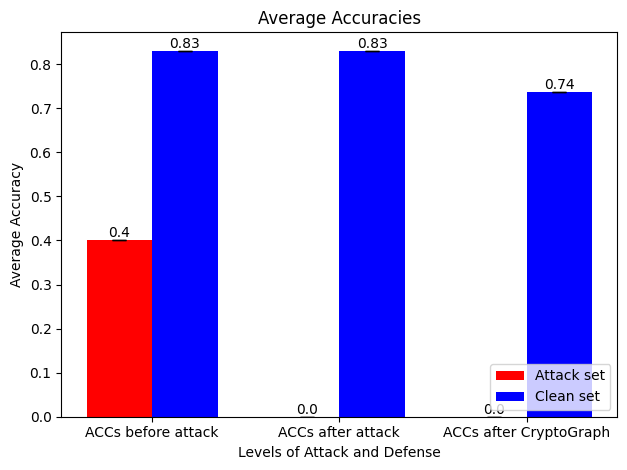

In [9]:
######## mahsa-V7 : improvements on V5.1 : changing to remove edges too. change: calculate_edge_scores_all_actions and perturb_edges_between_targets_all_actions
# now it considers just ACC3 for adj1 after CG defense.
# initial train on adj1  -DONE BEFORE ATTACK in the main execution

# calculating removed edges fixed. selects number of low/high/medium loss and gradients. 
# working on moyen loss and gradients- selection- number of low/high/medium loss and gradients 
# difference by test2  is here: #  test3:  sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: (x[1], x[2]))  # Sort by impact score, then by loss

# working not to choose zero scores.ok  attack on adj1 - number of nodes on low/high/medium loss and gradients - or just one node specific??
# budget just pour une seule action (ajouter ou enlever) pour chaque node cible
# choose nodes to attack based on loss and gradients not common neighbors - min/max/moyen loss and gradients
#  using surrogate model - using loss fonc and gradiant to edge-score for choosing nodes to attack ################
# 10 nodes who have most loss and gradients --- 10 nodes who have less loss and gradients
#  attack adding/removing edge: (NOT YET implemented le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed via gradient and loss of edges and common neighbors
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients


def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count=0, min_count=0, moyen_count=0, manual_nodes=None):
    if manual_nodes is not None and len(manual_nodes) > 0:
        print("Using manually selected nodes.")
        return [(node, 0, 0, 0) for node in manual_nodes]  # Dummy values for score, loss, gradient sum

    non_zero_loss_and_gradients_nodes = []

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        # Filter based on zero loss or negligible gradient values
        gradient_sum = np.sum(np.abs(gradients))
        if loss < 1e-5 or gradient_sum < 1e-12:  # Using a small threshold to account for numerical precision issues
            print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
            continue

        impact_score = loss * gradient_sum
        non_zero_loss_and_gradients_nodes.append((target_node, impact_score, loss, gradient_sum))

    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score
    # sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: (x[1], x[2]))  # Sort by impact score, then by loss



    # Selecting the top nodes with maximum loss and gradient
    max_nodes = sorted_nodes[-max_count:] if max_count > 0 else []
    # Selecting the bottom nodes with minimum loss and gradient
    min_nodes = sorted_nodes[:min_count] if min_count > 0 else []
    # Selecting nodes with median (moyen) loss and gradient
    median_index = len(sorted_nodes) // 2
    moyen_nodes = sorted_nodes[max(0, median_index - moyen_count//2): min(len(sorted_nodes), median_index + moyen_count//2)] if moyen_count > 0 else []

    return max_nodes, min_nodes, moyen_nodes


# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)


### change to consider all actions (add/remove) for each target node
def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        scores.append((target_node, i, action, score, delta_loss, common_neighbors))
    return scores

def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta)
            if not scores:
                break
            # Select the edge and action with the highest score
            best_edge_info = max(scores, key=lambda x: x[3])  # x[3] is the score
            edge = (best_edge_info[0], best_edge_info[1])
            action = best_edge_info[2]
            score = best_edge_info[3]
            delta_loss = best_edge_info[4]
            common_neighbors = best_edge_info[5]

            if action == 'add':
                # Perform add
                attacked_adj[edge[0], edge[1]] = 1
                attacked_adj[edge[1], edge[0]] = 1
                added_edges.append(edge)
                edge_added_count += 1
                print(f"Added edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")
            elif action == 'remove':
                # Perform remove
                attacked_adj[edge[0], edge[1]] = 0
                attacked_adj[edge[1], edge[0]] = 0
                removed_edges.append(edge)
                edge_removed_count += 1
                print(f"Removed edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}") 
    return attacked_adj, added_edges, removed_edges






# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# k = 10 # budget in the meaning of Number of nodes to attack
# nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
max_count = 0    # Number of nodes with maximum loss and gradients
min_count = 5    # Number of nodes with minimum loss and gradients
moyen_count = 0  # Number of nodes with median (moyen) loss and gradients
manual_nodes = [275, 1130, 716, 1182, 213, 121]  # List of nodes to attack manually
max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count, min_count, moyen_count)
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, manual_nodes=manual_nodes)

print("Contents of max_nodes:", max_nodes)
print("Contents of min_nodes:", min_nodes)
print("Contents of moyen_nodes:", moyen_nodes)

# Combine into nodes_to_attack
nodes_to_attack = max_nodes + min_nodes + moyen_nodes
print("Contents of nodes_to_attack:", nodes_to_attack)

# Print out node information
print("Nodes chosen for attack:")
for node_info in nodes_to_attack:
    if isinstance(node_info, tuple):
        node, score, loss, gradient_sum = node_info
        print(f"Node: {node}, Total Score: {score:.4f}, Loss: {loss:.4f}, Gradient Sum: {gradient_sum:.4f}")
    else:
        print(f"Unexpected format: {node_info} (type: {type(node_info)})")


# Extract only the node IDs from nodes_to_attack
nodes_to_attack_ids = [node_info[0] for node_info in nodes_to_attack if isinstance(node_info, tuple)]
idx_test_attack = nodes_to_attack_ids
# Identify clean nodes
idx_test_clean = [node for node in idx_test if node not in nodes_to_attack_ids]

print("Nodes chosen for attack:", nodes_to_attack_ids)
print("Nodes that are clean:", idx_test_clean)

print("Nodes chosen for attack:", idx_test_attack)
print("Nodes that are clean:", idx_test_clean)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 4 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 1.0
print(f" number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")

threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Use only the accuracy for the first part of the graph (adj1)
accuracy_test_attack_3_adj1 = accuracy_test_attack_3[0]  # First part for attack set
accuracy_test_clean_3_adj1 = accuracy_test_clean_3[0]  # First part for clean set


# Function to find removed edges
# Function to find removed edges  - should compare adj after attack and cg 
def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
    removed_edges = []
    attacked_adj_1 = attacked_adj_1.toarray()
    adj2 = adj2.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(combined_attacked_adj.shape[0]):
        for j in range(i + 1, combined_attacked_adj.shape[1]):
            if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")


# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_adj1)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_adj1)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_adj1)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_adj1)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [18]:
# 6.2: improved version 6.1 for exhaustive test on all the nodes   +    with modifications of adding and removing + reference accuracy NOT NOW on adj1 -- you should check it 
# without removing negligible zero loss and gradients
# compare accuracy after CG just for adj1 (not average of adj1 and adj2)
# 

import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients



# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        scores.append((target_node, i, action, score, delta_loss, common_neighbors))
    return scores

# Perturb edges between target nodes with one action per budget
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta)
            if not scores:
                break
            # Select the edge and action with the highest score
            best_edge_info = max(scores, key=lambda x: x[3])  # x[3] is the score
            edge = (best_edge_info[0], best_edge_info[1])
            action = best_edge_info[2]
            score = best_edge_info[3]
            delta_loss = best_edge_info[4]
            common_neighbors = best_edge_info[5]

            if action == 'add':
                # Perform add
                attacked_adj[edge[0], edge[1]] = 1
                attacked_adj[edge[1], edge[0]] = 1
                added_edges.append(edge)
                edge_added_count += 1
                print(f"Added edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")
            elif action == 'remove':
                # Perform remove
                attacked_adj[edge[0], edge[1]] = 0
                attacked_adj[edge[1], edge[0]] = 0
                removed_edges.append(edge)
                edge_removed_count += 1
                print(f"Removed edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}") 
    return attacked_adj, added_edges, removed_edges


################################ Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

subset_size = 20  # Number of nodes to reduce idx_test for performing statistic tests 
subset_idx_test = np.random.choice(idx_test, subset_size, replace=False)
print(f"Subset of idx_test for statistic tests: {subset_idx_test}")


############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)


# Initializing counters and lists for statistics
attacked_nodes_count = 0
skipped_nodes_count = 0
nodes_with_accuracy_drop_after_attack = 0
nodes_with_accuracy_drop_after_CG = 0
effective_CG_defense_count = 0
total_edges_removed_by_CG = 0
total_inaerted_edges_removed_by_CG = 0
nodes_with_accuracy_drop_clean_after_attack = 0
nodes_with_accuracy_drop_clean_after_CG = 0



all_nodes_results = []
# for target_node in idx_test:  # Iterate over all nodes in idx_test
for target_node in subset_idx_test: # Iterate over a subset of nodes in idx_test
    print(f"******Target node is: {target_node} with label: {labels[target_node]}******")
    idx_test_attack = [target_node]
    idx_test_clean = [node for node in idx_test if node != target_node]

    ########### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ############# perform attack Perturb edges
    budget = 5 # Number of edges to add or remove for each target node
    alpha = 1.0
    beta = 1.0
    # print(f" number of nodes to attack: {len(idx_test_attack)}")
    print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

    # Calculate gradients and loss for the target node
    loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
    print(f"Node: {target_node}, Loss: {loss}, Sum of gradients: {np.sum(np.abs(gradients))}")

    # Skip nodes with zero or negligible loss/gradients
    # if loss < 1e-5 or np.sum(np.abs(gradients)) < 1e-12:
    #     print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
    #     skipped_nodes_count += 1
    #     continue
    
    attacked_nodes_count += 1
    attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

    # Model evaluation after attack
    model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack)
    accuracy_test_clean_2 = model.test(idx_test_clean)
    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ##################   statistics after attack
    accuracy_drop_threshold_attack = 0.05  # 5% drop
    accuracy_drop_threshold_clean = 0.05  # 1% drop

    
    if (accuracy_test_attack_1 - accuracy_test_attack_2 > accuracy_drop_threshold_attack) or (accuracy_test_attack_1 == 1 and accuracy_test_attack_2 == 0):
        nodes_with_accuracy_drop_after_attack += 1

    # Check for significant drops in accuracy for clean set
    if accuracy_test_clean_1 - accuracy_test_clean_2 > accuracy_drop_threshold_clean:
        nodes_with_accuracy_drop_clean_after_attack += 1

    ##################   Crypto'Graph defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
            attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
            train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()

    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

########################## to take accuracy after defense #######################
 # Define a threshold for considering a significant improvement or drop in accuracy after CG defense
    # Calculate the average accuracy after CG defense (cause there are two parts of graphs on CG defense)
    # average_accuracy_attack_3 = sum(accuracy_test_attack_3) / len(accuracy_test_attack_3)
    # average_accuracy_clean_3 = sum(accuracy_test_clean_3) / len(accuracy_test_clean_3)

    # Use only the accuracy for the first part of the graph (adj1)
    accuracy_attack_3_adj1 = accuracy_test_attack_3[0]  # First part for attack set
    accuracy_clean_3_adj1 = accuracy_test_clean_3[0]  # First part for clean set


    # accuracy_drop_threshold_attack_GC = 0.01  # 1% drop
    # accuracy_drop_threshold_clean_GC = 0.01  # 1% drop

    accuracy_improvement_threshold = 0.55  # 1% improvement
    accuracy_drop_threshold_CG = 0.05  # 1% drop
    accuracy_drop_threshold_clean_CG= 0.20  # 1% drop

    # Compare accuracy after CG defense with accuracy after the attack
    if (accuracy_attack_3_adj1 >= accuracy_test_attack_2 + accuracy_improvement_threshold):
        effective_CG_defense_count += 1
    elif (accuracy_test_attack_2 - accuracy_attack_3_adj1 > accuracy_drop_threshold_CG):
        nodes_with_accuracy_drop_after_CG += 1

    # Compare accuracy after CG defense on clean nodes
    if (accuracy_clean_3_adj1 < accuracy_test_clean_2 - accuracy_drop_threshold_clean_CG):
        nodes_with_accuracy_drop_clean_after_CG += 1




        # Function to find removed edges  - should compare adj after attack and cg 
    def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
        removed_edges = []
        attacked_adj_1 = attacked_adj_1.toarray()
        adj2 = adj2.toarray()
        defended_adj1 = defended_adj1.toarray()
        defended_adj2 = defended_adj2.toarray()
        combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
        combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
        for i in range(combined_attacked_adj.shape[0]):
            for j in range(i + 1, combined_attacked_adj.shape[1]):
                if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                    removed_edges.append((i, j))
        return removed_edges

    # Find all removed edges
    removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
    print(f"Total number of removed edges by CG: {len(removed_edges)}")

    total_edges_removed_by_CG += len(removed_edges)


    # Check if any of the inserted edges during the attack were removed by CG
    removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
    print(f"Inserted edges removed by CG: {removed_inserted_edges}")
    print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")
    total_inaerted_edges_removed_by_CG += len(removed_inserted_edges)


    # Store results for later analysis
    all_nodes_results.append({
        'node': target_node,
        'attack_accuracy_before': accuracy_test_attack_1,
        'clean_accuracy_before': accuracy_test_clean_1,
        'attack_accuracy_after': accuracy_test_attack_2,
        'clean_accuracy_after': accuracy_test_clean_2,
        'attack_accuracy_CG': accuracy_test_attack_3,
        'clean_accuracy_CG': accuracy_test_clean_3,
        'added_edges': added_edges,
        'removed_edges': removed_edges,
        'loss': loss,
        'gradient_sum': np.sum(np.abs(gradients))
        })

 #Final statistics
total_nodes = len(idx_test) # Number of nodes in idx_test
subset_nodes = len(subset_idx_test) # Number of nodes in idx_test
percentage_attacked_nodes = (attacked_nodes_count / total_nodes) * 100
percentage_skipped_nodes = (skipped_nodes_count / total_nodes) * 100

if attacked_nodes_count > 0: # Avoid division by zero
    percentage_nodes_with_significant_accuracy_drop_after_attack = (nodes_with_accuracy_drop_after_attack / attacked_nodes_count) * 100
    percentage_nodes_with_significant_accuracy_drop_after_CG = (nodes_with_accuracy_drop_after_CG / attacked_nodes_count) * 100
    percentage_effective_CG_defense = (effective_CG_defense_count / attacked_nodes_count) * 100
else:
    percentage_nodes_with_significant_accuracy_drop_after_attack = 0
    percentage_nodes_with_significant_accuracy_drop_after_CG = 0
    percentage_effective_CG_defense = 0


percentage_clean_nodes_with_significant_drop_after_attack = (nodes_with_accuracy_drop_clean_after_attack / total_nodes) * 100
percentage_clean_nodes_with_significant_drop_after_CG = (nodes_with_accuracy_drop_clean_after_CG / total_nodes) * 100

print("**************** Final statistics: ****************")
print(f"Total number of nodes: {total_nodes}")
print(f"Number of nodes in subset: {subset_nodes}")
print(f"Number of nodes attacked: {attacked_nodes_count} ({percentage_attacked_nodes:.2f}%)")
print(f"Number of nodes skipped due to zero loss or negligible gradients: {skipped_nodes_count} ({percentage_skipped_nodes:.2f}%)")
print(f"Number of nodes with significant accuracy drop(Delta acc1-acc2>{accuracy_drop_threshold_attack}) after attack: {nodes_with_accuracy_drop_after_attack} ({percentage_nodes_with_significant_accuracy_drop_after_attack:.2f}%)")
print(f"Number of nodes with significant accuracy drop(Delta acc2-acc3>{accuracy_drop_threshold_CG}) after CG: {nodes_with_accuracy_drop_after_CG} ({percentage_nodes_with_significant_accuracy_drop_after_CG:.2f}%)")
print(f"Effective CG defense count(acc3>acc2+{accuracy_improvement_threshold}): {effective_CG_defense_count} ({percentage_effective_CG_defense:.2f}%)")
print(f"Total edges removed by CG: {total_edges_removed_by_CG}")
print(f"Total inserted edges removed by CG: {total_inaerted_edges_removed_by_CG}")
print(f"Number of clean nodes with significant accuracy drop(Delta accCl1-accCl2>{accuracy_drop_threshold_clean}) after attack: {nodes_with_accuracy_drop_clean_after_attack} ({percentage_clean_nodes_with_significant_drop_after_attack:.2f}%)")
print(f"Number of clean nodes with significant accuracy drop after CG: {nodes_with_accuracy_drop_clean_after_CG} ({percentage_clean_nodes_with_significant_drop_after_CG:.2f}%)")

Loading polblogs dataset...
Subset of idx_test for statistic tests: [1214 1367 1480  171  608 1164  870  883   85  552   44 1249  412 1161
 1315 1143 1040 1485   83  365]
******Target node is: 1214 with label: 1******
Test set results: loss= 0.3643 accuracy= 0.8547
Test set results: loss= 0.0154 accuracy= 1.0000
Test set results: loss= 0.3646 accuracy= 0.8546
Test accuracy on attack set:  1.0
Test accuracy on clean set:  0.8545837723919916
budget: 5 alpha(gradient's importance): 1.0 beta( commun neighbor's importance): 1.0
Node: 1214, Loss: 0.0, Sum of gradients: 0.0
Target node is: 1214 with label: 1
Total number of edges added: 0
Total number of edges removed: 0
Test set results: loss= 0.0392 accuracy= 1.0000
Test set results: loss= 0.4043 accuracy= 0.8282
Test accuracy on attack set after attack:  1.0
Test accuracy on clean set after attack:  0.8282402528977871
*************** Crypto'Graph defense ***************
Dropping dissimilar edges using metric :  neighbors  on links
removed 

C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (1480, 27)
Gradient: 1.3621013436807233e-39
Number of common neighbors: 1
Score: 1.0
Added edge: (1480, 209)
Gradient: 1.3002780172525624e-38
Number of common neighbors: 2
Score: 2.0
Added edge: (1480, 433)
Gradient: 2.0717939956124985e-38
Number of common neighbors: 3
Score: 3.0
Removed edge: (1480, 27)
Gradient: 1.3621013436807233e-39
Number of common neighbors: 3
Score: 3.0
Added edge: (1480, 27)
Gradient: 1.3621013436807233e-39
Number of common neighbors: 3
Score: 3.0
Total number of edges added: 4
Total number of edges removed: 1
Test set results: loss= 0.9783 accuracy= 0.0000
Test set results: loss= 0.4102 accuracy= 0.8177
Test accuracy on attack set after attack:  0.0
Test accuracy on clean set after attack:  0.8177028451001054
*************** Crypto'Graph defense ***************
Dropping dissimilar edges using metric :  neighbors  on links
removed 1639 edges in polblogs 1
removed 1663 edges in polblogs 2
*** polblogs 1 ***
Test set results: loss= 0.8538 accuracy= 0.

In [ ]:
# V8:ERROR--- Adaptatif budget for each node+ heatmap  ---- no bud used for some nodes
# version 6.2: improved version 6.1 for exhaustive test on all the nodes   +    with modifications of adding and removing
# without removing negligible zero loss and gradients
# compare accuracy after CG just for adj1 (not average of adj1 and adj2)
# 
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        scores.append((target_node, i, action, score, delta_loss, common_neighbors))
    return scores

# Adaptive attack for a single node
def adaptive_attack_node(adj, surrogate_model, features, labels, target_node, max_budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    budget_used = 0
    edge_added_count = 0
    edge_removed_count = 0
    misclassified = False
    modified_edges = set()

    while budget_used < max_budget and not misclassified:
        # print(f"Current budget used for node {target_node}: {budget_used}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)

        if not np.any(gradients):
            # print(f"No gradients available for node {target_node}. Stopping attack.")
            break

        # Calculate edge scores
        scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta)
        if not scores:
            # print(f"No possible edges to modify for node {target_node}. Stopping attack.")
            break

        # Select the edge and action with the highest score
        best_edge_info = max(scores, key=lambda x: x[3])  # x[3] is the score
        edge = (best_edge_info[0], best_edge_info[1])
        action = best_edge_info[2]
        score = best_edge_info[3]
        delta_loss = best_edge_info[4]
        common_neighbors = best_edge_info[5]

        if action == 'add':
            # Perform add
            attacked_adj[edge[0], edge[1]] = 1
            attacked_adj[edge[1], edge[0]] = 1
            added_edges.append(edge)
            edge_added_count += 1
            # print(f"Added edge: {edge}")
        elif action == 'remove':
            # Perform remove
            attacked_adj[edge[0], edge[1]] = 0
            attacked_adj[edge[1], edge[0]] = 0
            removed_edges.append(edge)
            edge_removed_count += 1
            # print(f"Removed edge: {edge}")

        budget_used += 1

        # Check if the node is misclassified
        model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                    nhid=16, device=device, dropout=0.5)
        model = model.to(device)
        model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
        model.eval()
        output = model.predict(features, attacked_adj)
        pred_label = output.argmax(dim=1)[target_node]
        true_label = labels[target_node]

        if pred_label != true_label:
            # print(f"Node {target_node} misclassified after budget {budget_used}")
            misclassified = True

    return attacked_adj, budget_used, added_edges, removed_edges, misclassified

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42

set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

# For test nodes
subset_size = 2  # Number of nodes to reduce idx_test for performing statistic tests 
subset_idx_test = np.random.choice(idx_test, subset_size, replace=False)

# For all nodes (uncomment if needed)
# subset_size = adj.shape[0]  # Use all nodes in the graph
# subset_idx_test = np.arange(adj.shape[0])  # All nodes

print(f"Subset of idx_test for statistic tests: {subset_idx_test}")

# Train surrogate model
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# Initialize lists for results
node_budgets = []
node_edge_additions = []
node_edge_removals = []
nodes_misclassified = []
accuracy_before_attack_list = []
accuracy_after_attack_list = []
accuracy_after_CG_list = []
node_ids = []
max_budget_per_node = 100  # Set maximum budget per node

# Parameters for edge score calculation
alpha = 1.0
beta = 1.0

# Iterate over each node in the subset
for target_node in subset_idx_test:
    print(f"****** Target node: {target_node} ******")
    idx_test_attack = [target_node]
    idx_test_clean = [node for node in idx_test if node != target_node]

    # Initialize the attacked adjacency matrix for this node
    attacked_adj_node = adj1.copy()

    # Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, attacked_adj_node, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.predict(features, attacked_adj_node)
    pred_label = output.argmax(dim=1)
    true_label = labels

    # Adjusted calculation for accuracy before attack
    is_correct = (pred_label[target_node] == true_label[target_node]).item()
    accuracy_before_attack = float(is_correct)
    print(f"Accuracy before attack on node {target_node}: {accuracy_before_attack}")

    # Perform adaptive attack on the node
    attacked_adj_node, budget_used, added_edges, removed_edges, misclassified = adaptive_attack_node(
        attacked_adj_node, surrogate_model, features, labels, target_node, max_budget_per_node, alpha, beta)

    # Check accuracy after attack
    model.fit(features, attacked_adj_node, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.predict(features, attacked_adj_node)
    pred_label = output.argmax(dim=1)
    is_correct_after_attack = (pred_label[target_node] == true_label[target_node]).item()
    accuracy_after_attack = float(is_correct_after_attack)
    print(f"Accuracy after attack on node {target_node}: {accuracy_after_attack}")

    # Apply Crypto'Graph defense after successful attack
    if misclassified:
        print("Applying Crypto'Graph defense...")
        threshold = 2
        metric = "neighbors"
        object = "links"

        model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16,
                                 nclass=labels.max().item() + 1, device=device)
        _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
            attacked_adj_node.copy(), adj2.copy(), features, features, labels, idx_train,
            threshold, metric=metric, object=object, train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
        model_CG.eval()

        # Evaluate after CG defense
        model_CG.fit(features, defended_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
        model_CG.eval()
        output_CG = model_CG.predict(features, defended_adj1)
        pred_label_CG = output_CG.argmax(dim=1)
        is_correct_after_CG = (pred_label_CG[target_node] == true_label[target_node]).item()
        accuracy_after_CG = float(is_correct_after_CG)
        print(f"Accuracy after Crypto'Graph defense on node {target_node}: {accuracy_after_CG}")
    else:
        accuracy_after_CG = accuracy_after_attack  # If attack was not successful, accuracy remains the same
        print(f"Attack not successful on node {target_node}, skipping Crypto'Graph defense.")

    # Record results
    node_ids.append(target_node)
    node_budgets.append(budget_used)
    node_edge_additions.append(len(added_edges))
    node_edge_removals.append(len(removed_edges))
    nodes_misclassified.append(int(misclassified))
    accuracy_before_attack_list.append(accuracy_before_attack)
    accuracy_after_attack_list.append(accuracy_after_attack)
    accuracy_after_CG_list.append(accuracy_after_CG)

    # Print results for the node
    print(f"Node {target_node}:")
    print(f"  Budget Used: {budget_used}")
    print(f"  Edges Added: {len(added_edges)}")
    print(f"  Edges Removed: {len(removed_edges)}")
    print(f"  Misclassified After Attack: {bool(misclassified)}")
    print(f"  Accuracy Before Attack: {accuracy_before_attack}")
    print(f"  Accuracy After Attack: {accuracy_after_attack}")
    print(f"  Accuracy After CG Defense: {accuracy_after_CG}")
    print("-" * 50)

# Generate DataFrame with results
results_df = pd.DataFrame({
    'Node': node_ids,
    'Budget Used': node_budgets,
    'Edges Added': node_edge_additions,
    'Edges Removed': node_edge_removals,
    'Misclassified': nodes_misclassified,
    'Accuracy Before Attack': accuracy_before_attack_list,
    'Accuracy After Attack': accuracy_after_attack_list,
    'Accuracy After CG Defense': accuracy_after_CG_list
})

# Save the results to a CSV file
results_df.to_csv('attack_results_per_node.csv', index=False)

# Print final summary
print("Final Summary:")
print(results_df)




In [20]:
# V8: Adaptatif budget for each node+ heatmap(no heatmap now)----correcting no bud used by-- # remove early stopping  # if not np.any(gradients) : comment out


#  improved version 6.1 for exhaustive test on all the nodes   +    with modifications of adding and removing
# without removing negligible zero loss and gradients
# compare accuracy after CG just for adj1 (not average of adj1 and adj2)

import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta, modified_edges):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        edge_tuple = tuple(sorted((target_node, i)))
        if edge_tuple in modified_edges:
            continue  # Skip edges that have already been modified

        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        # scores.append((target_node, i, action, score, delta_loss, common_neighbors))
        scores.append({
            'edge': (target_node, i),
            'action': action,
            'score': score,
            'delta_loss': delta_loss,
            'common_neighbors': common_neighbors
        })
    return scores

# Adaptive attack for a single node
def adaptive_attack_node(adj, surrogate_model, features, labels, target_node, max_budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    budget_used = 0
    edge_added_count = 0
    edge_removed_count = 0
    misclassified = False
    attack_stopped_reason = None
    modified_edges = set() # Set to keep track of modified edges to prevent re-modification (on edge loop)

    while budget_used < max_budget and not misclassified:
        print(f"Current budget used for node {target_node}: {budget_used}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)

        # this is the early stopping condition, when the gradients are zero attack is stopped
        # if not np.any(gradients):
        #     attack_stopped_reason = 'zero_gradients'
        #     print(f"No gradients available for node {target_node}. Stopping attack.")
        #     break

        # Calculate edge scores
        scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta, modified_edges)
        if not scores:
            attack_stopped_reason = 'no_edges_to_modify'
            print(f"No possible edges to modify for node {target_node}. Stopping attack.")
            break

        # Select the edge and action with the highest score
        # best_edge_info = max(scores, key=lambda x: x[3])  # x[3] is the score
        # edge = (best_edge_info[0], best_edge_info[1])
        # action = best_edge_info[2]
        # score = best_edge_info[3]
        # delta_loss = best_edge_info[4]
        # common_neighbors = best_edge_info[5]

        best_edge_info = max(scores, key=lambda x: x['score'])
        edge = best_edge_info['edge']
        action = best_edge_info['action']
        score = best_edge_info['score']


        # If the score is zero or negative, no beneficial edge modification can be made
        if score <= 0:
            attack_stopped_reason = 'no_positive_score'
            break

        if action == 'add':
            # Perform add
            attacked_adj[edge[0], edge[1]] = 1
            attacked_adj[edge[1], edge[0]] = 1
            added_edges.append(edge)
            edge_added_count += 1
            print(f"Added edge: {edge}")
        elif action == 'remove':
            # Perform remove
            attacked_adj[edge[0], edge[1]] = 0
            attacked_adj[edge[1], edge[0]] = 0
            removed_edges.append(edge)
            edge_removed_count += 1
            print(f"Removed edge: {edge}")

        # Add the modified edge to the set to prevent re-modification
        edge_tuple = tuple(sorted(edge))
        modified_edges.add(edge_tuple)
        
        budget_used += 1

        # Check if the node is misclassified
        model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                    nhid=16, device=device, dropout=0.5)
        model = model.to(device)
        model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
        model.eval()
        output = model.predict(features, attacked_adj)
        pred_label = output.argmax(dim=1)[target_node]
        true_label = labels[target_node]

        if pred_label != true_label:
            attack_stopped_reason = 'misclassified'
            print(f"Node {target_node} misclassified after budget {budget_used}")
            misclassified = True

    if not misclassified and budget_used >= max_budget:
        attack_stopped_reason = 'budget_exhausted'

    return attacked_adj, budget_used, added_edges, removed_edges, misclassified, attack_stopped_reason

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42

set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

# For test nodes
subset_size = 10  # Number of nodes to reduce idx_test for performing statistic tests 
subset_idx_test = np.random.choice(idx_test, subset_size, replace=False)

# For all nodes (uncomment if needed)
# subset_size = adj.shape[0]  # Use all nodes in the graph
# subset_idx_test = np.arange(adj.shape[0])  # All nodes

print(f"Subset of idx_test for statistic tests: {subset_idx_test}")

# Train surrogate model
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# Initialize lists for results
node_budgets = []
node_edge_additions = []
node_edge_removals = []
nodes_misclassified = []
accuracy_before_attack_list = []
accuracy_after_attack_list = []
accuracy_after_CG_list = []
node_ids = []
attack_stopped_reasons = []
node_degrees = []
initial_losses = []
initial_gradient_magnitudes = []
initial_gradients_zero_list = []

max_budget_per_node = 50  # Set maximum budget per node

# Parameters for edge score calculation
alpha = 1.0
beta = 1.0

# Iterate over each node in the subset
for target_node in subset_idx_test:
    print(f"****** Target node: {target_node} ******")
    idx_test_attack = [target_node]
    idx_test_clean = [node for node in idx_test if node != target_node]

    # Compute degree of the target node
    degree = adj[target_node].count_nonzero()
    node_degrees.append(degree)

    # Compute initial loss and gradients
    initial_loss, initial_gradients = compute_gradients(surrogate_model, features, adj1, labels, target_node)
    initial_gradient_magnitude = np.linalg.norm(initial_gradients)
    initial_gradients_zero = not np.any(initial_gradients)

    initial_losses.append(initial_loss)
    initial_gradient_magnitudes.append(initial_gradient_magnitude)
    initial_gradients_zero_list.append(int(initial_gradients_zero))

    # Initialize the attacked adjacency matrix for this node
    attacked_adj_node = adj1.copy()

    # Train GCN model initially for evaluation before attack //// using adj1 for initial training 
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, attacked_adj_node, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.predict(features, attacked_adj_node)
    pred_label = output.argmax(dim=1)
    true_label = labels

    # Adjusted calculation for accuracy before attack
    is_correct = (pred_label[target_node] == true_label[target_node]).item()
    accuracy_before_attack = float(is_correct)
    print(f"Accuracy before attack on node {target_node}: {accuracy_before_attack}")

    # Perform adaptive attack on the node
    attacked_adj_node, budget_used, added_edges, removed_edges, misclassified, attack_stopped_reason = adaptive_attack_node(
        attacked_adj_node, surrogate_model, features, labels, target_node, max_budget_per_node, alpha, beta)

    attack_stopped_reasons.append(attack_stopped_reason)

    # Check accuracy after attack
    model.fit(features, attacked_adj_node, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.predict(features, attacked_adj_node)
    pred_label = output.argmax(dim=1)
    is_correct_after_attack = (pred_label[target_node] == true_label[target_node]).item()
    accuracy_after_attack = float(is_correct_after_attack)
    print(f"Accuracy after attack on node {target_node}: {accuracy_after_attack}")

    # Apply Crypto'Graph defense after successful attack
    if misclassified:
        print("Applying Crypto'Graph defense...")
        threshold = 2
        metric = "neighbors"
        object = "links"

        model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16,
                                 nclass=labels.max().item() + 1, device=device)
        defense_duration, defense_duration, training_duration1, training_duration2, defended_adj1, defended_adj2 = model_CG.fit(
            attacked_adj_node.copy(), adj2.copy(), features, features, labels, idx_train,
            threshold, metric=metric, object=object, train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
        model_CG.eval()

            # Evaluate after CG defense
        output_CG = model_CG.gcn1.predict(features, defended_adj1)  # Use GCN model's predict method
        pred_label_CG = output_CG.argmax(dim=1)
        is_correct_after_CG = (pred_label_CG[target_node] == true_label[target_node]).item()
        accuracy_after_CG = float(is_correct_after_CG)
        print(f"Accuracy after Crypto'Graph defense on node {target_node}: {accuracy_after_CG}")
    else:
        accuracy_after_CG = accuracy_after_attack  # If attack was not successful, accuracy remains the same
        print(f"Attack not successful on node {target_node}, skipping Crypto'Graph defense.")

        # Evaluate after CG defense
    #     output_CG = model_CG.predict(features, defended_adj1)
    #     pred_label_CG = output_CG.argmax(dim=1)
    #     is_correct_after_CG = (pred_label_CG[target_node] == true_label[target_node]).item()
    #     accuracy_after_CG = float(is_correct_after_CG)
    #     print(f"Accuracy after Crypto'Graph defense on node {target_node}: {accuracy_after_CG}")
    # else:
    #     accuracy_after_CG = accuracy_after_attack  # If attack was not successful, accuracy remains the same
    #     print(f"Attack not successful on node {target_node}, skipping Crypto'Graph defense.")


        

    # Record results
    node_ids.append(target_node)
    node_budgets.append(budget_used)
    node_edge_additions.append(len(added_edges))
    node_edge_removals.append(len(removed_edges))
    nodes_misclassified.append(int(misclassified))
    accuracy_before_attack_list.append(accuracy_before_attack)
    accuracy_after_attack_list.append(accuracy_after_attack)
    accuracy_after_CG_list.append(accuracy_after_CG)

    # Print results for the node
    print(f"Node {target_node}:")
    print(f"  Degree: {degree}")
    print(f"  Initial Gradient Magnitude: {initial_gradient_magnitude}")
    print(f"  Initial Gradients Zero: {initial_gradients_zero}")
    print(f"  Attack Stopped Reason: {attack_stopped_reason}")
    print(f"  Budget Used: {budget_used}")
    print(f"  Edges Added: {len(added_edges)}")
    print(f"  Edges Removed: {len(removed_edges)}")
    print(f"  Misclassified After Attack: {bool(misclassified)}")
    print(f"  Accuracy Before Attack: {accuracy_before_attack}")
    print(f"  Accuracy After Attack: {accuracy_after_attack}")
    print(f"  Accuracy After CG Defense: {accuracy_after_CG}")
    print("-" * 50)

# Generate DataFrame with results
results_df = pd.DataFrame({
    'Node': node_ids,
    'Degree': node_degrees,
    'Initial Loss': initial_losses,
    'Initial Gradient Magnitude': initial_gradient_magnitudes,
    'Initial Gradients Zero': initial_gradients_zero_list,
    'Attack Stopped Reason': attack_stopped_reasons,
    'Budget Used': node_budgets,
    'Edges Added': node_edge_additions,
    'Edges Removed': node_edge_removals,
    'Misclassified': nodes_misclassified,
    'Accuracy Before Attack': accuracy_before_attack_list,
    'Accuracy After Attack': accuracy_after_attack_list,
    'Accuracy After CG Defense': accuracy_after_CG_list
})

# Save the results to a CSV file
results_df.to_csv('attack_results_per_node.csv', index=False)

# Print final summary
print("Final Summary:")
print(results_df)

'''
# Analysis Code
# Visualize the relationship between degree, initial gradients, and attack success
import seaborn as sns

# Plot Degree vs. Misclassification
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='Degree', y='Misclassified')
plt.xlabel('Degree of Node')
plt.ylabel('Misclassified (1=True, 0=False)')
plt.title('Degree vs. Misclassification')
plt.savefig('degree_vs_misclassification.png')
plt.show()

# Plot Initial Gradient Magnitude vs. Misclassification
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='Initial Gradient Magnitude', y='Misclassified')
plt.xlabel('Initial Gradient Magnitude')
plt.ylabel('Misclassified (1=True, 0=False)')
plt.title('Initial Gradient Magnitude vs. Misclassification')
plt.savefig('gradient_vs_misclassification.png')
plt.show()

# Plot Degree vs. Initial Gradient Magnitude
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='Degree', y='Initial Gradient Magnitude')
plt.xlabel('Degree of Node')
plt.ylabel('Initial Gradient Magnitude')
plt.title('Degree vs. Initial Gradient Magnitude')
plt.savefig('degree_vs_gradient.png')
plt.show()

# Analyze reasons why attack stopped
attack_reasons_counts = results_df['Attack Stopped Reason'].value_counts()
print("Attack Stopped Reasons:")
print(attack_reasons_counts)

# Filter nodes where attack stopped due to zero gradients
zero_gradients_df = results_df[results_df['Attack Stopped Reason'] == 'zero_gradients']
print("\nNodes where attack stopped due to zero gradients:")
print(zero_gradients_df)

# Analyze the effect of common neighbors (if needed)
# Since calculating common neighbors for all pairs is computationally intensive,
# you can consider calculating average common neighbors with immediate neighbors or a sample.

# For example, calculate average common neighbors with immediate neighbors
def calculate_average_common_neighbors(adj, target_node):
    neighbors = adj[target_node].indices
    total_common_neighbors = 0
    count = 0
    for neighbor in neighbors:
        if neighbor == target_node:
            continue
        common_neighbors = calculate_common_neighbors(adj, target_node, neighbor)
        total_common_neighbors += common_neighbors
        count += 1
    if count == 0:
        return 0
    return total_common_neighbors / count

average_common_neighbors_list = []
for target_node in node_ids:
    avg_cn = calculate_average_common_neighbors(adj, target_node)
    average_common_neighbors_list.append(avg_cn)

results_df['Average Common Neighbors'] = average_common_neighbors_list

# Plot Average Common Neighbors vs. Misclassification
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='Average Common Neighbors', y='Misclassified')
plt.xlabel('Average Common Neighbors')
plt.ylabel('Misclassified (1=True, 0=False)')
plt.title('Average Common Neighbors vs. Misclassification')
plt.savefig('avg_cn_vs_misclassification.png')
plt.show()
'''

Loading polblogs dataset...
Subset of idx_test for statistic tests: [1214 1367 1480  171  608 1164  870  883   85  552]
****** Target node: 1214 ******
Accuracy before attack on node 1214: 1.0
Current budget used for node 1214: 0
Removed edge: (1214, 854)
Current budget used for node 1214: 1
Added edge: (1214, 1050)
Current budget used for node 1214: 2
Removed edge: (1214, 1100)
Current budget used for node 1214: 3


C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (1214, 1111)
Current budget used for node 1214: 4
Removed edge: (1214, 1244)
Current budget used for node 1214: 5
Removed edge: (1214, 1478)
Current budget used for node 1214: 6
Removed edge: (1214, 1152)
Current budget used for node 1214: 7
Added edge: (1214, 761)
Current budget used for node 1214: 8
Added edge: (1214, 879)
Current budget used for node 1214: 9
Added edge: (1214, 1383)
Current budget used for node 1214: 10
Added edge: (1214, 1208)
Current budget used for node 1214: 11
Added edge: (1214, 1040)
Current budget used for node 1214: 12
Removed edge: (1214, 1426)
Current budget used for node 1214: 13
Removed edge: (1214, 774)
Current budget used for node 1214: 14
Added edge: (1214, 855)
Current budget used for node 1214: 15
Removed edge: (1214, 809)
Current budget used for node 1214: 16
Added edge: (1214, 877)
Current budget used for node 1214: 17
Removed edge: (1214, 962)
Current budget used for node 1214: 18
Added edge: (1214, 965)
Current budget used for node 1

'\n# Analysis Code\n# Visualize the relationship between degree, initial gradients, and attack success\nimport seaborn as sns\n\n# Plot Degree vs. Misclassification\nplt.figure(figsize=(8, 6))\nsns.scatterplot(data=results_df, x=\'Degree\', y=\'Misclassified\')\nplt.xlabel(\'Degree of Node\')\nplt.ylabel(\'Misclassified (1=True, 0=False)\')\nplt.title(\'Degree vs. Misclassification\')\nplt.savefig(\'degree_vs_misclassification.png\')\nplt.show()\n\n# Plot Initial Gradient Magnitude vs. Misclassification\nplt.figure(figsize=(8, 6))\nsns.scatterplot(data=results_df, x=\'Initial Gradient Magnitude\', y=\'Misclassified\')\nplt.xlabel(\'Initial Gradient Magnitude\')\nplt.ylabel(\'Misclassified (1=True, 0=False)\')\nplt.title(\'Initial Gradient Magnitude vs. Misclassification\')\nplt.savefig(\'gradient_vs_misclassification.png\')\nplt.show()\n\n# Plot Degree vs. Initial Gradient Magnitude\nplt.figure(figsize=(8, 6))\nsns.scatterplot(data=results_df, x=\'Degree\', y=\'Initial Gradient Magnitu

In [23]:
# V8.1: Adaptatif budget for each node ACC2=0 +  adaptif bud continue till ACC3=0 after defence is 0
#  heatmap(no heatmap now)----correcting no bud used by-- # remove early stopping  # if not np.any(gradients) : comment out


#  improved version 6.1 for exhaustive test on all the nodes   +    with modifications of adding and removing
# without removing negligible zero loss and gradients
# compare accuracy after CG just for adj1 (not average of adj1 and adj2)

import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
import pandas as pd

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta, modified_edges):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        edge_tuple = tuple(sorted((target_node, i)))
        if edge_tuple in modified_edges:
            continue  # Skip edges that have already been modified

        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        scores.append({
            'edge': (target_node, i),
            'action': action,
            'score': score,
            'delta_loss': delta_loss,
            'common_neighbors': common_neighbors
        })
    return scores

# Adaptive attack for a single node
def adaptive_attack_node(adj, adj2, surrogate_model, features, labels, target_node, max_budget, alpha, beta, idx_train, idx_val, dataset):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    budget_used = 0
    misclassified = False
    misclassified_after_defense = False
    attack_stopped_reason = None
    modified_edges = set()  # To prevent re-modification of edges (loop)
    budget_used_until_misclassified = None
    budget_used_until_misclassified_after_defense = None

    while budget_used < max_budget and not misclassified_after_defense:
        print(f"Current budget used for node {target_node}: {budget_used}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)

        # Calculate edge scores
        scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta, modified_edges)
        if not scores:
            attack_stopped_reason = 'no_edges_to_modify'
            print(f"No possible edges to modify for node {target_node}. Stopping attack.")
            break

        # Select the edge and action with the highest score
        best_edge_info = max(scores, key=lambda x: x['score'])
        edge = best_edge_info['edge']
        action = best_edge_info['action']
        score = best_edge_info['score']

        # If the score is zero or negative, no beneficial edge modification can be made
        if score <= 0:
            attack_stopped_reason = 'no_positive_score'
            break

        if action == 'add':
            # Perform add
            attacked_adj[edge[0], edge[1]] = 1
            attacked_adj[edge[1], edge[0]] = 1
            added_edges.append(edge)
            print(f"Added edge: {edge}")
        elif action == 'remove':
            # Perform remove
            attacked_adj[edge[0], edge[1]] = 0
            attacked_adj[edge[1], edge[0]] = 0
            removed_edges.append(edge)
            print(f"Removed edge: {edge}")

        # Add the modified edge to the set to prevent re-modification
        edge_tuple = tuple(sorted(edge))
        modified_edges.add(edge_tuple)

        budget_used += 1

        # Check if the node is misclassified after attack
        model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                    nhid=16, device=device, dropout=0.5)
        model = model.to(device)
        model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
        model.eval()
        output = model.predict(features, attacked_adj)
        pred_label = output.argmax(dim=1)[target_node]
        true_label = labels[target_node]

        node_misclassified = pred_label != true_label

        if not misclassified and node_misclassified:
            # Node is misclassified for the first time after attack
            misclassified = True
            budget_used_until_misclassified = budget_used
            print(f"Node {target_node} misclassified after attack and budget of {budget_used}")

            # Apply Crypto'Graph defense
            print("Applying Crypto'Graph defense...")
            threshold = 2
            metric = "neighbors"
            object = "links"

            model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16,
                                     nclass=labels.max().item() + 1, device=device)
            # Apply defense
            _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
                attacked_adj.copy(), adj2.copy(), features, features, labels, idx_train,
                threshold, metric=metric, object=object, train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
            model_CG.eval()

            # Evaluate after CG defense
            output_CG = model_CG.gcn1.predict(features, defended_adj1)
            pred_label_CG = output_CG.argmax(dim=1)
            is_correct_after_CG = (pred_label_CG[target_node] == labels[target_node]).item()
            accuracy_after_CG = float(is_correct_after_CG)
            print(f"Accuracy after Crypto'Graph defense on node {target_node}: {accuracy_after_CG}")

            if accuracy_after_CG == 0.0:
                # Node remains misclassified after defense
                misclassified_after_defense = True
                budget_used_until_misclassified_after_defense = budget_used
                attack_stopped_reason = 'misclassified_after_defense'
                print(f"Node {target_node} misclassified after defense. Attack successful.")
                break
            else:
                # Defense recovered the correct classification
                print(f"Defense recovered the correct classification for node {target_node}. Continuing attack.")
        elif misclassified:
            # Node was misclassified before, check if it remains misclassified after defense
            # Apply Crypto'Graph defense
            print("Applying Crypto'Graph defense...")
            threshold = 2
            metric = "neighbors"
            object = "links"

            model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16,
                                     nclass=labels.max().item() + 1, device=device)
            # Apply defense
            _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
                attacked_adj.copy(), adj2.copy(), features, features, labels, idx_train,
                threshold, metric=metric, object=object, train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
            model_CG.eval()

            # Evaluate after CG defense
            output_CG = model_CG.gcn1.predict(features, defended_adj1)
            pred_label_CG = output_CG.argmax(dim=1)
            is_correct_after_CG = (pred_label_CG[target_node] == labels[target_node]).item()
            accuracy_after_CG = float(is_correct_after_CG)
            print(f"Accuracy after Crypto'Graph defense on node {target_node}: {accuracy_after_CG}")

            if accuracy_after_CG == 0.0:
                # Node remains misclassified after defense
                misclassified_after_defense = True
                budget_used_until_misclassified_after_defense = budget_used
                attack_stopped_reason = 'misclassified_after_defense'
                print(f"Node {target_node} misclassified after defense. Attack successful.")
                break
            else:
                # Defense recovered the correct classification
                print(f"Defense recovered the correct classification for node {target_node}. Continuing attack.")

    if not misclassified_after_defense:
        if budget_used >= max_budget:
            attack_stopped_reason = 'budget_exhausted'
            if misclassified:
                attack_stopped_reason = 'misclassified_but_defense_recovered_model_with_available_budget'
                print(f"Budget exhausted. Node {target_node} was misclassified after attack, but defense recovered the correct classification.")
            else:
                attack_stopped_reason = 'budget_exhausted_without_misclassification'
                print(f"Budget exhausted. Node {target_node} was not misclassified.")
        else:
            if misclassified:
                attack_stopped_reason = 'defense_recovered_model'
                print(f"Defense recovered the correct classification for node {target_node}. Attack stopped.")

    # After the attack is finished, compute the number of added edges that were removed by the defense
    num_edges_removed_by_defense = 0
    if misclassified or misclassified_after_defense:
        # Apply the defense one last time to get defended_adj1
        model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16,
                                 nclass=labels.max().item() + 1, device=device)
        _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
            attacked_adj.copy(), adj2.copy(), features, features, labels, idx_train,
            threshold=2, metric="neighbors", object="links", train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
        # Compute edges removed by defense
        for edge in added_edges:
            if defended_adj1[edge[0], edge[1]] == 0:
                num_edges_removed_by_defense += 1

    return (attacked_adj, budget_used, added_edges, removed_edges, misclassified, misclassified_after_defense,
            attack_stopped_reason, num_edges_removed_by_defense, budget_used_until_misclassified,
            budget_used_until_misclassified_after_defense)

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42

set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

# For test nodes
subset_size = 20  # Number of nodes to reduce idx_test for performing statistic tests 
subset_idx_test = np.random.choice(idx_test, subset_size, replace=False)

print(f"Subset of idx_test for statistic tests: {subset_idx_test}")

# Train surrogate model
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# Initialize lists for results
node_budgets = []
node_edge_additions = []
node_edge_removals = []
nodes_misclassified = []
nodes_misclassified_after_defense = []
accuracy_before_attack_list = []
accuracy_after_attack_list = []
accuracy_after_CG_list = []
node_ids = []
attack_stopped_reasons = []
node_degrees = []
initial_losses = []
initial_gradient_magnitudes = []
initial_gradients_zero_list = []
edges_removed_by_defense_list = []
budget_used_until_misclassified_list = []
budget_used_until_misclassified_after_defense_list = []

max_budget_per_node = 50  # Set maximum budget per node

# Parameters for edge score calculation
alpha = 1.0
beta = 1.0

# Iterate over each node in the subset
for target_node in subset_idx_test:
    print(f"****** Target node: {target_node} ******")
    idx_test_attack = [target_node]
    idx_test_clean = [node for node in idx_test if node != target_node]

    # Compute degree of the target node
    degree = adj[target_node].count_nonzero()
    node_degrees.append(degree)

    # Compute initial loss and gradients
    initial_loss, initial_gradients = compute_gradients(surrogate_model, features, adj1, labels, target_node)
    initial_gradient_magnitude = np.linalg.norm(initial_gradients)
    initial_gradients_zero = not np.any(initial_gradients)

    initial_losses.append(initial_loss)
    initial_gradient_magnitudes.append(initial_gradient_magnitude)
    initial_gradients_zero_list.append(int(initial_gradients_zero))

    # Initialize the attacked adjacency matrix for this node
    attacked_adj_node = adj1.copy()

    # Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, attacked_adj_node, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.predict(features, attacked_adj_node)
    pred_label = output.argmax(dim=1)
    true_label = labels

    # Adjusted calculation for accuracy before attack
    is_correct = (pred_label[target_node] == true_label[target_node]).item()
    accuracy_before_attack = float(is_correct)
    print(f"Accuracy before attack on node {target_node}: {accuracy_before_attack}")

    # Perform adaptive attack on the node
    (attacked_adj_node, budget_used, added_edges, removed_edges, misclassified, misclassified_after_defense,
     attack_stopped_reason, num_edges_removed_by_defense, budget_used_until_misclassified,
     budget_used_until_misclassified_after_defense) = adaptive_attack_node(
        attacked_adj_node, adj2, surrogate_model, features, labels, target_node, max_budget_per_node, alpha, beta, idx_train, idx_val, dataset)

    attack_stopped_reasons.append(attack_stopped_reason)
    edges_removed_by_defense_list.append(num_edges_removed_by_defense)
    budget_used_until_misclassified_list.append(budget_used_until_misclassified)
    budget_used_until_misclassified_after_defense_list.append(budget_used_until_misclassified_after_defense)

    # Check accuracy after attack
    model.fit(features, attacked_adj_node, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.predict(features, attacked_adj_node)
    pred_label = output.argmax(dim=1)
    is_correct_after_attack = (pred_label[target_node] == true_label[target_node]).item()
    accuracy_after_attack = float(is_correct_after_attack)
    print(f"Accuracy after attack on node {target_node}: {accuracy_after_attack}")

    # Record results
    node_ids.append(target_node)
    node_budgets.append(budget_used)
    node_edge_additions.append(len(added_edges))
    node_edge_removals.append(len(removed_edges))
    nodes_misclassified.append(int(misclassified))
    nodes_misclassified_after_defense.append(int(misclassified_after_defense))
    accuracy_before_attack_list.append(accuracy_before_attack)
    accuracy_after_attack_list.append(accuracy_after_attack)
    accuracy_after_CG_list.append(accuracy_after_CG)  # Misclassification after defense

    # Print results for the node
    print(f"Node {target_node}:")
    print(f"  Degree: {degree}")
    print(f"  Initial Loss: {initial_loss}")
    print(f"  Initial Gradient Magnitude: {initial_gradient_magnitude}")
    print(f"  Initial Gradients Zero: {initial_gradients_zero}")
    print(f"  Attack Stopped Reason: {attack_stopped_reason}")
    print(f"  Budget Used: {budget_used}")
    print(f"  Budget Used Until Misclassified: {budget_used_until_misclassified}")
    print(f"  Budget Used Until Misclassified After Defense: {budget_used_until_misclassified_after_defense}")
    print(f"  Edges Added: {len(added_edges)}")
    print(f"  Edges Removed: {len(removed_edges)}")
    print(f"  Edges Removed by Defense: {num_edges_removed_by_defense}")
    print(f"  Misclassified After Attack: {bool(misclassified)}")
    print(f"  Misclassified After Defense: {bool(misclassified_after_defense)}")
    print(f"  Accuracy Before Attack: {accuracy_before_attack}")
    print(f"  Accuracy After Attack: {accuracy_after_attack}")
    print(f"  Accuracy After CG Defense: {accuracy_after_CG}")
    print("-" * 50)

# Generate DataFrame with results
results_df = pd.DataFrame({
    'Node': node_ids,
    'Degree': node_degrees,
    'Initial Loss': initial_losses,
    'Initial Gradient Magnitude': initial_gradient_magnitudes,
    'Initial Gradients Zero': initial_gradients_zero_list,
    'Attack Stopped Reason': attack_stopped_reasons,
    'Budget Used': node_budgets,
    'Budget Used Until Misclassified': budget_used_until_misclassified_list,
    'Budget Used Until Misclassified After Defense': budget_used_until_misclassified_after_defense_list,
    'Edges Added': node_edge_additions,
    'Edges Removed': node_edge_removals,
    'Edges Removed by Defense': edges_removed_by_defense_list,
    'Misclassified After Attack': nodes_misclassified,
    'Misclassified After Defense': nodes_misclassified_after_defense,
    'Accuracy Before Attack': accuracy_before_attack_list,
    'Accuracy After Attack': accuracy_after_attack_list,
    'Accuracy After CG Defense': accuracy_after_CG_list
})

# Save the results to a CSV file
results_df.to_csv('attack_results_per_node.csv', index=False)

# Print final summary
print("Final Summary:")
print(results_df)


Loading polblogs dataset...
Subset of idx_test for statistic tests: [1214 1367 1480  171  608 1164  870  883   85  552   44 1249  412 1161
 1315 1143 1040 1485   83  365]
****** Target node: 1214 ******
Accuracy before attack on node 1214: 1.0
Current budget used for node 1214: 0
Removed edge: (1214, 854)
Current budget used for node 1214: 1
Added edge: (1214, 1050)
Current budget used for node 1214: 2
Removed edge: (1214, 1100)
Current budget used for node 1214: 3


C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (1214, 1111)
Current budget used for node 1214: 4
Removed edge: (1214, 1244)
Current budget used for node 1214: 5
Removed edge: (1214, 1478)
Current budget used for node 1214: 6
Removed edge: (1214, 1152)
Current budget used for node 1214: 7
Added edge: (1214, 761)
Current budget used for node 1214: 8
Added edge: (1214, 879)
Current budget used for node 1214: 9
Added edge: (1214, 1383)
Current budget used for node 1214: 10
Added edge: (1214, 1208)
Current budget used for node 1214: 11
Added edge: (1214, 1040)
Current budget used for node 1214: 12
Removed edge: (1214, 1426)
Current budget used for node 1214: 13
Removed edge: (1214, 774)
Current budget used for node 1214: 14
Added edge: (1214, 855)
Current budget used for node 1214: 15
Removed edge: (1214, 809)
Current budget used for node 1214: 16
Added edge: (1214, 877)
Current budget used for node 1214: 17
Removed edge: (1214, 962)
Current budget used for node 1214: 18
Added edge: (1214, 965)
Current budget used for node 1

In [27]:
# V8.2: Adaptatif budget for each node ACC2=0 + adaptif bud continue till ACC3=0 after defence is 0 
# and consider ACC1=0 s as  not attacked, because it is already misclassified
# correcting no bud used by-- # remove early stopping  # if not np.any(gradients) : comment out


#  improved version 6.1 for exhaustive test on all the nodes   +    with modifications of adding and removing
# without removing negligible zero loss and gradients
# compare accuracy after CG just for adj1 (not average of adj1 and adj2)
#
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
import pandas as pd

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta, modified_edges):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        edge_tuple = tuple(sorted((target_node, i)))
        if edge_tuple in modified_edges:
            continue  # Skip edges that have already been modified

        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        scores.append({
            'edge': (target_node, i),
            'action': action,
            'score': score,
            'delta_loss': delta_loss,
            'common_neighbors': common_neighbors
        })
    return scores

# Adaptive attack for a single node
def adaptive_attack_node(adj, adj2, surrogate_model, features, labels, target_node, max_budget, alpha, beta, idx_train, idx_val, dataset):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    budget_used = 0
    misclassified = False
    misclassified_after_defense = False
    attack_stopped_reason = None
    modified_edges = set()  # To prevent re-modification of edges
    budget_used_until_misclassified = None
    budget_used_until_misclassified_after_defense = None
    accuracy_after_CG = 1.0  # Initialize to 1.0 (correctly classified)

    while budget_used < max_budget and not misclassified_after_defense:
        print(f"Current budget used for node {target_node}: {budget_used}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)

        # Calculate edge scores
        scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta, modified_edges)
        if not scores:
            attack_stopped_reason = 'no_edges_to_modify'
            print(f"No possible edges to modify for node {target_node}. Stopping attack.")
            break

        # Select the edge and action with the highest score
        best_edge_info = max(scores, key=lambda x: x['score'])
        edge = best_edge_info['edge']
        action = best_edge_info['action']
        score = best_edge_info['score']

        # If the score is zero or negative, no beneficial edge modification can be made
        if score <= 0:
            attack_stopped_reason = 'no_positive_score'
            break

        if action == 'add':
            # Perform add
            attacked_adj[edge[0], edge[1]] = 1
            attacked_adj[edge[1], edge[0]] = 1
            added_edges.append(edge)
            print(f"Added edge: {edge}")
        elif action == 'remove':
            # Perform remove
            attacked_adj[edge[0], edge[1]] = 0
            attacked_adj[edge[1], edge[0]] = 0
            removed_edges.append(edge)
            print(f"Removed edge: {edge}")

        # Add the modified edge to the set to prevent re-modification
        edge_tuple = tuple(sorted(edge))
        modified_edges.add(edge_tuple)

        budget_used += 1

        # Check if the node is misclassified after attack
        model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                    nhid=16, device=device, dropout=0.5)
        model = model.to(device)
        model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
        model.eval()
        output = model.predict(features, attacked_adj)
        pred_label = output.argmax(dim=1)[target_node]
        true_label = labels[target_node]

        node_misclassified = pred_label != true_label

        if not misclassified and node_misclassified:
            # Node is misclassified for the first time after attack
            misclassified = True
            budget_used_until_misclassified = budget_used
            print(f"Node {target_node} misclassified after attack.")

            # Apply Crypto'Graph defense
            print("Applying Crypto'Graph defense...")
            threshold = 2
            metric = "neighbors"
            object = "links"

            model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16,
                                     nclass=labels.max().item() + 1, device=device)
            # Apply defense
            _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
                attacked_adj.copy(), adj2.copy(), features, features, labels, idx_train,
                threshold, metric=metric, object=object, train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
            model_CG.eval()

            # Evaluate after CG defense
            output_CG = model_CG.gcn1.predict(features, defended_adj1)
            pred_label_CG = output_CG.argmax(dim=1)
            is_correct_after_CG = (pred_label_CG[target_node] == labels[target_node]).item()
            accuracy_after_CG = float(is_correct_after_CG)
            print(f"Accuracy after Crypto'Graph defense on node {target_node}: {accuracy_after_CG}")

            if accuracy_after_CG == 0.0:
                # Node remains misclassified after defense
                misclassified_after_defense = True
                budget_used_until_misclassified_after_defense = budget_used
                attack_stopped_reason = 'misclassified_after_defense'
                print(f"Node {target_node} misclassified after defense. Attack successful.")
                break
            else:
                # Defense recovered the correct classification
                print(f"Defense recovered the correct classification for node {target_node}. Continuing attack.")
        elif misclassified:
            # Node was misclassified before, check if it remains misclassified after defense
            # Apply Crypto'Graph defense
            print("Applying Crypto'Graph defense...")
            threshold = 2
            metric = "neighbors"
            object = "links"

            model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16,
                                     nclass=labels.max().item() + 1, device=device)
            # Apply defense
            _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
                attacked_adj.copy(), adj2.copy(), features, features, labels, idx_train,
                threshold, metric=metric, object=object, train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
            model_CG.eval()

            # Evaluate after CG defense
            output_CG = model_CG.gcn1.predict(features, defended_adj1)
            pred_label_CG = output_CG.argmax(dim=1)
            is_correct_after_CG = (pred_label_CG[target_node] == labels[target_node]).item()
            accuracy_after_CG = float(is_correct_after_CG)
            print(f"Accuracy after Crypto'Graph defense on node {target_node}: {accuracy_after_CG}")

            if accuracy_after_CG == 0.0:
                # Node remains misclassified after defense
                misclassified_after_defense = True
                budget_used_until_misclassified_after_defense = budget_used
                attack_stopped_reason = 'misclassified_after_defense'
                print(f"Node {target_node} misclassified after defense. Attack successful.")
                break
            else:
                # Defense recovered the correct classification
                print(f"Defense recovered the correct classification for node {target_node}. Continuing attack.")

    if not misclassified_after_defense:
        if budget_used >= max_budget:
            attack_stopped_reason = 'budget_exhausted'
            if misclassified:
                attack_stopped_reason = 'misclassified_but_defense_recovered_model_with_available_budget'
                print(f"Budget exhausted. Node {target_node} was misclassified after attack, but defense recovered the correct classification.")
            else:
                attack_stopped_reason = 'budget_exhausted_without_misclassification'
                print(f"Budget exhausted. Node {target_node} was not misclassified.")
        else:
            if misclassified:
                attack_stopped_reason = 'defense_recovered_model'
                print(f"Defense recovered the correct classification for node {target_node}. Attack stopped.")

    # After the attack is finished, compute the number of added edges that were removed by the defense
    num_edges_removed_by_defense = 0
    if misclassified or misclassified_after_defense:
        # Apply the defense one last time to get defended_adj1
        model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16,
                                 nclass=labels.max().item() + 1, device=device)
        _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
            attacked_adj.copy(), adj2.copy(), features, features, labels, idx_train,
            threshold=2, metric="neighbors", object="links", train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
        # Compute edges removed by defense
        for edge in added_edges:
            if defended_adj1[edge[0], edge[1]] == 0:
                num_edges_removed_by_defense += 1

    return (attacked_adj, budget_used, added_edges, removed_edges, misclassified, misclassified_after_defense,
            attack_stopped_reason, num_edges_removed_by_defense, budget_used_until_misclassified,
            budget_used_until_misclassified_after_defense, accuracy_after_CG)

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42

set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

# For test nodes
subset_size =  50 # Number of nodes to reduce idx_test for performing statistic tests 
subset_idx_test = np.random.choice(idx_test, subset_size, replace=False)

print(f"Subset of idx_test for statistic tests: {subset_idx_test}")

# Train surrogate model
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# Initialize lists for results
node_budgets = []
node_edge_additions = []
node_edge_removals = []
nodes_misclassified = []
nodes_misclassified_after_defense = []
accuracy_before_attack_list = []
accuracy_after_attack_list = []
accuracy_after_CG_list = []
node_ids = []
attack_stopped_reasons = []
node_degrees = []
initial_losses = []
initial_gradient_magnitudes = []
initial_gradients_zero_list = []
edges_removed_by_defense_list = []
budget_used_until_misclassified_list = []
budget_used_until_misclassified_after_defense_list = []
attack_performed_list = []

max_budget_per_node = 50  # Set maximum budget per node

# Parameters for edge score calculation
alpha = 1.0
beta = 1.0

# Iterate over each node in the subset
for target_node in subset_idx_test:
    print(f"****** Target node: {target_node} ******")
    idx_test_attack = [target_node]
    idx_test_clean = [node for node in idx_test if node != target_node]

    # Compute degree of the target node
    degree = adj[target_node].count_nonzero()
    node_degrees.append(degree)

    # Compute initial loss and gradients
    initial_loss, initial_gradients = compute_gradients(surrogate_model, features, adj1, labels, target_node)
    initial_gradient_magnitude = np.linalg.norm(initial_gradients)
    initial_gradients_zero = not np.any(initial_gradients)

    initial_losses.append(initial_loss)
    initial_gradient_magnitudes.append(initial_gradient_magnitude)
    initial_gradients_zero_list.append(int(initial_gradients_zero))

    # Initialize the attacked adjacency matrix for this node
    attacked_adj_node = adj1.copy()

    # Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, attacked_adj_node, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.predict(features, attacked_adj_node)
    pred_label = output.argmax(dim=1)
    true_label = labels

    # Adjusted calculation for accuracy before attack
    is_correct = (pred_label[target_node] == true_label[target_node]).item()
    accuracy_before_attack = float(is_correct)
    print(f"Accuracy before attack on node {target_node}: {accuracy_before_attack}")

    if accuracy_before_attack == 0:
        print(f"Node {target_node} is already misclassified before attack. Skipping attack.")
        # Record results for this node without performing attack
        node_ids.append(target_node)
        node_budgets.append(0)
        node_edge_additions.append(0)
        node_edge_removals.append(0)
        nodes_misclassified.append(0)  # Attack not performed
        nodes_misclassified_after_defense.append(0)
        accuracy_after_attack_list.append(accuracy_before_attack)
        accuracy_after_CG_list.append(accuracy_before_attack)
        attack_stopped_reasons.append('already_misclassified')
        edges_removed_by_defense_list.append(0)
        budget_used_until_misclassified_list.append(None)
        budget_used_until_misclassified_after_defense_list.append(None)
        attack_performed_list.append(False)
        # Add to lists for completeness
        accuracy_before_attack_list.append(accuracy_before_attack)
        continue  # Skip to next node

    # Attack is applicable; proceed
    attack_performed_list.append(True)

    # Perform adaptive attack on the node
    (attacked_adj_node, budget_used, added_edges, removed_edges, misclassified, misclassified_after_defense,
     attack_stopped_reason, num_edges_removed_by_defense, budget_used_until_misclassified,
     budget_used_until_misclassified_after_defense, accuracy_after_CG) = adaptive_attack_node(
        attacked_adj_node, adj2, surrogate_model, features, labels, target_node, max_budget_per_node, alpha, beta, idx_train, idx_val, dataset)

    attack_stopped_reasons.append(attack_stopped_reason)
    edges_removed_by_defense_list.append(num_edges_removed_by_defense)
    budget_used_until_misclassified_list.append(budget_used_until_misclassified)
    budget_used_until_misclassified_after_defense_list.append(budget_used_until_misclassified_after_defense)

    # Check accuracy after attack
    model.fit(features, attacked_adj_node, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.predict(features, attacked_adj_node)
    pred_label = output.argmax(dim=1)
    is_correct_after_attack = (pred_label[target_node] == true_label[target_node]).item()
    accuracy_after_attack = float(is_correct_after_attack)
    print(f"Accuracy after attack on node {target_node}: {accuracy_after_attack}")

    # Record results
    node_ids.append(target_node)
    node_budgets.append(budget_used)
    node_edge_additions.append(len(added_edges))
    node_edge_removals.append(len(removed_edges))
    nodes_misclassified.append(int(misclassified))
    nodes_misclassified_after_defense.append(int(misclassified_after_defense))
    accuracy_before_attack_list.append(accuracy_before_attack)
    accuracy_after_attack_list.append(accuracy_after_attack)
    accuracy_after_CG_list.append(accuracy_after_CG)  # Misclassification after defense

    # Print results for the node
    print(f"Node {target_node}:")
    print(f"  Degree: {degree}")
    print(f"  Initial Loss: {initial_loss}")
    print(f"  Initial Gradient Magnitude: {initial_gradient_magnitude}")
    print(f"  Initial Gradients Zero: {initial_gradients_zero}")
    print(f"  Attack Stopped Reason: {attack_stopped_reason}")
    print(f"  Budget Used: {budget_used}")
    print(f"  Budget Used Until Misclassified: {budget_used_until_misclassified}")
    print(f"  Budget Used Until Misclassified After Defense: {budget_used_until_misclassified_after_defense}")
    print(f"  Edges Added: {len(added_edges)}")
    print(f"  Edges Removed: {len(removed_edges)}")
    print(f"  Edges Removed by Defense: {num_edges_removed_by_defense}")
    print(f"  Misclassified After Attack: {bool(misclassified)}")
    print(f"  Misclassified After Defense: {bool(misclassified_after_defense)}")
    print(f"  Accuracy Before Attack: {accuracy_before_attack}")
    print(f"  Accuracy After Attack: {accuracy_after_attack}")
    print(f"  Accuracy After CG Defense: {accuracy_after_CG}")
    print("-" * 50)

# Generate DataFrame with results
results_df = pd.DataFrame({
    'Node': node_ids,
    'Attack Performed': attack_performed_list,
    'Degree': node_degrees,
    'Initial Loss': initial_losses,
    'Initial Gradient Magnitude': initial_gradient_magnitudes,
    'Initial Gradients Zero': initial_gradients_zero_list,
    'Attack Stopped Reason': attack_stopped_reasons,
    'Budget Used': node_budgets,
    'Budget Used Until Misclassified': budget_used_until_misclassified_list,
    'Budget Used Until Misclassified After Defense': budget_used_until_misclassified_after_defense_list,
    'Edges Added': node_edge_additions,
    'Edges Removed': node_edge_removals,
    'Edges Removed by Defense': edges_removed_by_defense_list,
    'Misclassified After Attack': nodes_misclassified,
    'Misclassified After Defense': nodes_misclassified_after_defense,
    'Accuracy Before Attack': accuracy_before_attack_list,
    'Accuracy After Attack': accuracy_after_attack_list,
    'Accuracy After CG Defense': accuracy_after_CG_list
})

# Save the results to a CSV file
results_df.to_csv('attack_results_per_node.csv', index=False)

# Print final summary
print("Final Summary:")
print(results_df)


Loading polblogs dataset...
Subset of idx_test for statistic tests: [1214 1367 1480  171  608 1164  870  883   85  552   44 1249  412 1161
 1315 1143 1040 1485   83  365 1056  627 1026  792  683  800   42  645
  573  437 1004 1410  938 1028  120 1352  824 1338 1198 1361  962 1441
  466  668  522 1297  125  681  364   87]
****** Target node: 1214 ******
Accuracy before attack on node 1214: 1.0
Current budget used for node 1214: 0
Removed edge: (1214, 854)
Current budget used for node 1214: 1
Added edge: (1214, 1050)
Current budget used for node 1214: 2
Removed edge: (1214, 1100)
Current budget used for node 1214: 3


C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (1214, 1111)
Current budget used for node 1214: 4
Removed edge: (1214, 1244)
Current budget used for node 1214: 5
Removed edge: (1214, 1478)
Current budget used for node 1214: 6
Removed edge: (1214, 1152)
Current budget used for node 1214: 7
Added edge: (1214, 761)
Current budget used for node 1214: 8
Added edge: (1214, 879)
Current budget used for node 1214: 9
Added edge: (1214, 1383)
Current budget used for node 1214: 10
Added edge: (1214, 1208)
Current budget used for node 1214: 11
Added edge: (1214, 1040)
Current budget used for node 1214: 12
Removed edge: (1214, 1426)
Current budget used for node 1214: 13
Removed edge: (1214, 774)
Current budget used for node 1214: 14
Added edge: (1214, 855)
Current budget used for node 1214: 15
Removed edge: (1214, 809)
Current budget used for node 1214: 16
Added edge: (1214, 877)
Current budget used for node 1214: 17
Removed edge: (1214, 962)
Current budget used for node 1214: 18
Added edge: (1214, 965)
Current budget used for node 1

12. fir next week maybe see the selected nodes conditions to see if they have how many edges and labales and .... 

1. in version ######## mahsa-V5-1 -test 3:working on moyen loss and gradients- selection : difference by test2  is here: 
vaghti az har kodom 1 node bar midarim : error mide. dorostesh kon 

2. heatmap bekesh ke har nodei chandta budget mikhad ta attack bokhore?

1. in test 5 ro chandin bar anjam bede. ke result begiri 
2. baraye tedade balatar emtehan kon 
3.


exhaustive : 
1. test alpha beta o max budget mokhtalef

2. Ezafe kon ke beshmorad tedad ro nahayatan chanta attack zade nazade folan

2.  test 2 see if commun neighbors do not have any effect: yani negah koni chandta CN dare o sscore chand migire o .... be ezaye har score chia migire o kodomaro hazf mikone o ,,,,,
3. heat map ro rah andazi koni
